# <p style="text-align: center;">LM Project</p>
## <p style="text-align: center;">Pulp Fiction Group</p>
## <p style="text-align: center;">Filippo Lucchesi, Francesco Pio Crispino, Martina Speciale</p>

## Introduction
The goal of this project is to create a GPT model for text generation in two different configurations: one to handle and generate characters, and the other to manage and generate syllables. To find the best hyperparameters combination we studied the performance of several models with respect to time of training and other results obtained.

The steps we followed to build our models are:
- **tokenisation**: at character, syllable and word level;
- **architecture definition**: each component of a GPT model's structure is defined and assembled;
- **performance analysis**: for each individual parameter, we studied its impact on the model, with respect to the training time, training and validation loss and number of parameters;
- **text generation**: with the best hyperparameters combination found.

**<p style="text-align: center;">! IMPORTANT !</p>**
This notebook was run on Kaggle's notebook environment using the P100 GPU accelerator. Execution on any other platform is likely to cause errors and exceptions.

# Libraries installation and imports

In [1]:
!pip install -q datasets

In [2]:
import os
import sys
import torch
import torch.nn as nn
from torch.nn import functional as F
import nltk
import random

### Syllable tokenizer definition
Importing it resulted in an error, se we had to paste the source code here:

In [3]:
# Natural Language Toolkit: Tokenizers
#
# Copyright (C) 2001-2024 NLTK Project
# Author: Christopher Hench <chris.l.hench@gmail.com>
#         Alex Estes
# URL: <https://www.nltk.org>
# For license information, see LICENSE.TXT

"""
The Sonority Sequencing Principle (SSP) is a language agnostic algorithm proposed
by Otto Jesperson in 1904. The sonorous quality of a phoneme is judged by the
openness of the lips. Syllable breaks occur before troughs in sonority. For more
on the SSP see Selkirk (1984).

The default implementation uses the English alphabet, but the `sonority_hiearchy`
can be modified to IPA or any other alphabet for the use-case. The SSP is a
universal syllabification algorithm, but that does not mean it performs equally
across languages. Bartlett et al. (2009) is a good benchmark for English accuracy
if utilizing IPA (pg. 311).

Importantly, if a custom hierarchy is supplied and vowels span across more than
one level, they should be given separately to the `vowels` class attribute.

References:

- Otto Jespersen. 1904. Lehrbuch der Phonetik.
  Leipzig, Teubner. Chapter 13, Silbe, pp. 185-203.
- Elisabeth Selkirk. 1984. On the major class features and syllable theory.
  In Aronoff & Oehrle (eds.) Language Sound Structure: Studies in Phonology.
  Cambridge, MIT Press. pp. 107-136.
- Susan Bartlett, et al. 2009. On the Syllabification of Phonemes.
  In HLT-NAACL. pp. 308-316.
"""

import re
import warnings
from string import punctuation

from nltk.tokenize.api import TokenizerI
from nltk.util import ngrams

warnings.filterwarnings("ignore")

class SyllableTokenizer(TokenizerI):
    """
    Syllabifies words based on the Sonority Sequencing Principle (SSP).

        >>> from nltk.tokenize import SyllableTokenizer
        >>> from nltk import word_tokenize
        >>> SSP = SyllableTokenizer()
        >>> SSP.tokenize('justification')
        ['jus', 'ti', 'fi', 'ca', 'tion']
        >>> text = "This is a foobar-like sentence."
        >>> [SSP.tokenize(token) for token in word_tokenize(text)]
        [['This'], ['is'], ['a'], ['foo', 'bar', '-', 'li', 'ke'], ['sen', 'ten', 'ce'], ['.']]
    """

    def __init__(self, lang="en", sonority_hierarchy=False):
        """
        :param lang: Language parameter, default is English, 'en'
        :type lang: str
        :param sonority_hierarchy: Sonority hierarchy according to the
                                   Sonority Sequencing Principle.
        :type sonority_hierarchy: list(str)
        """
        # Sonority hierarchy should be provided in descending order.
        # If vowels are spread across multiple levels, they should be
        # passed assigned self.vowels var together, otherwise should be
        # placed in first index of hierarchy.
        if not sonority_hierarchy and lang == "en":
            sonority_hierarchy = [
                "aeiouy",  # vowels.
                "lmnrw",  # nasals.
                "zvsf",  # fricatives.
                "bcdgtkpqxhj",  # stops.
            ]

        self.vowels = sonority_hierarchy[0]
        self.phoneme_map = {}
        for i, level in enumerate(sonority_hierarchy):
            for c in level:
                sonority_level = len(sonority_hierarchy) - i
                self.phoneme_map[c] = sonority_level
                self.phoneme_map[c.upper()] = sonority_level

    def assign_values(self, token):
        """
        Assigns each phoneme its value from the sonority hierarchy.
        Note: Sentence/text has to be tokenized first.

        :param token: Single word or token
        :type token: str
        :return: List of tuples, first element is character/phoneme and
                 second is the soronity value.
        :rtype: list(tuple(str, int))
        """
        syllables_values = []
        for c in token:
            try:
                syllables_values.append((c, self.phoneme_map[c]))
            except KeyError:
                if c not in "0123456789" and c not in punctuation:
                    warnings.warn(
                        "Character not defined in sonority_hierarchy,"
                        " assigning as vowel: '{}'".format(c)
                    )
                    syllables_values.append((c, max(self.phoneme_map.values())))
                    if c not in self.vowels:
                        self.vowels += c
                else:  # If it's a punctuation or numbers, assign -1.
                    syllables_values.append((c, -1))
        return syllables_values

    def validate_syllables(self, syllable_list):
        """
        Ensures each syllable has at least one vowel.
        If the following syllable doesn't have vowel, add it to the current one.

        :param syllable_list: Single word or token broken up into syllables.
        :type syllable_list: list(str)
        :return: Single word or token broken up into syllables
                 (with added syllables if necessary)
        :rtype: list(str)
        """
        valid_syllables = []
        front = ""
        vowel_pattern = re.compile("|".join(self.vowels))
        for i, syllable in enumerate(syllable_list):
            if syllable in punctuation:
                valid_syllables.append(syllable)
                continue
            if not vowel_pattern.search(syllable):
                if len(valid_syllables) == 0:
                    front += syllable
                else:
                    valid_syllables = valid_syllables[:-1] + [
                        valid_syllables[-1] + syllable
                    ]
            else:
                if len(valid_syllables) == 0:
                    valid_syllables.append(front + syllable)
                else:
                    valid_syllables.append(syllable)

        return valid_syllables

    def tokenize(self, token):
        """
        Apply the SSP to return a list of syllables.
        Note: Sentence/text has to be tokenized first.

        :param token: Single word or token
        :type token: str
        :return syllable_list: Single word or token broken up into syllables.
        :rtype: list(str)
        """
        # assign values from hierarchy
        syllables_values = self.assign_values(token)

        # if only one vowel return word
        if sum(token.count(x) for x in self.vowels) <= 1:
            return [token]

        syllable_list = []
        syllable = syllables_values[0][0]  # start syllable with first phoneme
        for trigram in ngrams(syllables_values, n=3):
            phonemes, values = zip(*trigram)
            # Sonority of previous, focal and following phoneme
            prev_value, focal_value, next_value = values
            # Focal phoneme.
            focal_phoneme = phonemes[1]

            # These cases trigger syllable break.
            if focal_value == -1:  # If it's a punctuation, just break.
                syllable_list.append(syllable)
                syllable_list.append(focal_phoneme)
                syllable = ""
            elif prev_value >= focal_value == next_value:
                syllable += focal_phoneme
                syllable_list.append(syllable)
                syllable = ""

            elif prev_value > focal_value < next_value:
                syllable_list.append(syllable)
                syllable = ""
                syllable += focal_phoneme

            # no syllable break
            else:
                syllable += focal_phoneme

        syllable += syllables_values[-1][0]  # append last phoneme
        syllable_list.append(syllable)

        return self.validate_syllables(syllable_list)

In [4]:
# Replicability
seed = 42
torch.manual_seed(seed)
random.seed(seed)

Across the notebook's code many `del` commands are present, usually followed by `gc.collect()` and/or `torch.cuda.empty_cache()`. Such commands are placed in strategic positions to free unused memory, but since they slow down the code they are put in, we placed them in a way to balance the trade-off between memory occupation and time elapsed to execute the code cells. This solution was necessary, given the constraints of the development environment we used to code and train our models.

# 1. Dataset Overview

## 1.1 Dataset loading

In [ ]:
from datasets import load_dataset

ds = load_dataset("DanFosing/public-domain-poetry", split='train')

In [2]:
print(ds)

Dataset({
    features: ['Title', 'Author', 'text'],
    num_rows: 38499
})


In [4]:
element = ds[101]

for key, value in element.items():
    print(f"{key}:\n{value}\n")

Title:
Mail Drop

Author:
Paul Cameron Brown

text:
A boat sits on the very shallows
of a lake
in egg-cup fashion,
a tea-cosy covering waves,
orchestrating the bob of colours
in white enamel blue
inverted water.
Afar, the boat is a rasher of bacon
a strip, stripling, stipend
slicing the lake,
distancing.
The boat is an envelope
at the end of the world,
planet-sized, pea-green
about to spin crazily
into the sun at the
end of a rifle-sized
mail drop.
The boat rides amid the
between places of things,
furtive longings
where crones sit within
waiting bushes &
lizards visit skin,
dirge of teeth gnashing
the fringe canopy of
flowing leaves.




In [12]:
titles = ds['Title']
texts = ds['text']

n = 7500
indices = random.sample(range(len(titles)), n)

poems_dict = {
    "poem": [
        f"{titles[i]}\n\n{texts[i]}" for i in indices
    ]
}

del ds, titles, texts, n, indices

# 2. Tokenisation:

## 2.1 Characters

`unique_chars` will be the character-level vocabulary of the dataset

In [13]:
# Here are all the unique characters that occur in this text
unique_chars = sorted(list(set(''.join(poems_dict['poem']))))
print(' '.join(unique_chars))
print(f'\n{len(unique_chars)}')

  	 
   ! " # & ' ( ) * + , - . / 0 1 2 3 4 5 6 7 8 9 : ; < = > ? @ A B C D E F G H I J K L M N O P Q R S T U V W X Y Z [ \ ] ^ _ ` a b c d e f g h i j k l m n o p q r s t u v w x y z { | } ~   — ’

100


Some characters are not readable; we remove them, assuming poetry does not need non-printable characters. Furthermore, there is no point in training the model to learn to produce non-readable characters.

In [14]:
valid_chars = '\t\n\r !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~æë–—‘’'

def remove_invalid_chars_regex(text):
    return ''.join(re.findall(f"[{re.escape(valid_chars)}]+", text))

cleaned_text = remove_invalid_chars_regex(''.join(poems_dict['poem']))
cleaned_unique_chars = sorted(list(set(cleaned_text)))
print(' '.join(cleaned_unique_chars))
print(f'\n{len(cleaned_unique_chars)}')

	 
   ! " # & ' ( ) * + , - . / 0 1 2 3 4 5 6 7 8 9 : ; < = > ? @ A B C D E F G H I J K L M N O P Q R S T U V W X Y Z [ \ ] ^ _ ` a b c d e f g h i j k l m n o p q r s t u v w x y z { | } ~ — ’

97


Poems are merged into a single text, but separated by the ASCII unit separator `\x1F`, to keep track of the end of each poem and allow the model to learn and generate such character in the correct situation.

In [15]:
text = remove_invalid_chars_regex('\x1F'.join(poems_dict['poem']))
del poems_dict, cleaned_text, cleaned_unique_chars

In [16]:
unique_chars = sorted(list(set(text)))

In [17]:
# Create a mapping from characters to integers
char_to_int = {ch:i for i, ch in enumerate(unique_chars)}
int_to_char = {i:ch for i, ch in enumerate(unique_chars)}
encode_chars = lambda s: [char_to_int[c] for c in s]
decode_chars = lambda l: ''.join([int_to_char[i] for i in l])

The character `\x1F` will be used as an "end of sequence" token. In practice, it will serve as a signal to know that the generated poem is over and a new one is beginning, so the `decode_chars` method should handle it correctly:

In [18]:
def decode_chars(l):
    return ''.join(['\n---------------------------\n\n' if i == '\x1F' else int_to_char[i] for i in l])

`data_c` is the dataset converted in a format interpretable by the models we will use, since it's a sequence of integers.

In [19]:
data_c = torch.tensor(encode_chars(text), dtype=torch.long)

Here is an example of encoding and decoding of the single characters:

In [16]:
encode_chars('This is a try.')

[52, 72, 73, 83, 2, 73, 83, 2, 65, 2, 84, 82, 89, 14]

In [17]:
decode_chars(encode_chars('This is a try.'))

'This is a try.'

## 2.2 Syllables

Syllables are detected by the `SyllableTokenizer` defined at the beginning of this notebook, imported by NLTK. There are many "syllabizers/hyphenators" for the english language, but since each one is defined differently and follows specific subjective rules, we chose the one that best followed our concept of hyphenation.

In [5]:
import re

def syllabify(text):
    tokens = re.findall(r'[\w\x1F]+|[^\w\s\x1F]|\s', text)  # Tokens can be words, spaces, and symbols
    syllables = []

    SSP = SyllableTokenizer()

    for token in tokens:
        if re.match(r'\w+', token):  # Token is a word
            word_syllables = SSP.tokenize(token)
            syllables.extend(word_syllables)
        else:  # Token is a symbol or punctuation
            syllables.append(token)

    return syllables

In [15]:
import random

unique_syllables = sorted(list(set(syllabify(text))))

print(' '.join(random.sample(unique_syllables, 100)))
print(f'\n{len(unique_syllables)}')

XLIII goists doub Wrongs Mob 280 puel cend hilt 304 Ras Took grans Unem Ruel grits Burr trails cov CCCCLXXXI prent peart Heeds Seat cusk denn tricks spunk nyht Shifts Expli kling Pelts Swims ba HUFF cutt loth wok teams Aven weig wres feth Iacc Ores Midst Afford Pall growl Uswee to Invic lax siers Bounds ruith who hael Brin hno Sem Nea Arkas gniac tland fabl chop Zea Hop Smy threads Ay mull tzie Piet dfinch tness Pert al nok flang RELIGION HERMES Weigh Utters Lig leafs down boost owt sprack fourths Foxw 2530 lests ramps drams GUERCINO gvald

28236


The syllables vocabulary is pretty large. A GPT model that can work with that vocabular size would have too many parameters to run on the available environment. A possible solution is to separate each digit of the numbers, and to convert the text to lowercase, since the `SyllableTokenizer` does not seem to process entirely uppercase words. These two expedients will significantly reduce the syllables vocabulary size without losing fundamental information about the text. The only information loss is about uppercase letters, but a workaround could be to convert to uppercase any letter appearing after periods or other similar punctuation.

In [6]:
import re

def syllabify_lowercase_and_digits(text):
    tokens = re.findall(r'\d+|[a-z]+|\d+[a-z]+|[^\w\s]|[\s]', text.lower())
    syllables = []

    SSP = SyllableTokenizer()

    for token in tokens:
        if token.isdigit():  # Token is a number
            syllables.extend(list(token))  # Add each digit to syllables
        elif re.match(r'[a-z]+', token):  # Token is a word
            word_syllables = SSP.tokenize(token)
            syllables.extend(word_syllables)
        elif re.match(r'\d+[a-z]+', token):
            # The token is a number with suffix, so we split the digits and the alphabetic suffix
            number, suffix = re.match(r'(\d+)([a-z]+)', token).groups()
            syllables.extend(list(number))  # Add each digit as a syllable
            suffix_syllables = SSP.tokenize(suffix)
            syllables.extend(suffix_syllables)  # Add the suffix as a separate syllable
        else:  # Token is symbol or punctuation
            syllables.append(token)

    return syllables

In [17]:
lowercase_syllables = syllabify_lowercase_and_digits(text)
unique_lc_syllables = sorted(list(set(lowercase_syllables)))
unique_lc_syllables.append('[UNK]')

print(' '.join(random.sample(unique_lc_syllables, 100)))
print(f'\n{len(unique_lc_syllables)}')

mown dulls schmells tisks spoilt xford lx franc xem roisms nuing thins rans trout strow weak lamp wyn plac snot rhy breasts ninst drenc hoe louth crumbs ferns cuf spud shenf streams gli trei larf kfel greg tswim tmou wenn brin rism droi trey kiev fraan tis geld rya dark floa shifts puy fayth ke feigh cladd cubs don bests figh teld tlin gogh luff mett phrao lass know ryght wat blanks driff damps fring craft bh flu tall thaa funt schaar pax didh rukh troul blisht smun mex swig bats bownd tsoon vour cards gound pwards glands twatch brier

15705


The vocabular size has been significantly reduced. Now it is more manageable, so we proceed with the definition of the encoding and decoding methods and the data structures required:

In [18]:
syllables_vocab = unique_lc_syllables

syllable_to_int = {sy:i for i, sy in enumerate(syllables_vocab)}
int_to_syllable = {i:sy for i, sy in enumerate(syllables_vocab)}

In [7]:
import string

def encode_syllables(text):
    syllable = syllabify_lowercase_and_digits(text)

    syllable = [item if item in syllable_to_int else "[UNK]" for item in syllable]
    ids = [syllable_to_int.get(s, syllable_to_int['[UNK]']) for s in syllable]

    return ids

def decode_syllables(l):
    decoded_text = []
    capitalize_next = True
    sentence_ending_punctuation = {".", "!", "?"}

    for sy in l:
        if sy == '\x1F':  # End of poem
            decoded_text.append('\n-------------------------------------\n\n')
            capitalize_next = True
        else:
            syllable = int_to_syllable[sy]

            # If we encountered a sentence_ending_punctuation, and we found a letter, capitalize it
            if capitalize_next and syllable.strip(): # syllable.strip() returns an empty value if the syllable is a space
                syllable = syllable.capitalize()
                capitalize_next = False

            decoded_text.append(syllable)

            # Capitalize the next letter you find
            if syllable in sentence_ending_punctuation:
                capitalize_next = True

    return ''.join(decoded_text)

In [24]:
data_s = torch.tensor(encode_syllables(text), dtype=torch.long)

In [25]:
encode_syllables('This is a try.')

[13262, 2, 6370, 2, 38, 2, 14028, 14]

In [26]:
decode_syllables(encode_syllables('Hi, this is a try.'))

'Hi, this is a try.'

## 2.3 Words (Tiktoken)

For the word-level tokenisation we rely on the Tiktoken library tokenizer.

In [27]:
words = re.split(r'([,.:;?_!"()\']|--|\s)', text)
words = [item.strip() for item in words if item.strip()]
unique_words = sorted(list(set(words)))

print(' '.join(random.sample(unique_words, 50)))
print(f'\n{len(unique_words)}')

crossing bucks reconquer prophecied ESQ contemplates zone smacked Imprisonment Screamed Fringe long-ear spendings gooid-bye Goring highly-polished quiescent window-seat manlike tolian honder Squats glazed ERIE Sellin mournfull Greekly ting-peace vein-drawn ador aryse wondering may]may spright colourless varmints stuff stockin Scowled deuometh Ragsdale Invigorating Fitznoodle Messapus Pulse Turkish dull-swelling cuddled Stonecoal mie

110129


The word vocabulary is pretty huge for the available environment to handle a GPT model that could carry on the training process, so we will limit the study and model building for the character-level and syllable-level GPT models.

In [46]:
import tiktoken

enc = tiktoken.get_encoding('gpt2')

data_w = enc.encode(text)

In [29]:
enc.encode('Hi, this is a try.')

[17250, 11, 428, 318, 257, 1949, 13]

In [30]:
enc.decode(enc.encode('Hi, this is a try.'))

'Hi, this is a try.'

# 3. Dataset splitting
We split the dataset in training and validation set, approximately using 85% of data for the training set.

The `get_batch` method was written to dispatch the input batches for the neural networks, handling the three different datasets (characters, syllables and words) with the parameter `mode`:

In [8]:
# batch_size: how many independent sequences will we process in parallel?
# block_size: what is the maximum context length for predictions?

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_batch(split, mode, batch_s, block_s):
    if mode == 'c':
        data = data_c
    elif mode == 's':
        data = data_s
    elif mode == 'w':
        data = data_w
    else:
        return print('Specify a valid mode. One in ["characters", "syllables", "words"]')

    split_point = int(0.85*len(data))
    train_data = data[:split_point]
    val_data = data[split_point:]

    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_s, (batch_s,))
    x = torch.stack([data[i:i+block_s] for i in ix])
    y = torch.stack([data[i+1:i+block_s+1] for i in ix])
    x, y = x.to(device), y.to(device)

    return x, y

Here is an example of how the method works and what it returns:

In [21]:
xb, yb = get_batch('train', 'c', batch_s=32, block_s=64)

In [22]:
print('inputs:')
print(xb.shape)
print(xb) # Input of the transformer

inputs:
torch.Size([32, 64])
tensor([[73, 83,  2,  ...,  2, 18, 24],
        [72, 65, 84,  ..., 79, 82, 69],
        [69,  2, 83,  ..., 68,  2, 73],
        ...,
        [ 1, 33, 78,  ...,  2, 13,  2],
        [ 2, 72, 79,  ..., 84,  2, 67],
        [73, 68,  2,  ..., 78, 84, 69]], device='cuda:0')


# 4. GPT Language Model
Once we have tokenised the characters/syllables/words, we can proceed with the model construction. Many components are needed and in this section they will be introduced and used, to appreciate the contribution of each one to the text generation task performance.

## 4.1 Common architecture for the three tasks
The following classes and methods are common for the models working on characters, syllables and words:

- ### `Head` class
The `Head` class represents a single "head" of the self-attention mechanism. In self-attention, every token in a sequence is "connected" to every other token to capture contextual relationships. This class uses three linear transformations: key, query, and value, that allow us to compute attention weights. The scores resulting from the query-key dot product are scaled and masked using a triangular matrix (`tril`) to ensure that only past and current tokens are considered in the computation (since language modeling is an autoregressive task). The attention weights are then normalized using the softmax function, and then applied to the value representation to produce the final weighted output for the head. Dropout is applied to the attention weights.

In [9]:
class Head(nn.Module):
    """ One head of self-attention """
    def __init__(self, head_size, n_embed, block_size, dropout):
        super().__init__()
        self.key   = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)

        # Variable out of the comptation graph are buffers in Pytorch
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(torch.tril(torch.ones(T, T, device=wei.device)) == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

- ### `MultiHeadAttention` class
The `MultiHeadAttention` class extends this concept by combining multiple attention heads. Each head independently computes its attention scores and outputs, allowing the model to capture different types of relationships between tokens. The outputs of all heads are concatenated along the channel dimension and projected back into the original embedding space using a linear transformation. This mechanism enables the model to process information from different perspectives simultaneously.

In [10]:
class MultiHeadAttention(nn.Module):
    """ Multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size, n_embed, block_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embed, block_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed, n_embed) # projection back into the residual pathway

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # we concatenate over the channels dimension
        out = self.proj(out)
        return out

- ### `FeedForward` class
The `FeedForward` class is a simple two-layer neural network applied independently to each position in the sequence. The first layer increases the dimensionality of the input embeddings by a factor of four, and a ReLU activation introduces non-linearity. The second layer reduces the dimensionality back to the original embedding size. This component is introduced to let the network compute and learn about each token independently.

In [11]:
class FeedForward(nn.Module):
    """ A simple linear layer followed by a non-linearity """
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.ReLU(),
            nn.Linear(4 * n_embed, n_embed), # projection back into the residual pathway
        )

    def forward(self, x):
        return self.net(x)

- ### `BatchNorm1d` class
The `BatchNorm1d` class normalizes the input data across the batch dimension. During training, it calculates the mean and variance of the input data across the batch and uses these statistics to normalize it. It maintains running estimates of the mean and variance, which are updated with a momentum factor and used during inference. The normalized data is then scaled and shifted using learned parameters, gamma and beta, that allow the model to adapt the normalized output to the desired range.

In [12]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

- ### `LayerNorm` class
The `LayerNorm` class is similar to the previous, but normalizes across the embedding dimension instead of the batch dimension. This ensures that each token’s embedding is normalized independently of other tokens in the sequence. Like batch normalization, it uses learnable parameters to scale and shift the normalized output.

In [13]:
class LayerNorm:
    def __init__(self, dim, eps=1e-5):
        self.eps = eps
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        # calculate the forward pass
        xmean = x.mean(1, keepdim=True) # layer mean
        xvar = x.var(1, keepdim=True) # layer variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

- ### `Block` class
The `Block` class is the "final" encapsulation to contain a single Transformer block. Each block consists of two main components: a multi-head attention (`sa`) and a feedforward neural network (`ffwd`). These are connected via residual connections, which help stabilize training by allowing the model to directly pass some information from one layer to the next. Each component is preceded by layer normalization (`ln1` and `ln2`), which ensure consistent input distributions.

In [14]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """
    def __init__(self, n_embed, n_head, block_size, dropout):
        # n_embed: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embed, block_size, dropout)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

- ### `Estimate_loss` method
The method `estimate_loss` is dedicated to computing the training and validation loss on a specific model passed as an argument, and a specific task, that can have values:
- `'c'` for the character-processing model
- `'s'` for the syllables-processing model
- `'w'` for the words-processing one

In [15]:
eval_iters = 100 # Number of iterations to execute for computing the loss

@torch.no_grad()
def estimate_loss(test_model, task, batch_s, block_s):
    out = {}
    test_model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, task, batch_s, block_s)
            logits, loss = test_model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    test_model.train()
    return out

- ### `Learning_rate_analysis` method
Learning rates to be tested will be in the range from $10^{-4}$ to $10^{-1}$, as it is a wide enough interval to generally find a good learning rate for models like the one we are considering.
Each learning rate will be used on the same model, re-initialized each time with the same configuration and fed with the same inputs (hence the repeated seed definition in the outer loop). After a fixed amount of epochs, the training and validation loss are saved to be later compared, and the learning rate corresponding to the lowest validation loss is picked as the best one. It is important to look at the validation loss, since the training one could be influenced by overfitting, although this risk is virtually negligible, given the low number of epochs each model is trained for. About this last value: we chose a low value since the learning rate analysis is very time costly.
A plot will show the training and validation loss corresponding to each learning rate value.

In [16]:
def lr_analysis(model, optimizer, num_batches_per_lr, task, batch_size, block_size):
    lr_train_losses = []
    lr_val_losses = []
    lr_values = []

    initial_model_state = model.state_dict()
    initial_optimizer_state = optimizer.state_dict()

    model.train()
    for i, lr in enumerate(learning_rates):
        model.load_state_dict(initial_model_state)
        optimizer.load_state_dict(initial_optimizer_state)

        for g in optimizer.param_groups:
            g['lr'] = lr

        torch.manual_seed(42)
        for _ in range(num_batches_per_lr):
            xb, yb = get_batch('train', task, batch_size, block_size)
            optimizer.zero_grad(set_to_none=True)

            logits, loss = model(xb, yb)

            loss.backward()
            optimizer.step()

        losses = estimate_loss(model, task, batch_size, block_size)
        train_loss = losses['train']
        val_loss = losses['val']

        lr_train_losses.append(train_loss)
        lr_val_losses.append(val_loss)
        lr_values.append(lr)

        if i % 10 == 0:
            print(f"Step {i}/{len(learning_rates)}: LR={lr:.1e}, Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

    best_lr_idx = lr_val_losses.index(min(lr_val_losses))
    best_lr = lr_values[best_lr_idx]
    print(f"Best LR (based on val loss): {best_lr:.1e}")

    plt.figure(figsize=(12, 6))
    plt.plot(lr_values, lr_train_losses, label='Training Loss', marker='o')
    plt.plot(lr_values, lr_val_losses, label='Validation Loss', marker='x')
    plt.xscale("log")
    plt.xlabel('Learning Rate (log scale)')
    plt.ylabel('Loss')
    plt.title('Learning Rate Range Test (Train vs Val)')
    plt.legend()
    plt.show()

    return best_lr

## 4.2 `GPTLanguageModel` definition
We can finally define the `GPTLanguageModel` class, which is the very implementation of the model itself, versatile and ready to be instantiated. It has been created to be versatile since the character, syllable and word processing models will be created using this very same class.

In [17]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size, n_embed, n_head, n_layer, block_size, dropout):
        super().__init__()
        self.block_size = block_size
        self.dropout = dropout
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(self.block_size, n_embed)
        self.blocks = nn.Sequential(*[Block(n_embed=n_embed, n_head=n_head, block_size=self.block_size, dropout=dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed) # final layer norm
        self.lm_head = nn.Linear(n_embed, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))  # (T,C)
        x = tok_emb + pos_emb  # (B,T,C)
        x = self.blocks(x)  # (B,T,C)
        x = self.ln_f(x)  # (B,T,C)
        logits = self.lm_head(x)  # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -self.block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

### Utility methods

The `combined_print` method is useful for printing on both terminal and file, to store important outputs.

In [18]:
def combined_print(message, filename):
  """Prints a message to both the console and a file.

  Args:
    message: The message to be printed.
    filename: The name of the file to write the message to.
  """
  print(message)  # Print to console
  with open(filename, 'a') as f:
    f.write(message + '\n')  # Append message to file

Two methods used to plot the results of our analysis follow:

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_results(results, varying_param, file_n):
    param = [res[varying_param] for res in results]
    mean_times = [res['mean_time'] for res in results]
    std_times = [res['std_time'] for res in results]
    mean_train_losses = [res['mean_train_loss'] for res in results]
    std_train_losses = [res['std_train_loss'] for res in results]
    mean_val_losses = [res['mean_val_loss'] for res in results]
    std_val_losses = [res['std_val_loss'] for res in results]
    num_params = [res['num_params'] for res in results]

    plt.figure(figsize=(18, 12))

    # Subplot 1: training time with confidence intervals
    plt.subplot(2, 2, 1)
    plt.plot(param, mean_times, linestyle='-', color='b', label='Training Time')
    plt.fill_between(param,
                     np.array(mean_times) - np.array(std_times),
                     np.array(mean_times) + np.array(std_times),
                     color='lightblue', alpha=0.3)
    plt.xlabel(varying_param)
    plt.ylabel('Training Time (s)')
    plt.title(f'Training Time vs {varying_param}')
    plt.xticks(param, [str(p) for p in param], rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Subplot 2: training and validation loss curves with confidence intervals
    plt.subplot(2, 2, 2)
    colors = plt.cm.tab10(np.linspace(0, 1, len(param)))
    max_steps = 0

    for i, p in enumerate(param):
        steps = range(len(mean_train_losses[i]))
        real_steps = [s * 500 for s in steps]
        max_steps = max(max_steps, len(real_steps))

        plt.plot(real_steps, mean_train_losses[i],
                 linestyle='-', color=colors[i], label=f'Train ({varying_param}={p})')
        plt.fill_between(real_steps,
                         np.array(mean_train_losses[i]) - np.array(std_train_losses[i]),
                         np.array(mean_train_losses[i]) + np.array(std_train_losses[i]),
                         color=colors[i], alpha=0.2)

        plt.plot(real_steps, mean_val_losses[i],
                 linestyle='--', color=colors[i], alpha=0.7, label=f'Val ({varying_param}={p})')
        plt.fill_between(real_steps,
                         np.array(mean_val_losses[i]) - np.array(std_val_losses[i]),
                         np.array(mean_val_losses[i]) + np.array(std_val_losses[i]),
                         color=colors[i], alpha=0.2)

    # Show the number of epochs
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss vs Training Steps ({varying_param})')
    plt.xticks(range(0, max_steps * 500, 500), rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(ncol=2, loc='upper right', fontsize=8)

    # Subplot 3: # of parameters
    plt.subplot(2, 2, 3)
    plt.plot(param, num_params, marker='o', color='purple', label='# of Parameters')
    plt.xlabel(varying_param)
    plt.ylabel('# of Parameters (M)')
    plt.title(f'# of Parameters vs {varying_param}')
    plt.xticks(param, [str(p) for p in param], rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.tight_layout()
    plt.savefig(file_n, format='png')
    plt.show()

# Method to produce plots for the specific case in which two parameters (n_head and n_embd) vary together
def plot_results_n_head_n_embd(results, file_n):
    n_heads = sorted(set(res['n_head'] for res in results))
    n_embds = sorted(set(res['n_embd'] for res in results))
    time_matrix = np.zeros((len(n_heads), len(n_embds)))
    num_params_matrix = np.zeros((len(n_heads), len(n_embds)))
    train_loss_curves = {}
    val_loss_curves = {}

    for res in results:
        head_idx = n_heads.index(res['n_head'])
        embd_idx = n_embds.index(res['n_embd'])
        time_matrix[head_idx, embd_idx] = res['mean_time']
        num_params_matrix[head_idx, embd_idx] = res['num_params']
        key = (res['n_head'], res['n_embd'])
        train_loss_curves[key] = (res['mean_train_loss'], res['std_train_loss'])
        val_loss_curves[key] = (res['mean_val_loss'], res['std_val_loss'])

    fig, axs = plt.subplots(2, 2, figsize=(20, 15))

    # Subplot 1: heatmap of the training time for every configuration
    sns.heatmap(time_matrix, annot=True, fmt=".2f", xticklabels=n_embds, yticklabels=n_heads, ax=axs[0, 0], cmap="YlGnBu")
    axs[0, 0].set_title("Training Time (s)")
    axs[0, 0].set_xlabel("Embedding Size (n_embd)")
    axs[0, 0].set_ylabel("Number of Heads (n_head)")

    # Subplot 2: heatmap of the # of parameters for every configuration with relative confidence intervals
    sns.heatmap(num_params_matrix, annot=True, fmt=".2f", xticklabels=n_embds, yticklabels=n_heads, ax=axs[0, 1], cmap="Purples")
    axs[0, 1].set_title("Number of Parameters (M)")
    axs[0, 1].set_xlabel("Embedding Size (n_embd)")
    axs[0, 1].set_ylabel("Number of Heads (n_head)")

    colors = sns.color_palette("husl", len(train_loss_curves))

    # Subplot 3: loss curves for every configuration with confidence intervals
    axs[1, 0].set_title("Training and Validation Loss Curves")
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylabel("Loss")
    axs[1, 0].grid(True)

    # As in the previous method, we convert the steps values to match the number of epochs
    mean_train_losses = [res['mean_train_loss'] for res in results]
    steps = range(len(mean_train_losses[0]))
    real_steps = [s * 500 for s in steps]
    max_steps = 0
    max_steps = max(max_steps, len(real_steps))

    for idx, ((n_head, n_embd), (train_curve, std_train)) in enumerate(train_loss_curves.items()):
        val_curve, std_val = val_loss_curves[(n_head, n_embd)]

        # Training curve
        axs[1, 0].plot(real_steps, train_curve, label=f"Train (h={n_head}, e={n_embd})", color=colors[idx])
        axs[1, 0].fill_between(real_steps, np.array(train_curve) - np.array(std_train), np.array(train_curve) + np.array(std_train), color=colors[idx], alpha=0.3)

        # Validation curve
        axs[1, 0].plot(real_steps, val_curve, label=f"Val (h={n_head}, e={n_embd})", color=colors[idx], linestyle="--")
        axs[1, 0].fill_between(real_steps, np.array(val_curve) - np.array(std_val), np.array(val_curve) + np.array(std_val), color=colors[idx], alpha=0.2)

    axs[1, 0].legend()
    plt.tight_layout()
    plt.savefig(file_n, format='png')

    plt.show()

# 5. Performance analysis among different configurations and varying parameters

Our study focuses on understanding the impact of individual parameters given the GPT model architecture shown above. Since it is well-known that achieving a high-performing model almost always involves scaling up to millions or even billions of parameters, such an approach would not produce any particularly novel or interesting insights. Moreover, our computational resources are limited as stated before: we are working within the constraints of a Kaggle notebook equipped with a P100 GPU accelerator. This limits our ability to experiment with large-scale models or large numbers of configurations.

Given these constraints, we thought it would be insightful and extremely interesting to systematically study the impact of each parameter individually on the GPT model performances and learning capabilities. Although we know that the ideal setup would involve conducting tens or hundreds of experiments for each configuration to ensure robustness (such as calculating average statistics and confidence intervals), we opted to train three models per unique configuration. This approach allows us to analyze trends and draw meaningful conclusions about how each parameter affects key performance indicators like training time, training and validation loss and number of parameters of the model.

The network weights are generated using a normal distribution with mean 0 and standard deviation 0.02, so they are in an extremely narrow range. This weight-generating procedure is very handy for our situation, since confidence intervals can be based on the standard deviation and mean of the results we obtained, knowing the distribution that generated the weights.

Finally, we will search the best learning rate specifically for the final model. This decision was taken considering that learning rate optimization is most impactful when applied to a well-structured model and would not significantly contribute to our analysis of the parameter impacts.

In [20]:
import time
import datetime
import gc
from itertools import product
from tqdm.auto import tqdm
import numpy as np

def test_parameter_variation(param_name, param_values, test_block_size, test_batch_size, test_vocab_size, test_n_embd, test_n_head,
                              test_n_layer, test_dropout, test_eval_interval, test_max_iters, learning_rate, num_runs, task):
    results = []
    current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"run_{param_name}_{task}_{current_time}.txt"

    total_steps = len(param_values) * num_runs

    with tqdm(total=total_steps, desc=f"Testing {param_name}", unit="run") as pbar:
        for param_value in param_values:
            combined_print(f'Testing {param_name}={param_value}...', filename)

            # This structure holds temporary results to be aggregated for each parameter configuration
            tempRes = {
                "train_loss": {},
                "val_loss": {},
                "time": []
            }

            if param_name == 'block_size':
                test_block_size = param_value
            elif param_name == 'batch_size':
                test_batch_size = param_value

            for run in range(num_runs):
                pbar.set_postfix({
                    param_name: param_value,
                    "Run": f"{run + 1}/{num_runs}"
                })

                combined_print(f"Run {run+1} of {num_runs}:", filename)

                model_args = {
                    'vocab_size': test_vocab_size,
                    'block_size': test_block_size if param_name != 'block_size' else param_value,
                    'n_embed': test_n_embd,
                    'n_head': test_n_head,
                    'n_layer': test_n_layer if param_name != 'n_layer' else param_value,
                    'dropout': test_dropout if param_name != 'dropout' else param_value
                }

                test_model = GPTLanguageModel(**model_args).to(device)

                # torch.cuda.empty_cache()

                optimizer = torch.optim.AdamW(test_model.parameters(), lr=learning_rate)

                tempRes["train_loss"][run] = []
                tempRes["val_loss"][run] = []

                start_time = time.time()

                with tqdm(total = test_max_iters, position=1,leave=True) as pbar2:
                    for iter in range(test_max_iters):
                        if iter % test_eval_interval == 0 or iter == test_max_iters - 1:
                            losses = estimate_loss(test_model, task, test_batch_size, test_block_size)
                            tempRes["train_loss"][run].append(losses['train'])
                            tempRes["val_loss"][run].append(losses['val'])
                            combined_print(f"Train loss: {losses['train']}, Val loss: {losses['val']}", filename)

                            # del losses

                        xbatch, ybatch = get_batch('train', task, test_batch_size, test_block_size)
                        logits, loss = test_model(xbatch, ybatch)
                        optimizer.zero_grad(set_to_none=True)
                        loss.backward()
                        optimizer.step()

                        del xbatch, ybatch
                        # del logits, loss
                        # gc.collect()
                        # torch.cuda.empty_cache()

                        pbar2.update(1)

                elapsed_time = time.time() - start_time
                tempRes["time"].append(elapsed_time)

                num_params = sum(p.numel() for p in test_model.parameters()) / 1e6

                del test_model
                gc.collect()
                torch.cuda.empty_cache()

                pbar.update(1)

            trainLossMean = []
            trainLossStd = []
            for i in range(len(tempRes["train_loss"][0])):
                tmp = []
                for run in tempRes["train_loss"].keys():
                    tmp.append(tempRes["train_loss"][run][i])
                trainLossMean.append(np.mean(tmp))
                trainLossStd.append(np.std(tmp))

            valLossMean = []
            valLossStd = []
            for i in range(len(tempRes["val_loss"][0])):
                tmp = []
                for run in tempRes["val_loss"].keys():
                    tmp.append(tempRes["val_loss"][run][i])
                valLossMean.append(np.mean(tmp))
                valLossStd.append(np.std(tmp))

            timeMean = np.mean(tempRes["time"])
            timeStd = np.std(tempRes["time"])

            aggregated_results = {
                param_name: param_value,
                'mean_train_loss': trainLossMean,
                'std_train_loss': trainLossStd,
                'mean_val_loss': valLossMean,
                'std_val_loss': valLossStd,
                'mean_time': timeMean,
                'std_time': timeStd,
                'num_params': num_params
            }

            try:
                del tempRes
                del trainLossMean, trainLossStd, valLossMean, valLossStd, timeMean, timeStd
                gc.collect()
            except:
                pass

            results.append(aggregated_results)

            combined_print(f"Aggregated results for {param_name}={param_value}:\n"
                           f"Final train loss (mean ± std): {aggregated_results['mean_train_loss'][-1]:.4f} ± {aggregated_results['std_train_loss'][-1]:.4f}\n"
                           f"Final val loss (mean ± std): {aggregated_results['mean_val_loss'][-1]:.4f} ± {aggregated_results['std_val_loss'][-1]:.4f}\n"
                           f"Time (mean ± std): {aggregated_results['mean_time']:.2f}s ± {aggregated_results['std_time']:.2f}s\n"
                           f"# of parameters: {aggregated_results['num_params']:.2f}M\n", filename)
    return results

def test_n_heads_n_embds(test_block_size, test_batch_size, test_vocab_size, test_n_embds, test_n_heads, test_n_layer,
                         test_dropout, test_eval_interval, test_max_iters, learning_rate, num_runs, task):
    results = []
    current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"run_c_n_head_n_embd_{current_time}.txt"

    combinations = [(n_head, n_embd) for n_head, n_embd in product(test_n_heads, test_n_embds) if n_embd % n_head == 0]

    total_steps = len(combinations) * num_runs
    with tqdm(total=total_steps, desc="Testing configurations", unit="run") as pbar:
        for test_n_head, test_n_embd in combinations:
            combined_print(f'Testing n_head={test_n_head}, n_embd={test_n_embd}...', filename)

            # This structure holds temporary results to be aggregated for each parameter configuration
            combined_results = {
                'n_head': test_n_head,
                'n_embd': test_n_embd,
                'train_loss': {},
                'val_loss': {},
                'time': [],
                'num_params': None,
            }

            for run in range(num_runs):
                combined_print(f"Run {run+1} of {num_runs}:", filename)

                pbar.set_postfix({
                    "n_head": test_n_head,
                    "n_embd": test_n_embd,
                    "Run": f"{run + 1}/{num_runs}"
                })

                test_model = GPTLanguageModel(
                    vocab_size=test_vocab_size,
                    block_size=test_block_size,
                    n_embed=test_n_embd,
                    n_head=test_n_head,
                    n_layer=test_n_layer,
                    dropout=test_dropout
                ).to(device)

                combined_results['train_loss'][run] = []
                combined_results['val_loss'][run] = []

                torch.cuda.empty_cache()

                optimizer = torch.optim.AdamW(test_model.parameters(), lr=learning_rate)

                start_time = time.time()

                with tqdm(total = test_max_iters, position=1,leave=True) as pbar2:
                    for iter in range(test_max_iters):
                        if iter % test_eval_interval == 0 or iter == test_max_iters - 1:
                            losses = estimate_loss(test_model, task, test_batch_size, test_block_size)
                            combined_results["train_loss"][run].append(losses['train'])
                            combined_results["val_loss"][run].append(losses['val'])
                            combined_print(f"Train loss: {losses['train']}, Val loss: {losses['val']}", filename)

                            # del losses

                        xbatch, ybatch = get_batch('train', task, test_batch_size, test_block_size)
                        logits, loss = test_model(xbatch, ybatch)
                        optimizer.zero_grad(set_to_none=True)
                        loss.backward()
                        optimizer.step()

                        del xbatch, ybatch
                        # del logits, loss
                        # gc.collect()
                        # torch.cuda.empty_cache()

                        pbar2.update(1)

                elapsed_time = time.time() - start_time
                num_params = sum(p.numel() for p in test_model.parameters()) / 1e6

                combined_results['time'].append(elapsed_time)
                combined_results['num_params'] = num_params

                del test_model
                gc.collect()
                torch.cuda.empty_cache()

                pbar.update(1)

            trainLossMean = []
            trainLossStd = []
            for i in range(len(combined_results["train_loss"][0])):
                tmp = []
                for run in combined_results["train_loss"].keys():
                    tmp.append(combined_results["train_loss"][run][i])
                trainLossMean.append(np.mean(tmp))
                trainLossStd.append(np.std(tmp))

            valLossMean = []
            valLossStd = []
            for i in range(len(combined_results["val_loss"][0])):
                tmp = []
                for run in combined_results["val_loss"].keys():
                    tmp.append(combined_results["val_loss"][run][i])
                valLossMean.append(np.mean(tmp))
                valLossStd.append(np.std(tmp))

            timeMean = np.mean(combined_results["time"])
            timeStd = np.std(combined_results["time"])

            aggregated_results = {
                'n_head': test_n_head,
                'n_embd': test_n_embd,
                'mean_train_loss': trainLossMean,
                'std_train_loss': trainLossStd,
                'mean_val_loss': valLossMean,
                'std_val_loss': valLossStd,
                'mean_time': timeMean,
                'std_time': timeStd,
                'num_params': combined_results['num_params']
            }

            try:
                del combined_results
                del trainLossMean, trainLossStd, valLossMean, valLossStd, timeMean, timeStd
                gc.collect()
            except:
                pass

            results.append(aggregated_results)

            combined_print(f"Aggregated results for n_head={test_n_head}, n_embd={test_n_embd}:\n"
                           f"Final train loss (mean ± std): {aggregated_results['mean_train_loss'][-1]:.4f} ± {aggregated_results['std_train_loss'][-1]:.4f}\n"
                           f"Final val loss (mean ± std): {aggregated_results['mean_val_loss'][-1]:.4f} ± {aggregated_results['std_val_loss'][-1]:.4f}\n"
                           f"Time (mean ± std): {aggregated_results['mean_time']:.2f}s ± {aggregated_results['std_time']:.2f}s\n"
                           f"# of parameters: {aggregated_results['num_params']:.2f}M\n", filename)

    return results

## 5.1 Character-processing model

In [131]:
vocab_size=len(unique_chars)

### Impact of `block_size`

In [ ]:
block_sizes = [128, 256, 512, 1024]  # 2048 makes CUDA device run out of memory
results_block_size = test_parameter_variation(
    param_name='block_size',
    param_values=block_sizes,
    test_block_size=0, # ignored
    test_batch_size=64,
    test_vocab_size=vocab_size,
    test_n_embd=256,
    test_n_head=4,
    test_n_layer=4,
    test_dropout=0.2,
    test_eval_interval=500,
    test_max_iters=2000,
    learning_rate=1e-3,
    num_runs=3,
    task='c'
)

plot_results(results_block_size, 'block_size', 'block_size_c.png')

```
Testing block_size=128...
Run 1 of 3:
Train loss: 4.608933448791504, Val loss: 4.607175827026367
Train loss: 1.8538414239883423, Val loss: 1.8356012105941772
Train loss: 1.6826738119125366, Val loss: 1.6713978052139282
Train loss: 1.6060476303100586, Val loss: 1.5987753868103027
Train loss: 1.561963677406311, Val loss: 1.5593485832214355
Run 2 of 3:
Train loss: 4.610727310180664, Val loss: 4.610482215881348
Train loss: 1.8520489931106567, Val loss: 1.8391025066375732
Train loss: 1.6834466457366943, Val loss: 1.6737887859344482
Train loss: 1.6070361137390137, Val loss: 1.6001031398773193
Train loss: 1.5653197765350342, Val loss: 1.5625897645950317
Run 3 of 3:
Train loss: 4.636469841003418, Val loss: 4.637655258178711
Train loss: 1.8457483053207397, Val loss: 1.8297293186187744
Train loss: 1.676343560218811, Val loss: 1.6646291017532349
Train loss: 1.6083266735076904, Val loss: 1.598638653755188
Train loss: 1.5645761489868164, Val loss: 1.5610183477401733
Aggregated results for block_size=128:
Final train loss (mean ± std): 1.5640 ± 0.0014
Final val loss (mean ± std): 1.5610 ± 0.0013
Time (mean ± std): 108.29s ± 0.47s
# of parameters: 3.24M

Testing block_size=256...
Run 1 of 3:
Train loss: 4.596561431884766, Val loss: 4.596339225769043
Train loss: 1.7857035398483276, Val loss: 1.7738221883773804
Train loss: 1.6121882200241089, Val loss: 1.6023625135421753
Train loss: 1.5373661518096924, Val loss: 1.5303692817687988
Train loss: 1.490755319595337, Val loss: 1.4945547580718994
Run 2 of 3:
Train loss: 4.566897392272949, Val loss: 4.566461563110352
Train loss: 1.801350712776184, Val loss: 1.790010690689087
Train loss: 1.6115527153015137, Val loss: 1.602799415588379
Train loss: 1.537925124168396, Val loss: 1.5365403890609741
Train loss: 1.4915034770965576, Val loss: 1.4958298206329346
Run 3 of 3:
Train loss: 4.582554340362549, Val loss: 4.582197666168213
Train loss: 1.803795576095581, Val loss: 1.798087477684021
Train loss: 1.6210516691207886, Val loss: 1.6132392883300781
Train loss: 1.5366206169128418, Val loss: 1.5363513231277466
Train loss: 1.494800090789795, Val loss: 1.4947384595870972
Aggregated results for block_size=256:
Final train loss (mean ± std): 1.4924 ± 0.0018
Final val loss (mean ± std): 1.4950 ± 0.0006
Time (mean ± std): 220.88s ± 0.27s
# of parameters: 3.27M

Testing block_size=512...
Run 1 of 3:
Train loss: 4.659172534942627, Val loss: 4.658941745758057
Train loss: 1.7999866008758545, Val loss: 1.794185996055603
Train loss: 1.5747113227844238, Val loss: 1.5708770751953125
Train loss: 1.4851465225219727, Val loss: 1.4883248805999756
Train loss: 1.4262499809265137, Val loss: 1.4336066246032715
Run 2 of 3:
Train loss: 4.669772148132324, Val loss: 4.669926166534424
Train loss: 1.8339554071426392, Val loss: 1.8254568576812744
Train loss: 1.6080257892608643, Val loss: 1.6022653579711914
Train loss: 1.5084251165390015, Val loss: 1.5106412172317505
Train loss: 1.4546524286270142, Val loss: 1.4600448608398438
Run 3 of 3:
Train loss: 4.558544158935547, Val loss: 4.556503772735596
Train loss: 1.7995027303695679, Val loss: 1.7924407720565796
Train loss: 1.5744378566741943, Val loss: 1.5694122314453125
Train loss: 1.488264799118042, Val loss: 1.4890146255493164
Train loss: 1.4361664056777954, Val loss: 1.4471560716629028
Aggregated results for block_size=512:
Final train loss (mean ± std): 1.4390 ± 0.0118
Final val loss (mean ± std): 1.4469 ± 0.0108
Time (mean ± std): 534.01s ± 0.03s
# of parameters: 3.34M

Testing block_size=1024...
Run 1 of 3:
Train loss: 4.5237836837768555, Val loss: 4.523090362548828
Train loss: 1.9719828367233276, Val loss: 1.9652901887893677
Train loss: 1.6016474962234497, Val loss: 1.6015173196792603
Train loss: 1.4984616041183472, Val loss: 1.5060205459594727
Train loss: 1.4161522388458252, Val loss: 1.4304742813110352
Run 2 of 3:
Train loss: 4.727792739868164, Val loss: 4.727497100830078
Train loss: 2.4028191566467285, Val loss: 2.3949694633483887
Train loss: 1.6669845581054688, Val loss: 1.6606345176696777
Train loss: 1.531200885772705, Val loss: 1.5352046489715576
Train loss: 1.4483757019042969, Val loss: 1.4600303173065186
Run 3 of 3:
Train loss: 4.63955020904541, Val loss: 4.640578746795654
Train loss: 2.346531867980957, Val loss: 2.3404407501220703
Train loss: 1.6146577596664429, Val loss: 1.61403226852417
Train loss: 1.4886412620544434, Val loss: 1.4981461763381958
Train loss: 1.4111078977584839, Val loss: 1.4198155403137207
Aggregated results for block_size=1024:
Final train loss (mean ± std): 1.4252 ± 0.0165
Final val loss (mean ± std): 1.4368 ± 0.0170
Time (mean ± std): 1439.49s ± 0.10s
# of parameters: 3.47M
```

![](https://raw.githubusercontent.com/martinasp00/MIRCV-Project/bd4ddd77964d16e820ca1152e8de53c41ccf5ebf/images/block_size_c.jpeg)
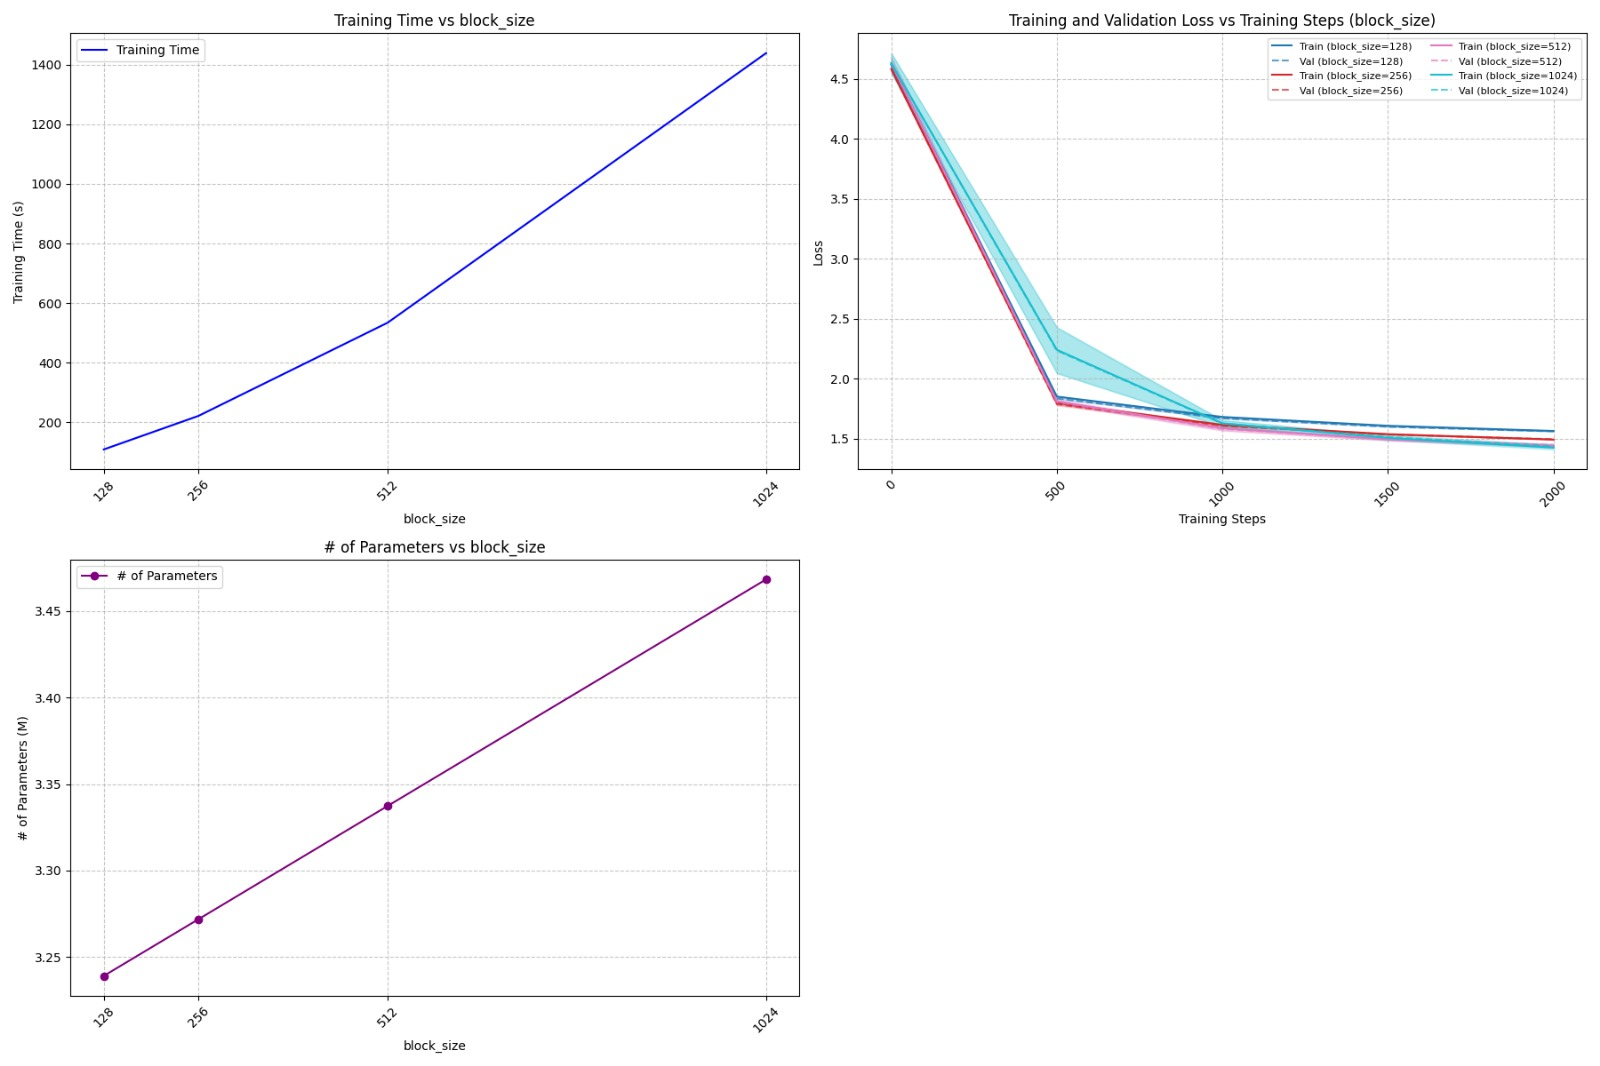
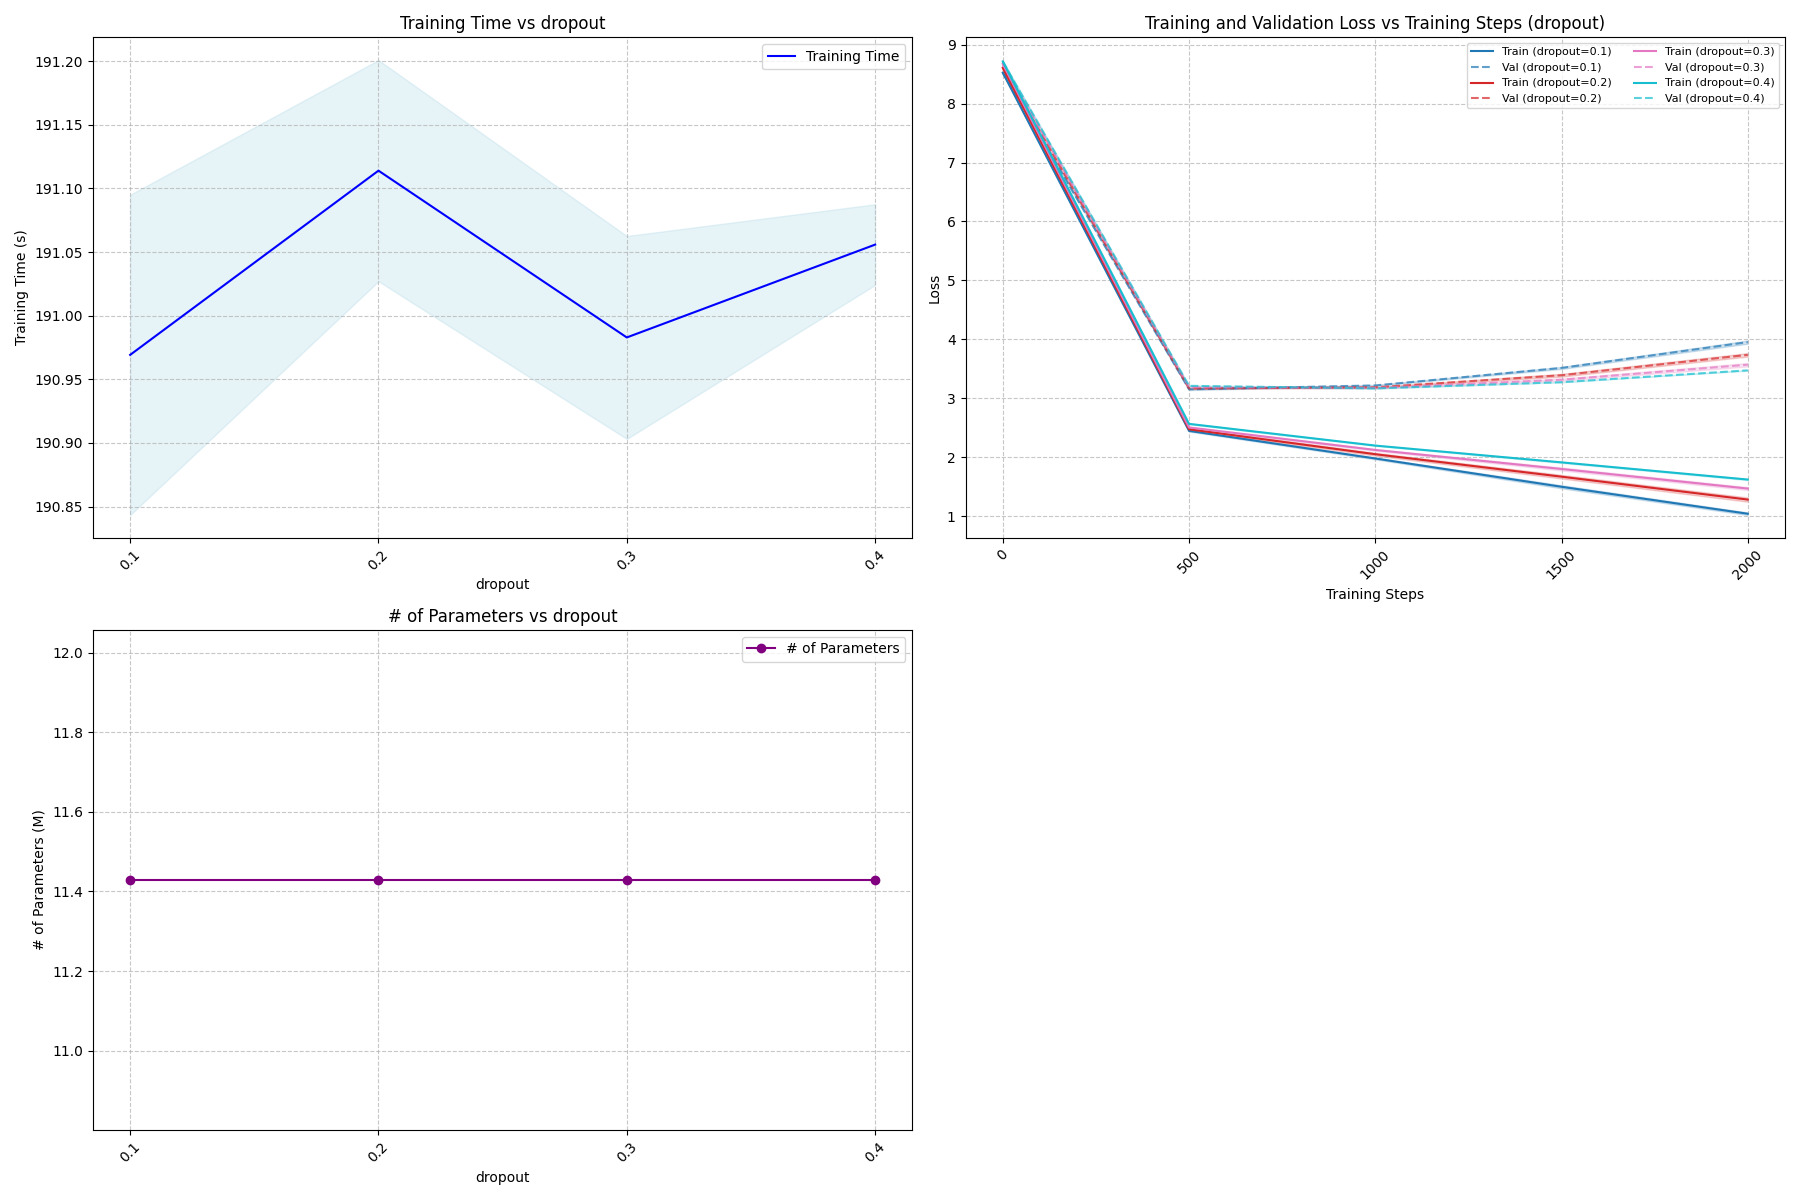

#### Considerations:
- **Training time**: the training time seems to increase as the block size does, but more than at the same rate, since doubling the block size results in more than the double of the previous training time. This result was expected, since the block size has a direct impact on the number of parameters and thus on the computations to be performed.
- **Training and validation loss**: the block size does not seem to have a great impact on the model loss, but is worth to notice that at 2000 epochs the model with the larger block size has a slightly lower loss, both for the training and validation ones.
- **Number of parameters**: it seems to grow linearly with the block size and this result was expected, since the block size is involved in shaping many elements of the network's structure.

In conclusion, we can say that the best block size for this scenario is 512, since it represents the best trade-off between training time and loss after 2000 epochs

### Impact of `batch_size`

In [ ]:
batch_sizes = [32, 64, 128, 256]
results_batch_size = test_parameter_variation('batch_size', batch_sizes, 128, 0, vocab_size, 256,
                                              4, 4, 0.2, 500, 2000, 1e-3, 3, 'c')
plot_results(results_batch_size, 'batch_size', 'batch_size_c.png')

```
Testing batch_size=32...
Run 1 of 3:
Train loss: 4.6089019775390625, Val loss: 4.608258247375488
Train loss: 1.975813865661621, Val loss: 1.964463233947754
Train loss: 1.8091925382614136, Val loss: 1.7911242246627808
Train loss: 1.7164487838745117, Val loss: 1.710908055305481
Train loss: 1.6697883605957031, Val loss: 1.6594332456588745
Run 2 of 3:
Train loss: 4.625730037689209, Val loss: 4.624719619750977
Train loss: 1.9689732789993286, Val loss: 1.9562790393829346
Train loss: 1.7905970811843872, Val loss: 1.786118745803833
Train loss: 1.7088780403137207, Val loss: 1.7074929475784302
Train loss: 1.66438627243042, Val loss: 1.656448245048523
Run 3 of 3:
Train loss: 4.691371440887451, Val loss: 4.691546440124512
Train loss: 1.959661602973938, Val loss: 1.9416347742080688
Train loss: 1.8007102012634277, Val loss: 1.7940036058425903
Train loss: 1.7199114561080933, Val loss: 1.7051565647125244
Train loss: 1.660170078277588, Val loss: 1.653723120689392
Aggregated results for batch_size=32:
Final train loss (mean ± std): 1.6648 ± 0.0039
Final val loss (mean ± std): 1.6565 ± 0.0023
Time (mean ± std): 125.72s ± 0.31s
# of parameters: 3.24M

Testing batch_size=64...
Run 1 of 3:
Train loss: 4.734025478363037, Val loss: 4.73530387878418
Train loss: 1.8437458276748657, Val loss: 1.835158109664917
Train loss: 1.684665560722351, Val loss: 1.6746822595596313
Train loss: 1.6050903797149658, Val loss: 1.5964267253875732
Train loss: 1.5639402866363525, Val loss: 1.5558030605316162
Run 2 of 3:
Train loss: 4.649659633636475, Val loss: 4.650285243988037
Train loss: 1.8550724983215332, Val loss: 1.8412158489227295
Train loss: 1.6893919706344604, Val loss: 1.6770788431167603
Train loss: 1.6132431030273438, Val loss: 1.6060627698898315
Train loss: 1.5713669061660767, Val loss: 1.5586624145507812
Run 3 of 3:
Train loss: 4.583005905151367, Val loss: 4.583639144897461
Train loss: 1.86017644405365, Val loss: 1.8484817743301392
Train loss: 1.6877243518829346, Val loss: 1.6780807971954346
Train loss: 1.6157664060592651, Val loss: 1.6061713695526123
Train loss: 1.5767245292663574, Val loss: 1.5679075717926025
Aggregated results for batch_size=64:
Final train loss (mean ± std): 1.5707 ± 0.0052
Final val loss (mean ± std): 1.5608 ± 0.0052
Time (mean ± std): 171.15s ± 0.12s
# of parameters: 3.24M

Testing batch_size=128...
Run 1 of 3:
Train loss: 4.671363353729248, Val loss: 4.671699523925781
Train loss: 1.749894380569458, Val loss: 1.7397582530975342
Train loss: 1.595619559288025, Val loss: 1.589369297027588
Train loss: 1.5326217412948608, Val loss: 1.5289738178253174
Train loss: 1.4971375465393066, Val loss: 1.4960707426071167
Run 2 of 3:
Train loss: 4.635778427124023, Val loss: 4.63585090637207
Train loss: 1.739414095878601, Val loss: 1.7279216051101685
Train loss: 1.5925390720367432, Val loss: 1.5875762701034546
Train loss: 1.5312632322311401, Val loss: 1.5258285999298096
Train loss: 1.495092749595642, Val loss: 1.497515082359314
Run 3 of 3:
Train loss: 4.663970947265625, Val loss: 4.6641693115234375
Train loss: 1.7388159036636353, Val loss: 1.730043888092041
Train loss: 1.594911813735962, Val loss: 1.587875485420227
Train loss: 1.5307940244674683, Val loss: 1.5258477926254272
Train loss: 1.5013861656188965, Val loss: 1.5009139776229858
Aggregated results for batch_size=128:
Final train loss (mean ± std): 1.4979 ± 0.0026
Final val loss (mean ± std): 1.4982 ± 0.0020
Time (mean ± std): 265.77s ± 0.22s
# of parameters: 3.24M

Testing batch_size=256...
Run 1 of 3:
Train loss: 4.699012279510498, Val loss: 4.699577808380127
Train loss: 1.6782279014587402, Val loss: 1.670027732849121
Train loss: 1.5339388847351074, Val loss: 1.530422568321228
Train loss: 1.4813672304153442, Val loss: 1.4853254556655884
Train loss: 1.4424606561660767, Val loss: 1.4528000354766846
Run 2 of 3:
Train loss: 4.583459377288818, Val loss: 4.583619594573975
Train loss: 1.6829990148544312, Val loss: 1.679038405418396
Train loss: 1.5345834493637085, Val loss: 1.5314764976501465
Train loss: 1.4781577587127686, Val loss: 1.4810798168182373
Train loss: 1.4465832710266113, Val loss: 1.4517751932144165
Run 3 of 3:
Train loss: 4.594211578369141, Val loss: 4.593421936035156
Train loss: 1.6669285297393799, Val loss: 1.6571054458618164
Train loss: 1.5244967937469482, Val loss: 1.5251187086105347
Train loss: 1.4744704961776733, Val loss: 1.4806469678878784
Train loss: 1.4417697191238403, Val loss: 1.4497448205947876
Aggregated results for batch_size=256:
Final train loss (mean ± std): 1.4436 ± 0.0021
Final val loss (mean ± std): 1.4514 ± 0.0013
Time (mean ± std): 453.01s ± 0.41s
# of parameters: 3.24M
```

![](https://raw.githubusercontent.com/martinasp00/MIRCV-Project/bd4ddd77964d16e820ca1152e8de53c41ccf5ebf/images/batch_size_c.jpeg)
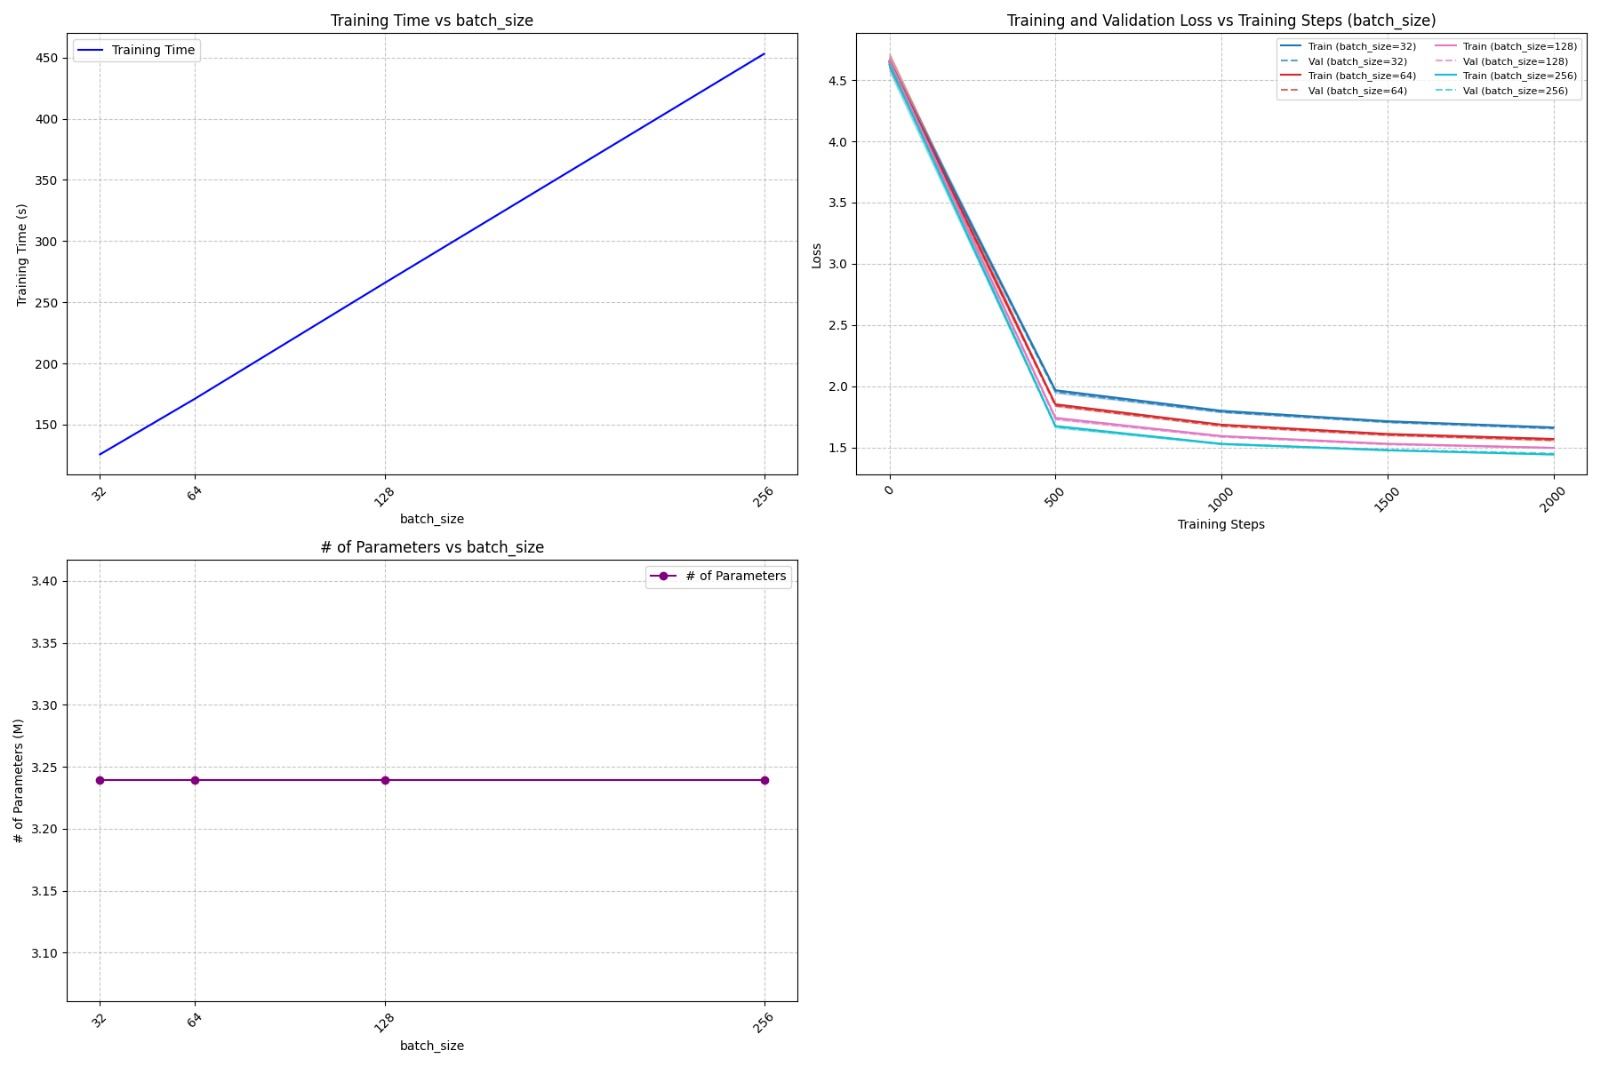

#### Considerations:
- **Training time**: the training time seems to increase linearly with the batch size. This result was expected, since a greater batch size means that more inputs are fed in parallel to the model, so a heavier computation load.
- **Training and validation loss**: the batch size has a noticeable impact on the model loss, as a greater batch size directly results in a lower loss after 2000 epochs, although in this case there is a narrower difference between the loss reached by the models with batch size 128 and 256 with respect to the other ones, suggesting that there may be a limit batch size above which there cannot be further loss reductions over 2000 epochs.
- **Number of parameters**: it is obviously not influenced by the batch size, since this parameter only affects the dimension of the token batches fed to the network in input, but not the network's structure itself.

In conclusion, we can say that the best batch size for this scenario is 256, since it represents the best trade-off between training time and loss after 2000 epochs, but the other values may be used to reduce the training time at the cost of a slightly higher loss, given a fixed number of epochs.

### Impact of `n_layer`

In [ ]:
n_layers = [2, 4, 6, 8]
results_n_layer = test_parameter_variation('n_layer', n_layers, 128, 64, vocab_size, 256, 4, 0, 0.2, 500, 2000, 1e-3, 3, 'c')
plot_results(results_n_layer, 'n_layer', 'n_layer_c.png')

```
Testing n_layer=2...
Run 1 of 3:
Train loss: 4.5950517654418945, Val loss: 4.594537734985352
Train loss: 1.8320727348327637, Val loss: 1.8228155374526978
Train loss: 1.7059762477874756, Val loss: 1.695176124572754
Train loss: 1.6450703144073486, Val loss: 1.6337189674377441
Train loss: 1.610070824623108, Val loss: 1.6098077297210693
Run 2 of 3:
Train loss: 4.7081170082092285, Val loss: 4.709344387054443
Train loss: 1.8422274589538574, Val loss: 1.8332780599594116
Train loss: 1.71205735206604, Val loss: 1.7022604942321777
Train loss: 1.6499900817871094, Val loss: 1.6458781957626343
Train loss: 1.6220968961715698, Val loss: 1.6151026487350464
Run 3 of 3:
Train loss: 4.6317338943481445, Val loss: 4.631872653961182
Train loss: 1.8310545682907104, Val loss: 1.819512963294983
Train loss: 1.7118139266967773, Val loss: 1.7004700899124146
Train loss: 1.6466494798660278, Val loss: 1.643907070159912
Train loss: 1.6137170791625977, Val loss: 1.6050883531570435
Aggregated results for n_layer=2:
Final train loss (mean ± std): 1.6153 ± 0.0050
Final val loss (mean ± std): 1.6100 ± 0.0041
Time (mean ± std): 92.27s ± 0.11s
# of parameters: 1.66M

Testing n_layer=4...
Run 1 of 3:
Train loss: 4.6697611808776855, Val loss: 4.669814586639404
Train loss: 1.8276845216751099, Val loss: 1.8151158094406128
Train loss: 1.6780993938446045, Val loss: 1.6677132844924927
Train loss: 1.6024307012557983, Val loss: 1.5993478298187256
Train loss: 1.5626887083053589, Val loss: 1.5578616857528687
Run 2 of 3:
Train loss: 4.615118503570557, Val loss: 4.613220691680908
Train loss: 1.8389931917190552, Val loss: 1.8300120830535889
Train loss: 1.6860023736953735, Val loss: 1.6803683042526245
Train loss: 1.616702914237976, Val loss: 1.6090115308761597
Train loss: 1.5713237524032593, Val loss: 1.5671592950820923
Run 3 of 3:
Train loss: 4.654433727264404, Val loss: 4.65334939956665
Train loss: 1.8324388265609741, Val loss: 1.8215281963348389
Train loss: 1.687803030014038, Val loss: 1.6728920936584473
Train loss: 1.6143691539764404, Val loss: 1.6074604988098145
Train loss: 1.571720004081726, Val loss: 1.5676467418670654
Aggregated results for n_layer=4:
Final train loss (mean ± std): 1.5686 ± 0.0042
Final val loss (mean ± std): 1.5642 ± 0.0045
Time (mean ± std): 170.41s ± 0.10s
# of parameters: 3.24M

Testing n_layer=6...
Run 1 of 3:
Train loss: 4.527345180511475, Val loss: 4.527914047241211
Train loss: 1.8737984895706177, Val loss: 1.8630374670028687
Train loss: 1.6906837224960327, Val loss: 1.676853060722351
Train loss: 1.6068459749221802, Val loss: 1.597241997718811
Train loss: 1.558648705482483, Val loss: 1.5561304092407227
Run 2 of 3:
Train loss: 4.68033504486084, Val loss: 4.679651260375977
Train loss: 1.9215997457504272, Val loss: 1.912643313407898
Train loss: 1.698348045349121, Val loss: 1.6890885829925537
Train loss: 1.617178201675415, Val loss: 1.6050233840942383
Train loss: 1.568551778793335, Val loss: 1.5608551502227783
Run 3 of 3:
Train loss: 4.614062309265137, Val loss: 4.613714218139648
Train loss: 1.8807224035263062, Val loss: 1.869348406791687
Train loss: 1.6781280040740967, Val loss: 1.6747344732284546
Train loss: 1.5972473621368408, Val loss: 1.5898648500442505
Train loss: 1.5520660877227783, Val loss: 1.5466108322143555
Aggregated results for n_layer=6:
Final train loss (mean ± std): 1.5598 ± 0.0068
Final val loss (mean ± std): 1.5545 ± 0.0059
Time (mean ± std): 249.85s ± 0.23s
# of parameters: 4.82M

Testing n_layer=8...
Run 1 of 3:
Train loss: 4.753113269805908, Val loss: 4.755019187927246
Train loss: 1.9310424327850342, Val loss: 1.9199162721633911
Train loss: 1.696051836013794, Val loss: 1.6871410608291626
Train loss: 1.6034945249557495, Val loss: 1.5952180624008179
Train loss: 1.5416392087936401, Val loss: 1.535695195198059
Run 2 of 3:
Train loss: 4.731109142303467, Val loss: 4.731491565704346
Train loss: 1.895155906677246, Val loss: 1.8882741928100586
Train loss: 1.6746931076049805, Val loss: 1.6714692115783691
Train loss: 1.588707685470581, Val loss: 1.5781166553497314
Train loss: 1.531548261642456, Val loss: 1.5308783054351807
Run 3 of 3:
Train loss: 4.519952297210693, Val loss: 4.518896579742432
Train loss: 1.99290132522583, Val loss: 1.9846506118774414
Train loss: 1.7166781425476074, Val loss: 1.7053347826004028
Train loss: 1.6160060167312622, Val loss: 1.6028697490692139
Train loss: 1.5652720928192139, Val loss: 1.560774326324463
Aggregated results for n_layer=8:
Final train loss (mean ± std): 1.5462 ± 0.0141
Final val loss (mean ± std): 1.5424 ± 0.0131
Time (mean ± std): 326.91s ± 0.14s
# of parameters: 6.39M
```

![](https://raw.githubusercontent.com/martinasp00/MIRCV-Project/bd4ddd77964d16e820ca1152e8de53c41ccf5ebf/images/n_layer_c.jpeg)
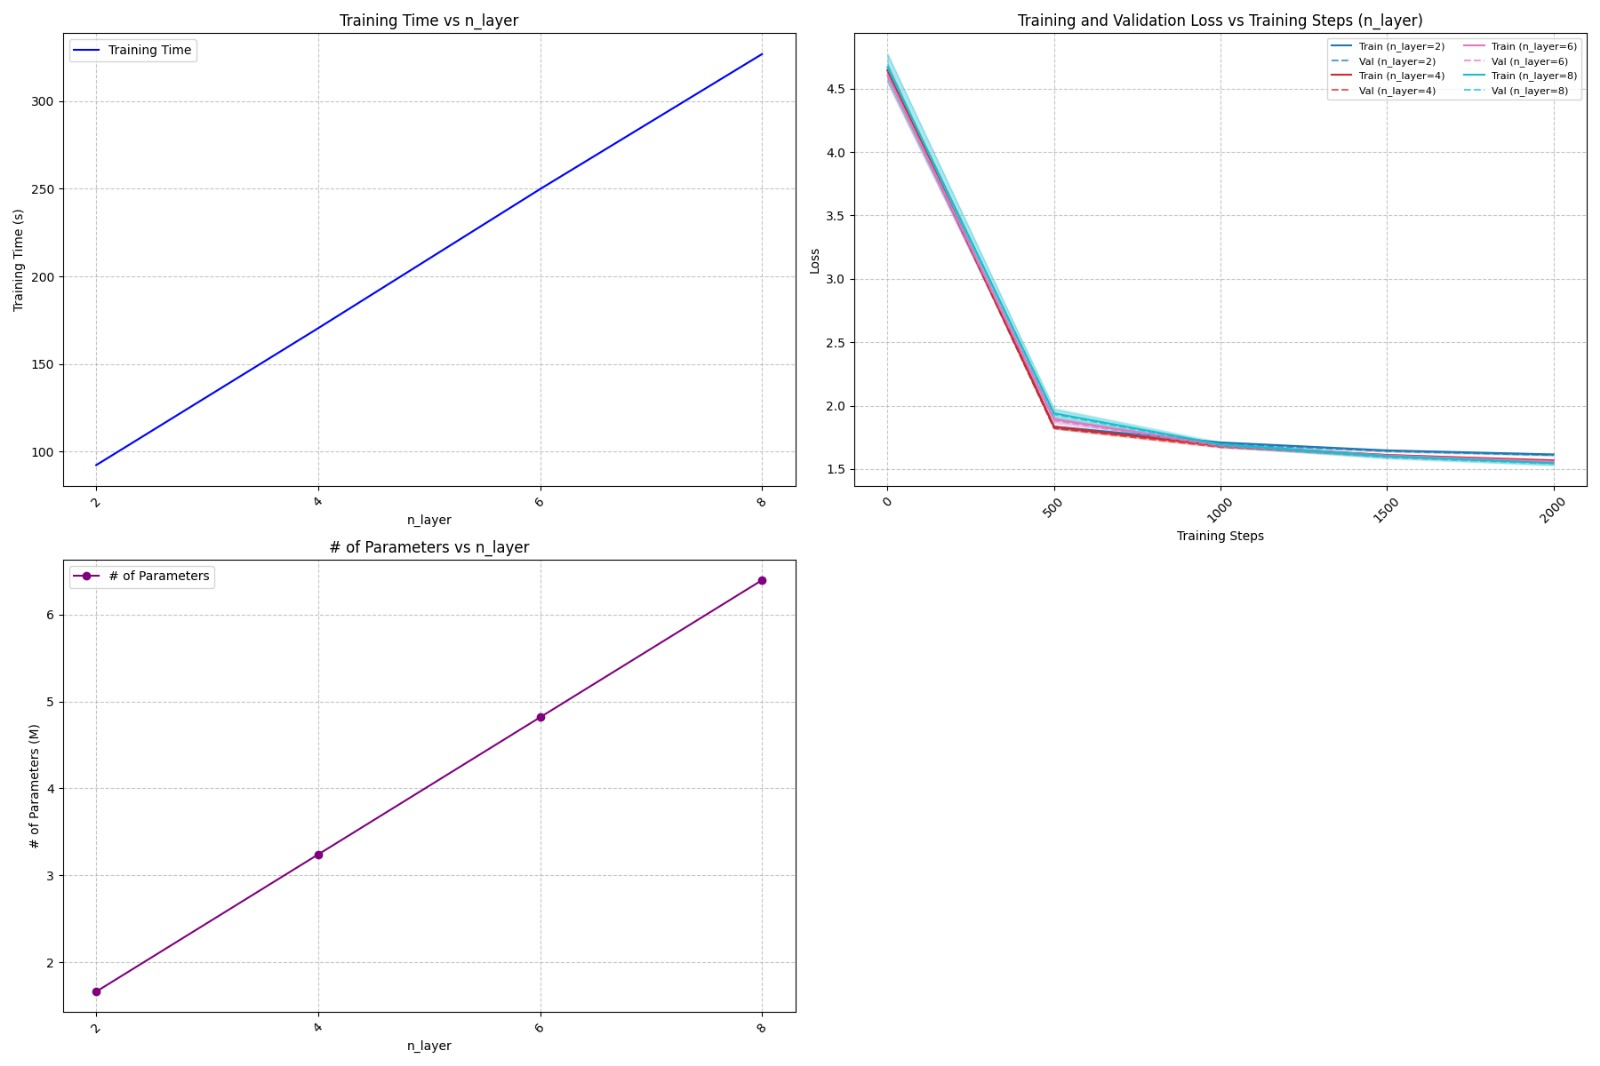

#### Considerations:
- **Training time**: the training time seems to increase almost at the same rate as the n_layer parameter. This result was expected: more layers mean a greater computational load. The number of layer is the number of transformer blocks added to the network.
- **Training and validation loss**: the number of layers has little to no impact on the model loss. We expected the opposite, but this result can be explained by multiple factors: the layer normalisation performed could mitigate the effects of multiple layers along with the dropout parameter that introduces noise in the network. Also, the number of attention heads and embeddings could be too small to appreciate the contribution of more layers. Ideally, multiple layers should be useful to detect more complex representations of the data.
- **Number of parameters**: it is obviously influenced by the number of layers, since at each new configuration we are adding blocks to the network, greatly increasing its number of parameters.

In conclusion, we can say that for this scenario any number of layers over 4 may be not useful unless we increase the number of embeddings and attention heads, but the increase in training time and total parameters may make the additional layers' contribution not worth.

### Impact of `n_head` and `n_embd`
These two parameters present a dependency, thus they have to be analysed in specific values combinations. In particular, `n_embd` must be divisible by `n_head`, since the input tensor of the self-attention will be split in ${n\_head}$ tensors, each one of dimension $n\_embd\times head\_size$, where $head\_size=\frac{n\_embd}{n\_head}$

In [ ]:
n_heads = [2, 4, 6]
n_embds = [128, 256, 384, 512]
results_n_head_n_embd = test_n_heads_n_embds(128, 64, vocab_size, n_embds, n_heads, 4, 0.2, 500, 2000, 1e-3, 3, 'c')
plot_results_n_head_n_embd(results_n_head_n_embd, 'n_head_n_embd_c.png')

```
Testing n_head=2, n_embd=128...
Run 1 of 3:
Train loss: 4.582273960113525, Val loss: 4.582345962524414
Train loss: 1.8972320556640625, Val loss: 1.888901948928833
Train loss: 1.7586603164672852, Val loss: 1.7502987384796143
Train loss: 1.6856988668441772, Val loss: 1.6797596216201782
Train loss: 1.6554017066955566, Val loss: 1.6441738605499268
Run 2 of 3:
Train loss: 4.60807991027832, Val loss: 4.608161449432373
Train loss: 1.8954672813415527, Val loss: 1.8813674449920654
Train loss: 1.7485851049423218, Val loss: 1.736933708190918
Train loss: 1.6838390827178955, Val loss: 1.6724423170089722
Train loss: 1.6454453468322754, Val loss: 1.6351101398468018
Run 3 of 3:
Train loss: 4.615650177001953, Val loss: 4.615469455718994
Train loss: 1.8950483798980713, Val loss: 1.8851344585418701
Train loss: 1.743013620376587, Val loss: 1.7394020557403564
Train loss: 1.6878689527511597, Val loss: 1.6746032238006592
Train loss: 1.6475785970687866, Val loss: 1.6303178071975708
Aggregated results for n_head=2, n_embd=128:
Final train loss (mean ± std): 1.6495 ± 0.0043
Final val loss (mean ± std): 1.6365 ± 0.0057
Time (mean ± std): 85.57s ± 0.23s
# of parameters: 0.83M

Testing n_head=2, n_embd=256...
Run 1 of 3:
Train loss: 4.559317111968994, Val loss: 4.558938980102539
Train loss: 1.8765949010849, Val loss: 1.869581699371338
Train loss: 1.7206413745880127, Val loss: 1.7068884372711182
Train loss: 1.6440415382385254, Val loss: 1.633792757987976
Train loss: 1.6022162437438965, Val loss: 1.5983775854110718
Run 2 of 3:
Train loss: 4.666648864746094, Val loss: 4.667459011077881
Train loss: 1.8598887920379639, Val loss: 1.8507312536239624
Train loss: 1.71527898311615, Val loss: 1.7049974203109741
Train loss: 1.638569951057434, Val loss: 1.631874680519104
Train loss: 1.592047929763794, Val loss: 1.5833114385604858
Run 3 of 3:
Train loss: 4.783571720123291, Val loss: 4.783267974853516
Train loss: 1.8563247919082642, Val loss: 1.840612530708313
Train loss: 1.7015877962112427, Val loss: 1.6953026056289673
Train loss: 1.6426948308944702, Val loss: 1.629869818687439
Train loss: 1.5938841104507446, Val loss: 1.586222529411316
Aggregated results for n_head=2, n_embd=256:
Final train loss (mean ± std): 1.5960 ± 0.0044
Final val loss (mean ± std): 1.5893 ± 0.0065
Time (mean ± std): 139.29s ± 0.40s
# of parameters: 3.24M

Testing n_head=2, n_embd=384...
Run 1 of 3:
Train loss: 4.628796577453613, Val loss: 4.632056713104248
Train loss: 2.2056076526641846, Val loss: 2.186640739440918
Train loss: 1.9273806810379028, Val loss: 1.9220938682556152
Train loss: 1.7995976209640503, Val loss: 1.7885491847991943
Train loss: 1.712003231048584, Val loss: 1.7059670686721802
Run 2 of 3:
Train loss: 4.717521667480469, Val loss: 4.719558238983154
Train loss: 2.134971857070923, Val loss: 2.126760959625244
Train loss: 1.9219088554382324, Val loss: 1.9059884548187256
Train loss: 1.763360857963562, Val loss: 1.7491642236709595
Train loss: 1.695666790008545, Val loss: 1.6798608303070068
Run 3 of 3:
Train loss: 4.638458728790283, Val loss: 4.639957904815674
Train loss: 2.232950210571289, Val loss: 2.2189927101135254
Train loss: 1.9959388971328735, Val loss: 1.9833015203475952
Train loss: 1.9078893661499023, Val loss: 1.902999758720398
Train loss: 1.8404197692871094, Val loss: 1.835605263710022
Aggregated results for n_head=2, n_embd=384:
Final train loss (mean ± std): 1.7494 ± 0.0647
Final val loss (mean ± std): 1.7405 ± 0.0681
Time (mean ± std): 204.80s ± 0.26s
# of parameters: 7.22M

Testing n_head=2, n_embd=512...
Run 1 of 3:
Train loss: 4.706841468811035, Val loss: 4.707364082336426
Train loss: 2.4398903846740723, Val loss: 2.426534652709961
Train loss: 2.153701066970825, Val loss: 2.145388126373291
Train loss: 2.1248061656951904, Val loss: 2.116223096847534
Train loss: 2.128875494003296, Val loss: 2.118596076965332
Run 2 of 3:
Train loss: 4.630818843841553, Val loss: 4.630439281463623
Train loss: 2.1558992862701416, Val loss: 2.144866704940796
Train loss: 2.0173521041870117, Val loss: 2.0081005096435547
Train loss: 1.9350031614303589, Val loss: 1.9227432012557983
Train loss: 1.8755364418029785, Val loss: 1.8657760620117188
Run 3 of 3:
Train loss: 4.595432281494141, Val loss: 4.59650182723999
Train loss: 2.4174540042877197, Val loss: 2.405989170074463
Train loss: 2.156229019165039, Val loss: 2.149479389190674
Train loss: 2.139286756515503, Val loss: 2.1305832862854004
Train loss: 2.123997449874878, Val loss: 2.1168627738952637
Aggregated results for n_head=2, n_embd=512:
Final train loss (mean ± std): 2.0428 ± 0.1183
Final val loss (mean ± std): 2.0337 ± 0.1188
Time (mean ± std): 296.10s ± 0.06s
# of parameters: 12.77M

Testing n_head=4, n_embd=128...
Run 1 of 3:
Train loss: 4.550525665283203, Val loss: 4.551019668579102
Train loss: 1.8738141059875488, Val loss: 1.8641985654830933
Train loss: 1.7242279052734375, Val loss: 1.7061963081359863
Train loss: 1.652005910873413, Val loss: 1.6400479078292847
Train loss: 1.6125303506851196, Val loss: 1.6035538911819458
Run 2 of 3:
Train loss: 4.6433210372924805, Val loss: 4.642977237701416
Train loss: 1.8685413599014282, Val loss: 1.8616535663604736
Train loss: 1.7221499681472778, Val loss: 1.7159945964813232
Train loss: 1.6518322229385376, Val loss: 1.644301414489746
Train loss: 1.6096251010894775, Val loss: 1.6036683320999146
Run 3 of 3:
Train loss: 4.572817802429199, Val loss: 4.5728020668029785
Train loss: 1.8735687732696533, Val loss: 1.8616042137145996
Train loss: 1.722198486328125, Val loss: 1.7148643732070923
Train loss: 1.648400068283081, Val loss: 1.6410609483718872
Train loss: 1.6197603940963745, Val loss: 1.6080918312072754
Aggregated results for n_head=4, n_embd=128:
Final train loss (mean ± std): 1.6140 ± 0.0043
Final val loss (mean ± std): 1.6051 ± 0.0021
Time (mean ± std): 122.20s ± 0.14s
# of parameters: 0.83M

Testing n_head=4, n_embd=256...
Run 1 of 3:
Train loss: 4.6787919998168945, Val loss: 4.679811000823975
Train loss: 1.8648208379745483, Val loss: 1.8540931940078735
Train loss: 1.6919025182724, Val loss: 1.6756658554077148
Train loss: 1.6195783615112305, Val loss: 1.610601782798767
Train loss: 1.580153465270996, Val loss: 1.5684089660644531
Run 2 of 3:
Train loss: 4.600646495819092, Val loss: 4.600283622741699
Train loss: 1.8610217571258545, Val loss: 1.855208158493042
Train loss: 1.6890472173690796, Val loss: 1.6802470684051514
Train loss: 1.614203691482544, Val loss: 1.6046024560928345
Train loss: 1.5702717304229736, Val loss: 1.560186505317688
Run 3 of 3:
Train loss: 4.507359504699707, Val loss: 4.507420539855957
Train loss: 1.874276876449585, Val loss: 1.8654584884643555
Train loss: 1.6951614618301392, Val loss: 1.6873342990875244
Train loss: 1.6200042963027954, Val loss: 1.6107487678527832
Train loss: 1.5716570615768433, Val loss: 1.570054531097412
Aggregated results for n_head=4, n_embd=256:
Final train loss (mean ± std): 1.5740 ± 0.0044
Final val loss (mean ± std): 1.5662 ± 0.0043
Time (mean ± std): 170.88s ± 0.02s
# of parameters: 3.24M

Testing n_head=4, n_embd=384...
Run 1 of 3:
Train loss: 4.640091419219971, Val loss: 4.6395721435546875
Train loss: 2.0326600074768066, Val loss: 2.027669906616211
Train loss: 1.7838751077651978, Val loss: 1.7746272087097168
Train loss: 1.679272174835205, Val loss: 1.6687824726104736
Train loss: 1.6203340291976929, Val loss: 1.609220266342163
Run 2 of 3:
Train loss: 4.6924967765808105, Val loss: 4.692788600921631
Train loss: 2.030503749847412, Val loss: 2.0149621963500977
Train loss: 1.7926771640777588, Val loss: 1.781307578086853
Train loss: 1.694746971130371, Val loss: 1.6845706701278687
Train loss: 1.619287133216858, Val loss: 1.6159336566925049
Run 3 of 3:
Train loss: 4.696633338928223, Val loss: 4.697200775146484
Train loss: 2.043935775756836, Val loss: 2.031881332397461
Train loss: 1.849599003791809, Val loss: 1.8415695428848267
Train loss: 1.7406213283538818, Val loss: 1.732390284538269
Train loss: 1.6737463474273682, Val loss: 1.6677119731903076
Aggregated results for n_head=4, n_embd=384:
Final train loss (mean ± std): 1.6378 ± 0.0254
Final val loss (mean ± std): 1.6310 ± 0.0261
Time (mean ± std): 245.22s ± 0.24s
# of parameters: 7.22M

Testing n_head=4, n_embd=512...
Run 1 of 3:
Train loss: 4.673778533935547, Val loss: 4.674810886383057
Train loss: 2.17033052444458, Val loss: 2.162519931793213
Train loss: 1.9245914220809937, Val loss: 1.915776014328003
Train loss: 1.83674955368042, Val loss: 1.8257185220718384
Train loss: 1.7836096286773682, Val loss: 1.7757455110549927
Run 2 of 3:
Train loss: 4.680566310882568, Val loss: 4.681238174438477
Train loss: 2.10233211517334, Val loss: 2.099048137664795
Train loss: 1.9059536457061768, Val loss: 1.8950730562210083
Train loss: 1.8360354900360107, Val loss: 1.8292094469070435
Train loss: 1.788718581199646, Val loss: 1.776513695716858
Run 3 of 3:
Train loss: 4.735833644866943, Val loss: 4.7356157302856445
Train loss: 2.1179184913635254, Val loss: 2.1090903282165527
Train loss: 1.9139647483825684, Val loss: 1.9083842039108276
Train loss: 1.823982834815979, Val loss: 1.8139251470565796
Train loss: 1.775364637374878, Val loss: 1.7663421630859375
Aggregated results for n_head=4, n_embd=512:
Final train loss (mean ± std): 1.7826 ± 0.0055
Final val loss (mean ± std): 1.7729 ± 0.0046
Time (mean ± std): 334.34s ± 0.28s
# of parameters: 12.77M

Testing n_head=6, n_embd=384...
Run 1 of 3:
Train loss: 4.523959159851074, Val loss: 4.522763729095459
Train loss: 1.9857929944992065, Val loss: 1.978370189666748
Train loss: 1.735715389251709, Val loss: 1.7169667482376099
Train loss: 1.6368809938430786, Val loss: 1.6299629211425781
Train loss: 1.5858547687530518, Val loss: 1.5787190198898315
Run 2 of 3:
Train loss: 4.632892608642578, Val loss: 4.632760524749756
Train loss: 2.0306715965270996, Val loss: 2.019712448120117
Train loss: 1.7973653078079224, Val loss: 1.789858341217041
Train loss: 1.6865289211273193, Val loss: 1.675356388092041
Train loss: 1.6184784173965454, Val loss: 1.6111847162246704
Run 3 of 3:
Train loss: 4.530920028686523, Val loss: 4.5314154624938965
Train loss: 1.9674172401428223, Val loss: 1.9517996311187744
Train loss: 1.7545908689498901, Val loss: 1.7442187070846558
Train loss: 1.6462085247039795, Val loss: 1.636452078819275
Train loss: 1.5882290601730347, Val loss: 1.587982177734375
Aggregated results for n_head=6, n_embd=384:
Final train loss (mean ± std): 1.5975 ± 0.0149
Final val loss (mean ± std): 1.5926 ± 0.0137
Time (mean ± std): 291.79s ± 0.67s
# of parameters: 7.22M
```

![](https://raw.githubusercontent.com/martinasp00/MIRCV-Project/bd4ddd77964d16e820ca1152e8de53c41ccf5ebf/images/n_head_n_embed_c.jpeg)
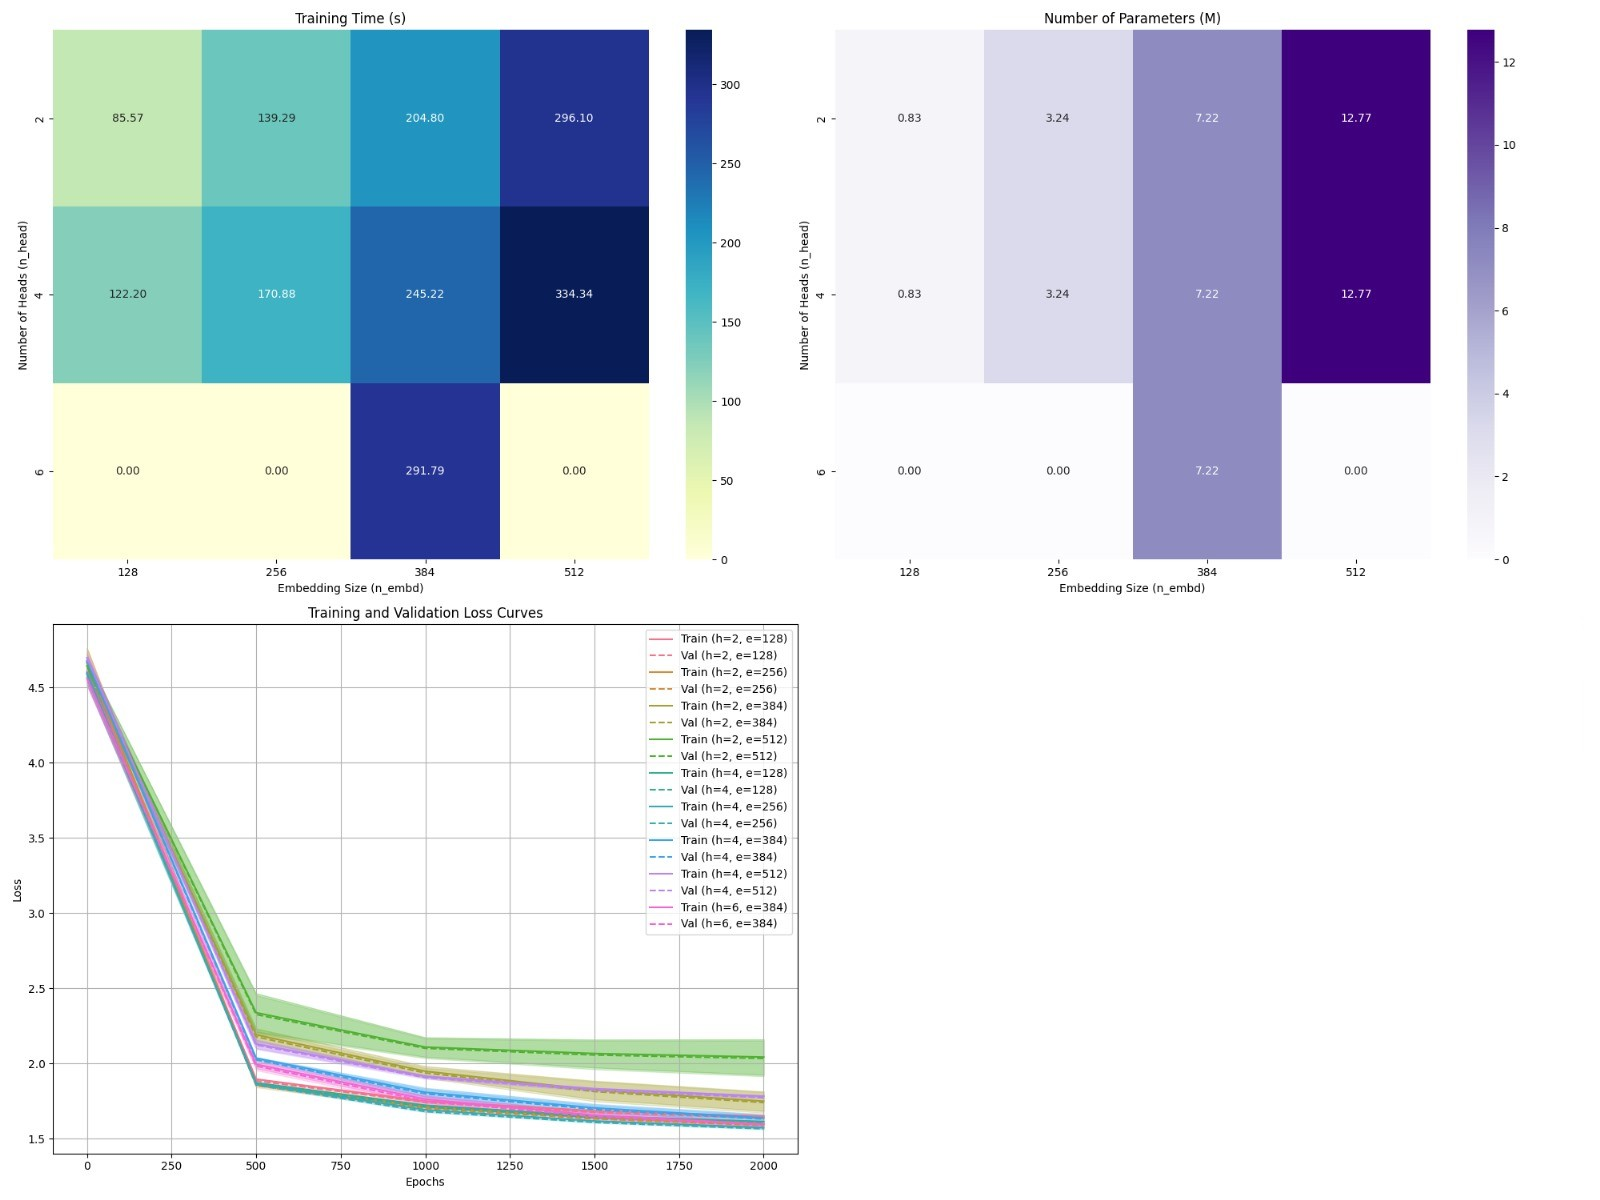

#### Considerations:
- **Training time**: the training time seems to increase at the same rate as the embedding size (n_embd parameter). This is also true for the number of attention heads, but the impact on the time elapsed is noticeably lower.
- **Number of parameters**: it is obviously not influenced by the number of attention heads, since more of them do not mean more parameters of the network. The situation is different for n_embd, since it has an extremely powerful impact on the number of parameters, making it the most impactful value we analized so far. This influence was expected since the embedding size is a value used to shape many components (e.g. embedding table, positional embedding table, output layer).
- **Training and validation loss**: from the graph is evident that simply increasing one of those two parameters is not the right strategy to bring down the loss. There are better and worse values combinations, with the ones that have a lower embedding size achieving better results. If we fix the number of heads, blindly increasing the embedding size does not seem a good idea, while if we fix the embedding size some improvements can be noticed by increasing the number of heads. In general, 256 seems to be the best embedding size, achieving the best results for both the cases in which the number of heads was 2 and 4. The loss of these two cases was closely followed by the one of the model with 6 attention heads and 384 embeddings, suggesting that both parameters can be increased if a certain balance is kept, but at the cost of a longer training time, many more parameters, and a slighlty higher loss, at least after 2000 epochs.

In conclusion, we can say that for this scenario the best combination of `n_head` and `n_embd` was (4, 256), that achieved great results for every performance index we studied.

### Impact of `dropout`

In [ ]:
dropout_rates = [0.1, 0.2, 0.3, 0.4]
results_dropout = test_parameter_variation('dropout', dropout_rates, 256, 64, vocab_size, 256, 4, 4, 0, 500, 2500, 1e-3, 3, 'c')
plot_results(results_dropout, 'dropout', 'dropout_c.png')

```
Testing dropout=0.1...
Run 1 of 3:
Train loss: 4.606039524078369, Val loss: 4.6062703132629395
Train loss: 1.8361451625823975, Val loss: 1.831838846206665
Train loss: 1.673589825630188, Val loss: 1.667609453201294
Train loss: 1.597023367881775, Val loss: 1.586696743965149
Train loss: 1.5540704727172852, Val loss: 1.5441471338272095
Run 2 of 3:
Train loss: 4.599730968475342, Val loss: 4.6004462242126465
Train loss: 1.8657324314117432, Val loss: 1.8538758754730225
Train loss: 1.675911545753479, Val loss: 1.6732535362243652
Train loss: 1.604487419128418, Val loss: 1.5960934162139893
Train loss: 1.5672911405563354, Val loss: 1.5558148622512817
Run 3 of 3:
Train loss: 4.705787181854248, Val loss: 4.706801891326904
Train loss: 1.8062738180160522, Val loss: 1.7896443605422974
Train loss: 1.654111385345459, Val loss: 1.6476424932479858
Train loss: 1.593765377998352, Val loss: 1.5842013359069824
Train loss: 1.5462939739227295, Val loss: 1.546634554862976
Aggregated results for dropout=0.1:
Final train loss (mean ± std): 1.5559 ± 0.0087
Final val loss (mean ± std): 1.5489 ± 0.0050
Time (mean ± std): 176.73s ± 0.36s
# of parameters: 3.24M

Testing dropout=0.2...
Run 1 of 3:
Train loss: 4.601995468139648, Val loss: 4.601705074310303
Train loss: 1.8522170782089233, Val loss: 1.841780424118042
Train loss: 1.6813225746154785, Val loss: 1.6735965013504028
Train loss: 1.609129786491394, Val loss: 1.6017584800720215
Train loss: 1.5636149644851685, Val loss: 1.560765266418457
Run 2 of 3:
Train loss: 4.679593563079834, Val loss: 4.67981481552124
Train loss: 1.831190824508667, Val loss: 1.8166351318359375
Train loss: 1.6801490783691406, Val loss: 1.6742875576019287
Train loss: 1.6114422082901, Val loss: 1.6035197973251343
Train loss: 1.5652363300323486, Val loss: 1.5641964673995972
Run 3 of 3:
Train loss: 4.551435947418213, Val loss: 4.548767566680908
Train loss: 1.836843729019165, Val loss: 1.8298264741897583
Train loss: 1.6852684020996094, Val loss: 1.6772335767745972
Train loss: 1.6053555011749268, Val loss: 1.601080060005188
Train loss: 1.5746515989303589, Val loss: 1.5585800409317017
Aggregated results for dropout=0.2:
Final train loss (mean ± std): 1.5678 ± 0.0049
Final val loss (mean ± std): 1.5612 ± 0.0023
Time (mean ± std): 176.04s ± 0.28s
# of parameters: 3.24M

Testing dropout=0.3...
Run 1 of 3:
Train loss: 4.519893169403076, Val loss: 4.519279956817627
Train loss: 1.881792426109314, Val loss: 1.8670871257781982
Train loss: 1.7273130416870117, Val loss: 1.7208847999572754
Train loss: 1.6467790603637695, Val loss: 1.6340945959091187
Train loss: 1.597121238708496, Val loss: 1.59303617477417
Run 2 of 3:
Train loss: 4.605952739715576, Val loss: 4.606100559234619
Train loss: 1.8652056455612183, Val loss: 1.8575730323791504
Train loss: 1.7032545804977417, Val loss: 1.6953426599502563
Train loss: 1.6370797157287598, Val loss: 1.6312971115112305
Train loss: 1.591102957725525, Val loss: 1.5867772102355957
Run 3 of 3:
Train loss: 4.665105819702148, Val loss: 4.66545295715332
Train loss: 1.8925634622573853, Val loss: 1.8811233043670654
Train loss: 1.7207242250442505, Val loss: 1.7102348804473877
Train loss: 1.6374582052230835, Val loss: 1.6366424560546875
Train loss: 1.5989323854446411, Val loss: 1.5929738283157349
Aggregated results for dropout=0.3:
Final train loss (mean ± std): 1.5957 ± 0.0033
Final val loss (mean ± std): 1.5909 ± 0.0029
Time (mean ± std): 175.20s ± 0.27s
# of parameters: 3.24M

Testing dropout=0.4...
Run 1 of 3:
Train loss: 4.6137919425964355, Val loss: 4.615299224853516
Train loss: 1.9022033214569092, Val loss: 1.8929516077041626
Train loss: 1.7920477390289307, Val loss: 1.7776176929473877
Train loss: 1.7028067111968994, Val loss: 1.6909812688827515
Train loss: 1.6902514696121216, Val loss: 1.6836106777191162
Run 2 of 3:
Train loss: 4.604989051818848, Val loss: 4.605969429016113
Train loss: 1.905159592628479, Val loss: 1.890913724899292
Train loss: 1.7389127016067505, Val loss: 1.7249184846878052
Train loss: 1.6928423643112183, Val loss: 1.6825677156448364
Train loss: 1.6501719951629639, Val loss: 1.6478773355484009
Run 3 of 3:
Train loss: 4.703105926513672, Val loss: 4.7036285400390625
Train loss: 1.929740309715271, Val loss: 1.9190969467163086
Train loss: 1.747411847114563, Val loss: 1.7443184852600098
Train loss: 1.6834760904312134, Val loss: 1.6786803007125854
Train loss: 1.639803409576416, Val loss: 1.6351141929626465
Aggregated results for dropout=0.4:
Final train loss (mean ± std): 1.6601 ± 0.0218
Final val loss (mean ± std): 1.6555 ± 0.0205
Time (mean ± std): 175.36s ± 0.48s
# of parameters: 3.24M
```

![](https://raw.githubusercontent.com/martinasp00/MIRCV-Project/bd4ddd77964d16e820ca1152e8de53c41ccf5ebf/images/dropout_c.jpeg)
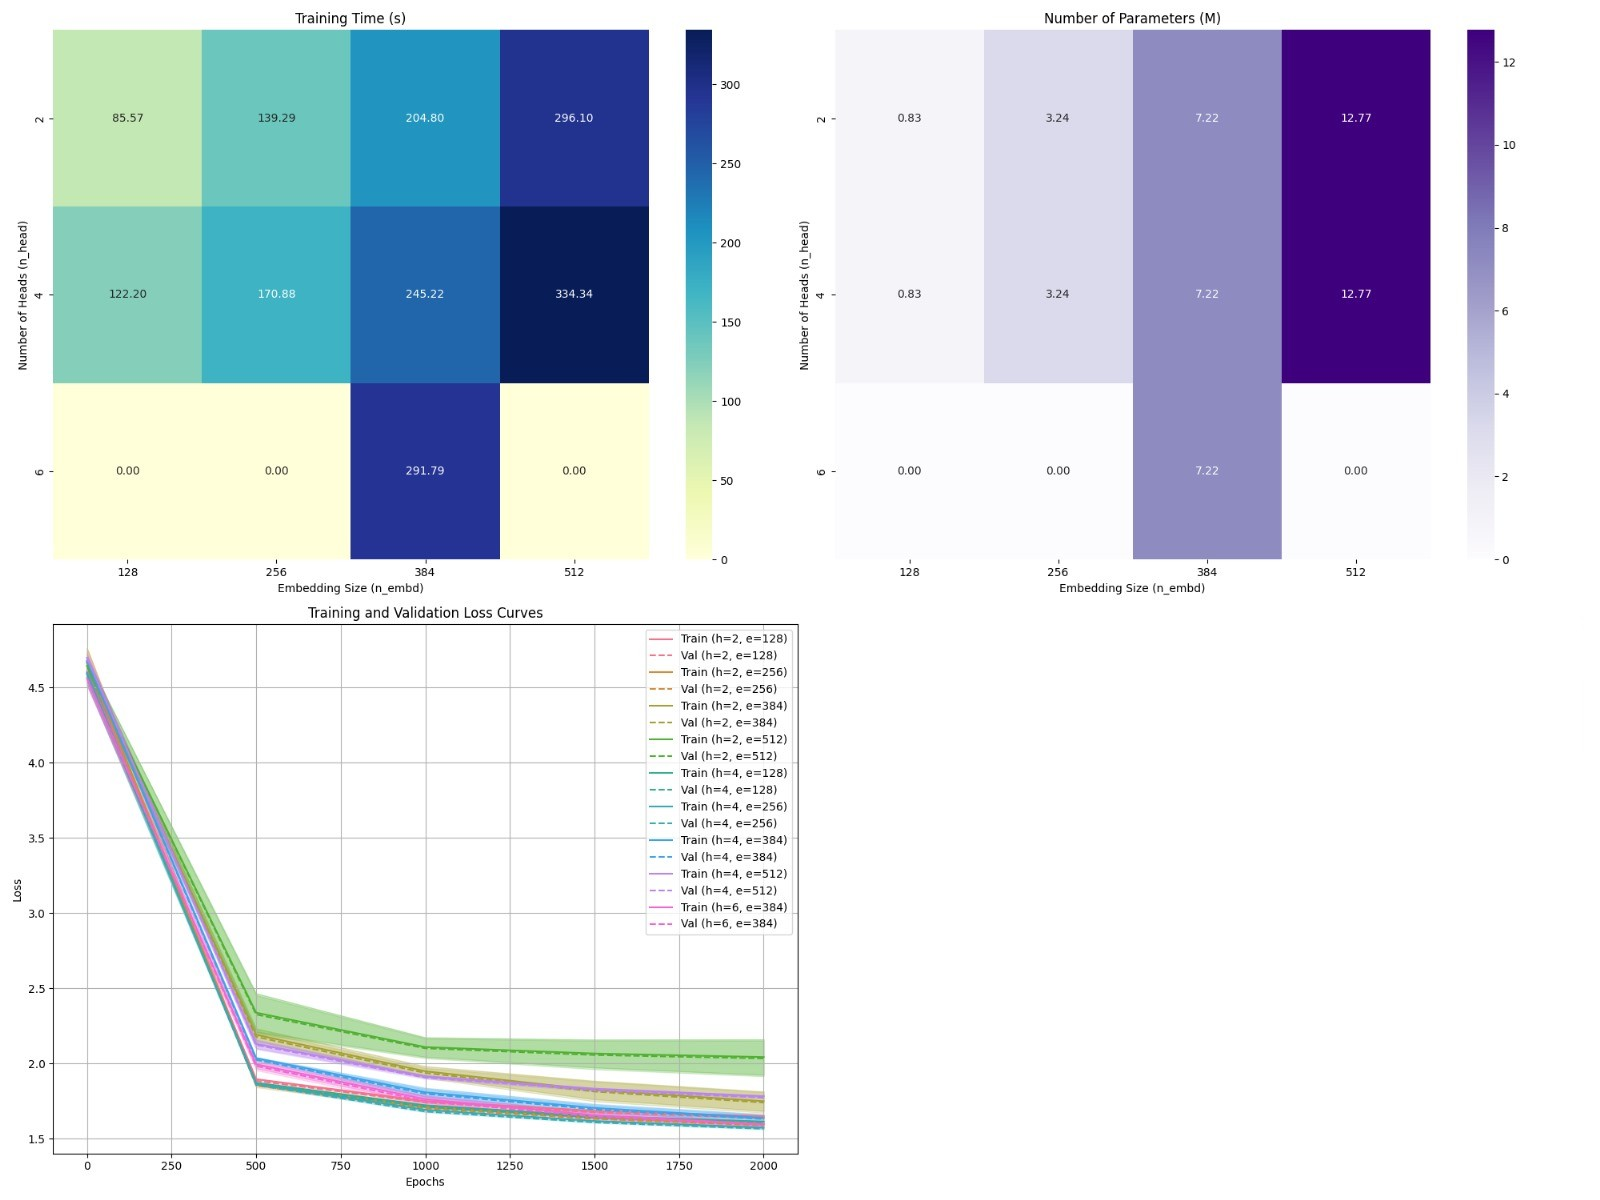
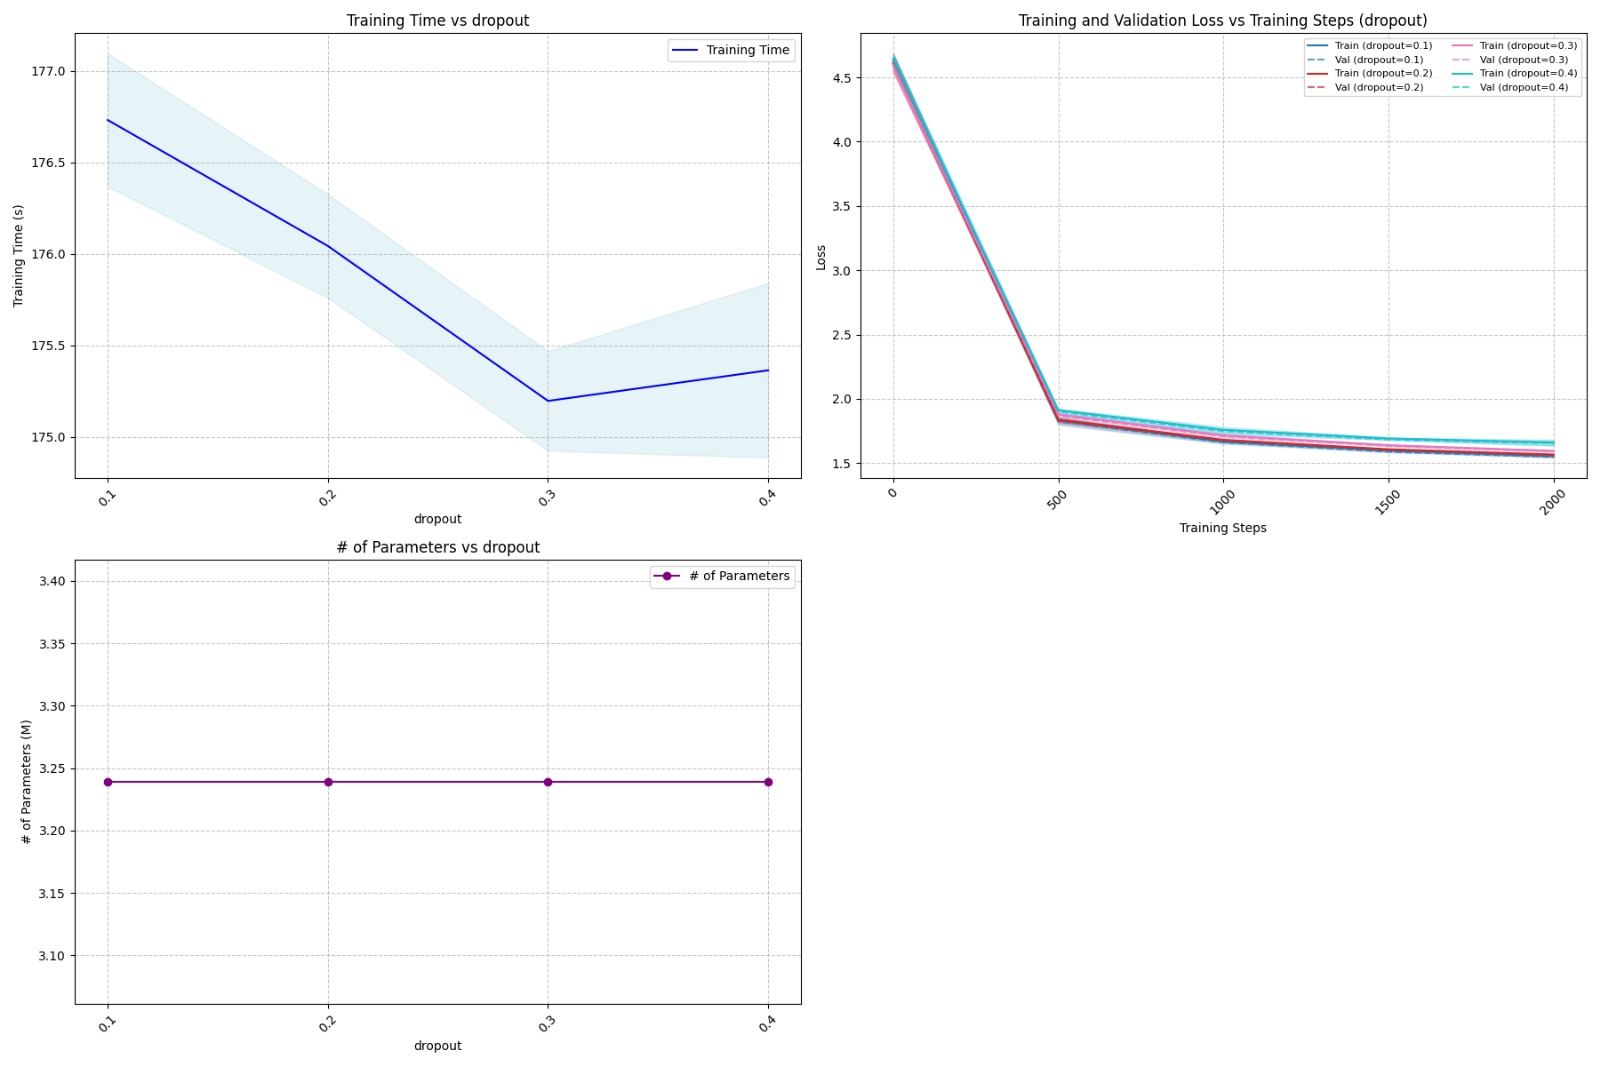

#### Considerations:
- **Training time**: it decreases slightly with increasing dropout to 0.3, but stabilizes at dropout = 0.4. This is an expected behaviour, since higher dropout values imply that a larger fraction of neurons are ignored during the forward pass. This reduces the effective number of computations, making training slightly faster. However, training time is not significantly different for the four configurations, hence the noticeably larger confidence intervals with respect to other plots seen before.
- **Training and validation loss**: the loss is impacted by the dropout as expected, since while a higher parameter value helps reducing overfitting risk, it also mitigates the learning capabilities of the model.
- **Number of parameters**: this value was not impacted at all by the dropout rate, since it has nothing to do with the model structure, but it only plays a role in the learning process.

In conclusion, lower dropout values are to prefer because they balance the trade-off between training time and loss, with the best dropout rate being 0.1, considering the negligible training time difference with respect to the other cases.

### Learning rate analysis

In [143]:
del xb, yb, int_to_syllable
gc.collect()
torch.cuda.empty_cache()

Step 0/100: LR=1.0e-04, Train Loss=2.6359, Val Loss=2.6290
Step 10/100: LR=2.0e-04, Train Loss=2.0393, Val Loss=2.0390
Step 20/100: LR=4.0e-04, Train Loss=1.7572, Val Loss=1.7415
Step 30/100: LR=8.1e-04, Train Loss=1.6446, Val Loss=1.6224
Step 40/100: LR=1.6e-03, Train Loss=1.5902, Val Loss=1.5679
Step 50/100: LR=3.3e-03, Train Loss=1.5876, Val Loss=1.5646
Step 60/100: LR=6.6e-03, Train Loss=1.6079, Val Loss=1.5817
Step 70/100: LR=1.3e-02, Train Loss=1.5976, Val Loss=1.5716
Step 80/100: LR=2.7e-02, Train Loss=1.9277, Val Loss=1.9125
Step 90/100: LR=5.3e-02, Train Loss=2.5252, Val Loss=2.5180
Best LR (based on val loss): 2.2e-03


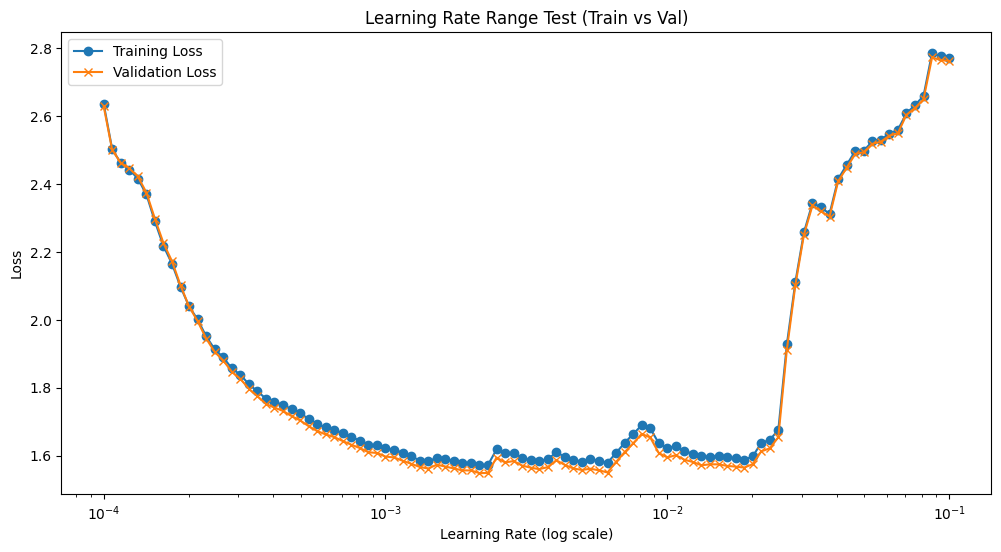

In [144]:
lr_exponents = torch.linspace(-4, -1, steps=100)
learning_rates = 10 ** lr_exponents

batch_size=128
model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=512,
    n_embed=256,
    n_head=4,
    n_layer=4,
    dropout=0.1
).to(device)

eval_iters = 1
learning_rate = lr_analysis(model, torch.optim.AdamW(model.parameters()), 99, 'c', batch_size, 512)
eval_iters = 100

### 5.1.1. "Final" character-processing model

In [145]:
max_iters = 5000
eval_interval = 500
block_size = 512
batch_size = 128
learning_rate = 2.2e-03

In [146]:
del model
torch.cuda.empty_cache()

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=512,
    n_embed=256,
    n_head=4,
    n_layer=4,
    dropout=0.1
).to(device)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters\n')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model, 'c', batch_size, block_size)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train', 'c', batch_size, block_size)

    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

idx = torch.zeros((1,1), dtype=torch.long)
idx = idx.to(device)
print(decode_chars(model.generate(idx, max_new_tokens=1500)[0].tolist()))

3.337313 M parameters

step 0: train loss 4.6275, val loss 4.6281
step 500: train loss 2.0200, val loss 2.0092
step 1000: train loss 1.6489, val loss 1.6441
step 1500: train loss 1.4926, val loss 1.4955
step 2000: train loss 1.4203, val loss 1.4298
step 2500: train loss 1.3758, val loss 1.3971
step 3000: train loss 1.3477, val loss 1.3694
step 3500: train loss 1.3293, val loss 1.3607
step 4000: train loss 1.3114, val loss 1.3442
step 4500: train loss 1.2991, val loss 1.3357
step 4999: train loss 1.2872, val loss 1.3298
	 way,
And Abandon, were I bell to see
How dim is thy sacred eyes are
Reys you with the lully hidal scene;
Precipise, at all, king some night
From ports with thy mixture when you mustered,
Thy portion reposed never replaced
The poiser to avail his weeks and air.The Tan

The blue spains was red
And, as footsteps slept and sea,
And gave a woodbine way,
Deep in that dark void I mean.
The sunset was thine,
That holded through looks and dozed to lists
From dull sleep to gourt

## 5.2 Syllable-processing model

The vocabulary size of the dataset used for the character-processing model would have resulted in a number of parameters not manageable by the environment we are training models in, so we opted to use the Tiny Shakespeare dataset used in the course lectures, as it consists of a much smaller number of unique syllables.

In [21]:
try:
    del poems_dict
    del model
    del m
except NameError:
    pass

We will use the "Tiny Shakespeare" dataset by Karpathy from now on:

In [22]:
try:
    del data_s
except:
    pass

!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    data_s = f.read()

--2025-01-19 16:32:14--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2025-01-19 16:32:14 (30.5 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [23]:
syllables = syllabify(data_s)

unique_syllables = sorted(list(set(syllables)))
unique_syllables.append('[UNK]')

print(' '.join(random.sample(unique_syllables, 100)))
print(f'\n{len(unique_syllables)}')

try:
    del syllables, unique_syllables
except:
    pass

sions Lad Ba tswain cers boas bals Phi trons Intend stopp tsi parks Groan reec haught Boils Bless High arn beth meth roc Bea pliant VAUGHAN tient smem temp pard hans aunts ing real chea Acqua vings Send taunts hawks dry chats Saint af wai drenc Insult Hell fraught Hus fees dus rooms bun Cla trains kets nymphs Mor fowl From pers coign shi scroll fetch pulc Unapt teus Fair Com spied bearts what cloth GAUNT bey Inhe fray che join shy filth Shrug fling fasts Wo stark bwebs tend stur slut Feed ruth shrunk Stamp nue traf board Sil

6508


In [24]:
unique_lc_syllables = sorted(list(set(syllabify_lowercase_and_digits(data_s))))
unique_lc_syllables.append('[UNK]')

print(' '.join(random.sample(unique_lc_syllables, 100)))
print(f'\n{len(unique_lc_syllables)}')

span purgh latc vail heapt new buz hings blue mur rior lan chan guish vol much hah tai reth songs end kon earls irks verbs trew kni win shaft wiel rigg plif healths dy tewks sways cream bring der fend flask searc xion cent quor que xford spots tock jol twiths ban digg trea lain ou dful lynn shou fins smen ai kno tals full teor debt masks goes pro fleer trick tomb & yo neu sub bend diacs plots mis hrew calls hue vols clock cool stro chi toss dow dreamt ste turb flui krupt tner see ha trial

4937


In [25]:
syllable_to_int = {sy:i for i, sy in enumerate(unique_lc_syllables)}
int_to_syllable = {i:sy for i, sy in enumerate(unique_lc_syllables)}

In [26]:
data_s = torch.tensor(encode_syllables(data_s), dtype=torch.long)

In [27]:
vocab_size = len(unique_lc_syllables) # for the sllables-processing model

### Impact of `block_size`

In [ ]:
block_sizes = [16, 32, 64, 128]
results_block_size = test_parameter_variation('block_size', block_sizes, 0, 64, vocab_size, 512,
                                              4, 2, 0.2, 500, 2000, 1e-3, 3, 's')
plot_results(results_block_size, 'block_size', 'block_size_s.png')

```
Testing block_size=16...
Run 1 of 3:
Train loss: 8.673547744750977, Val loss: 8.679632186889648
Train loss: 3.0495877265930176, Val loss: 3.493281841278076
Train loss: 2.9022443294525146, Val loss: 3.4418530464172363
Train loss: 2.843933343887329, Val loss: 3.4181249141693115
Train loss: 2.760685443878174, Val loss: 3.384115219116211
Run 2 of 3:
Train loss: 8.483582496643066, Val loss: 8.48672866821289
Train loss: 3.0710580348968506, Val loss: 3.4926297664642334
Train loss: 2.9526114463806152, Val loss: 3.452510118484497
Train loss: 2.867629289627075, Val loss: 3.394291639328003
Train loss: 2.8289904594421387, Val loss: 3.4085986614227295
Run 3 of 3:
Train loss: 8.447371482849121, Val loss: 8.455853462219238
Train loss: 3.063894748687744, Val loss: 3.504282236099243
Train loss: 2.93812894821167, Val loss: 3.445497512817383
Train loss: 2.853879451751709, Val loss: 3.418161630630493
Train loss: 2.813364028930664, Val loss: 3.398207902908325
Aggregated results for block_size=16:
Final train loss (mean ± std): 2.8010 ± 0.0358
Final val loss (mean ± std): 3.3970 ± 0.0123
Time (mean ± std): 37.30s ± 0.01s
# of parameters: 11.37M

Testing block_size=32...
Run 1 of 3:
Train loss: 8.564559936523438, Val loss: 8.568750381469727
Train loss: 2.7779664993286133, Val loss: 3.3430774211883545
Train loss: 2.5767621994018555, Val loss: 3.235379695892334
Train loss: 2.4809741973876953, Val loss: 3.2199912071228027
Train loss: 2.4223477840423584, Val loss: 3.22145938873291
Run 2 of 3:
Train loss: 8.55999755859375, Val loss: 8.56750202178955
Train loss: 2.8127639293670654, Val loss: 3.3417205810546875
Train loss: 2.6085081100463867, Val loss: 3.231691837310791
Train loss: 2.5291826725006104, Val loss: 3.2442739009857178
Train loss: 2.4786951541900635, Val loss: 3.237642288208008
Run 3 of 3:
Train loss: 8.560483932495117, Val loss: 8.56375503540039
Train loss: 2.8820061683654785, Val loss: 3.3784539699554443
Train loss: 2.6419053077697754, Val loss: 3.294895887374878
Train loss: 2.533796787261963, Val loss: 3.2482547760009766
Train loss: 2.471848249435425, Val loss: 3.2573091983795166
Aggregated results for block_size=32:
Final train loss (mean ± std): 2.4576 ± 0.0307
Final val loss (mean ± std): 3.2388 ± 0.0180
Time (mean ± std): 57.95s ± 0.11s
# of parameters: 11.38M

Testing block_size=64...
Run 1 of 3:
Train loss: 8.6771240234375, Val loss: 8.666367530822754
Train loss: 2.5918567180633545, Val loss: 3.200721502304077
Train loss: 2.3144261837005615, Val loss: 3.1426496505737305
Train loss: 2.128298759460449, Val loss: 3.1594464778900146
Train loss: 1.9562748670578003, Val loss: 3.2524051666259766
Run 2 of 3:
Train loss: 8.471576690673828, Val loss: 8.47375774383545
Train loss: 2.6328508853912354, Val loss: 3.242326259613037
Train loss: 2.346273422241211, Val loss: 3.1746323108673096
Train loss: 2.1698925495147705, Val loss: 3.201033353805542
Train loss: 2.003861427307129, Val loss: 3.2639167308807373
Run 3 of 3:
Train loss: 8.357466697692871, Val loss: 8.367040634155273
Train loss: 2.586346387863159, Val loss: 3.2011566162109375
Train loss: 2.321702003479004, Val loss: 3.1475114822387695
Train loss: 2.1258301734924316, Val loss: 3.1847705841064453
Train loss: 1.956444263458252, Val loss: 3.2571628093719482
Aggregated results for block_size=64:
Final train loss (mean ± std): 1.9722 ± 0.0274
Final val loss (mean ± std): 3.2578 ± 0.0058
Time (mean ± std): 104.43s ± 0.02s
# of parameters: 11.40M

Testing block_size=128...
Run 1 of 3:
Train loss: 8.693633079528809, Val loss: 8.697256088256836
Train loss: 2.4810945987701416, Val loss: 3.1758735179901123
Train loss: 2.078622817993164, Val loss: 3.1901845932006836
Train loss: 1.7408339977264404, Val loss: 3.3527185916900635
Train loss: 1.3809332847595215, Val loss: 3.6709678173065186
Run 2 of 3:
Train loss: 8.743642807006836, Val loss: 8.749256134033203
Train loss: 2.5497817993164062, Val loss: 3.2072463035583496
Train loss: 2.109675168991089, Val loss: 3.1644294261932373
Train loss: 1.725069284439087, Val loss: 3.355424404144287
Train loss: 1.3429286479949951, Val loss: 3.6898105144500732
Run 3 of 3:
Train loss: 8.572663307189941, Val loss: 8.567938804626465
Train loss: 2.469337224960327, Val loss: 3.15933895111084
Train loss: 2.0347774028778076, Val loss: 3.195672035217285
Train loss: 1.660955786705017, Val loss: 3.4055874347686768
Train loss: 1.2834267616271973, Val loss: 3.723691940307617
Aggregated results for block_size=128:
Final train loss (mean ± std): 1.3358 ± 0.0491
Final val loss (mean ± std): 3.6948 ± 0.0267
Time (mean ± std): 191.81s ± 0.08s
# of parameters: 11.43M
```

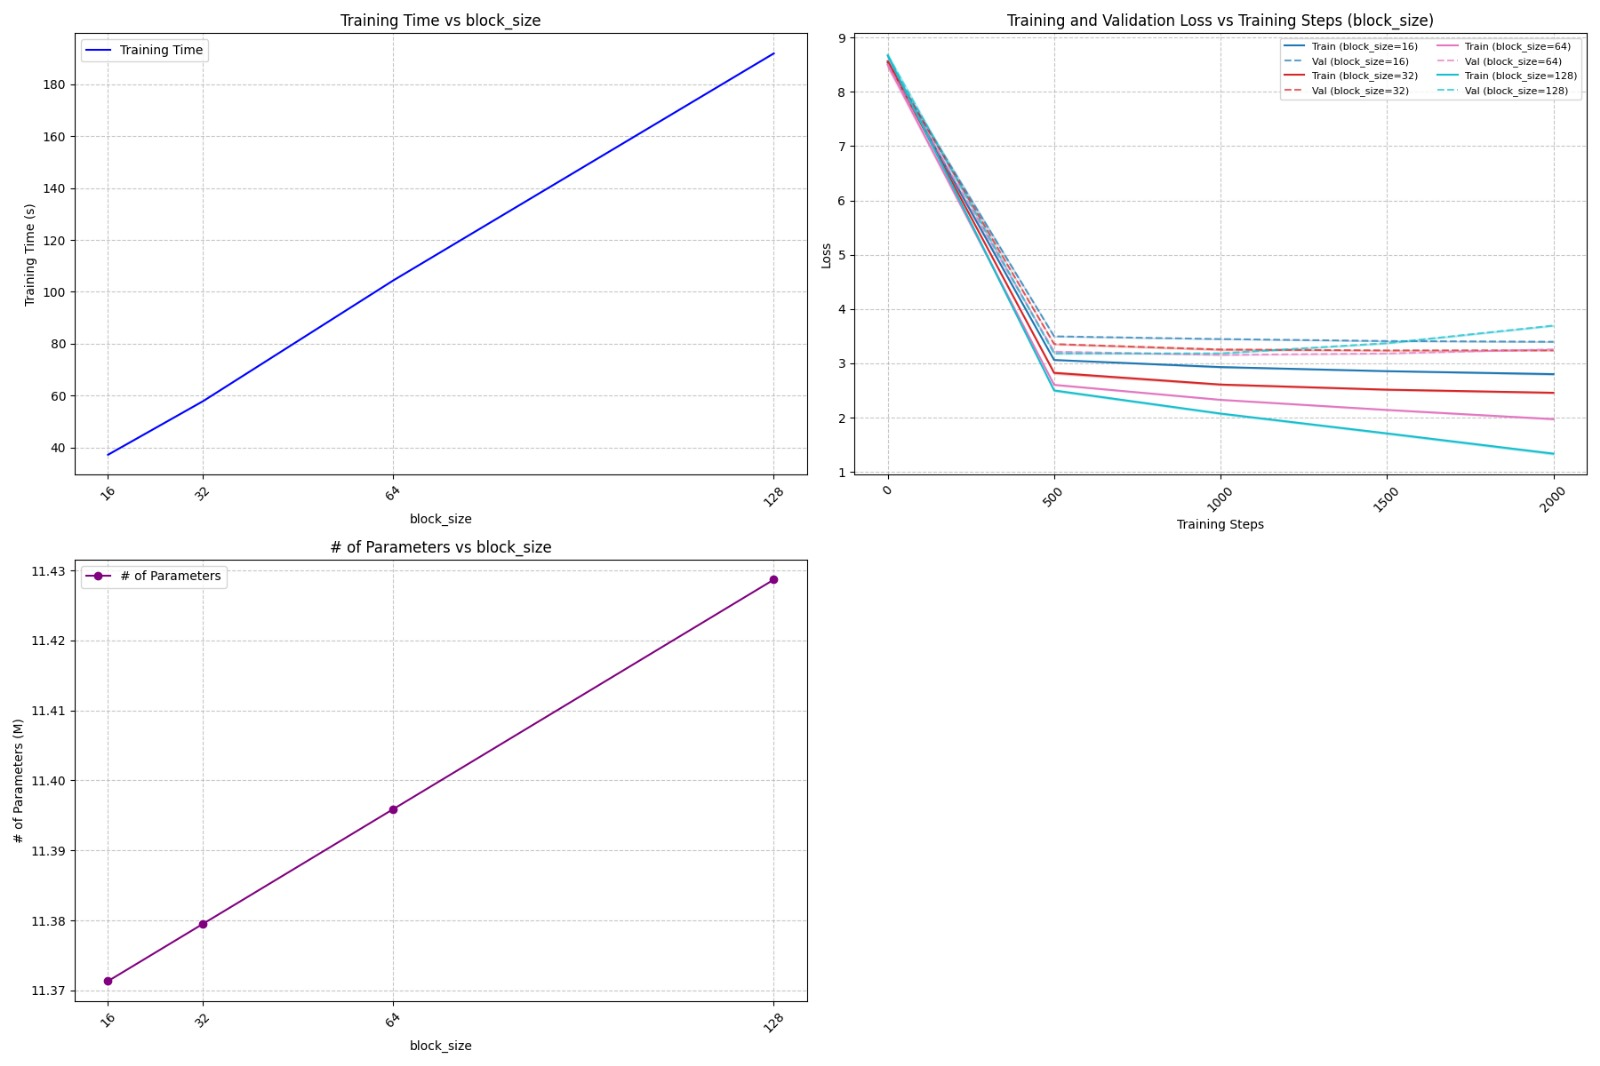
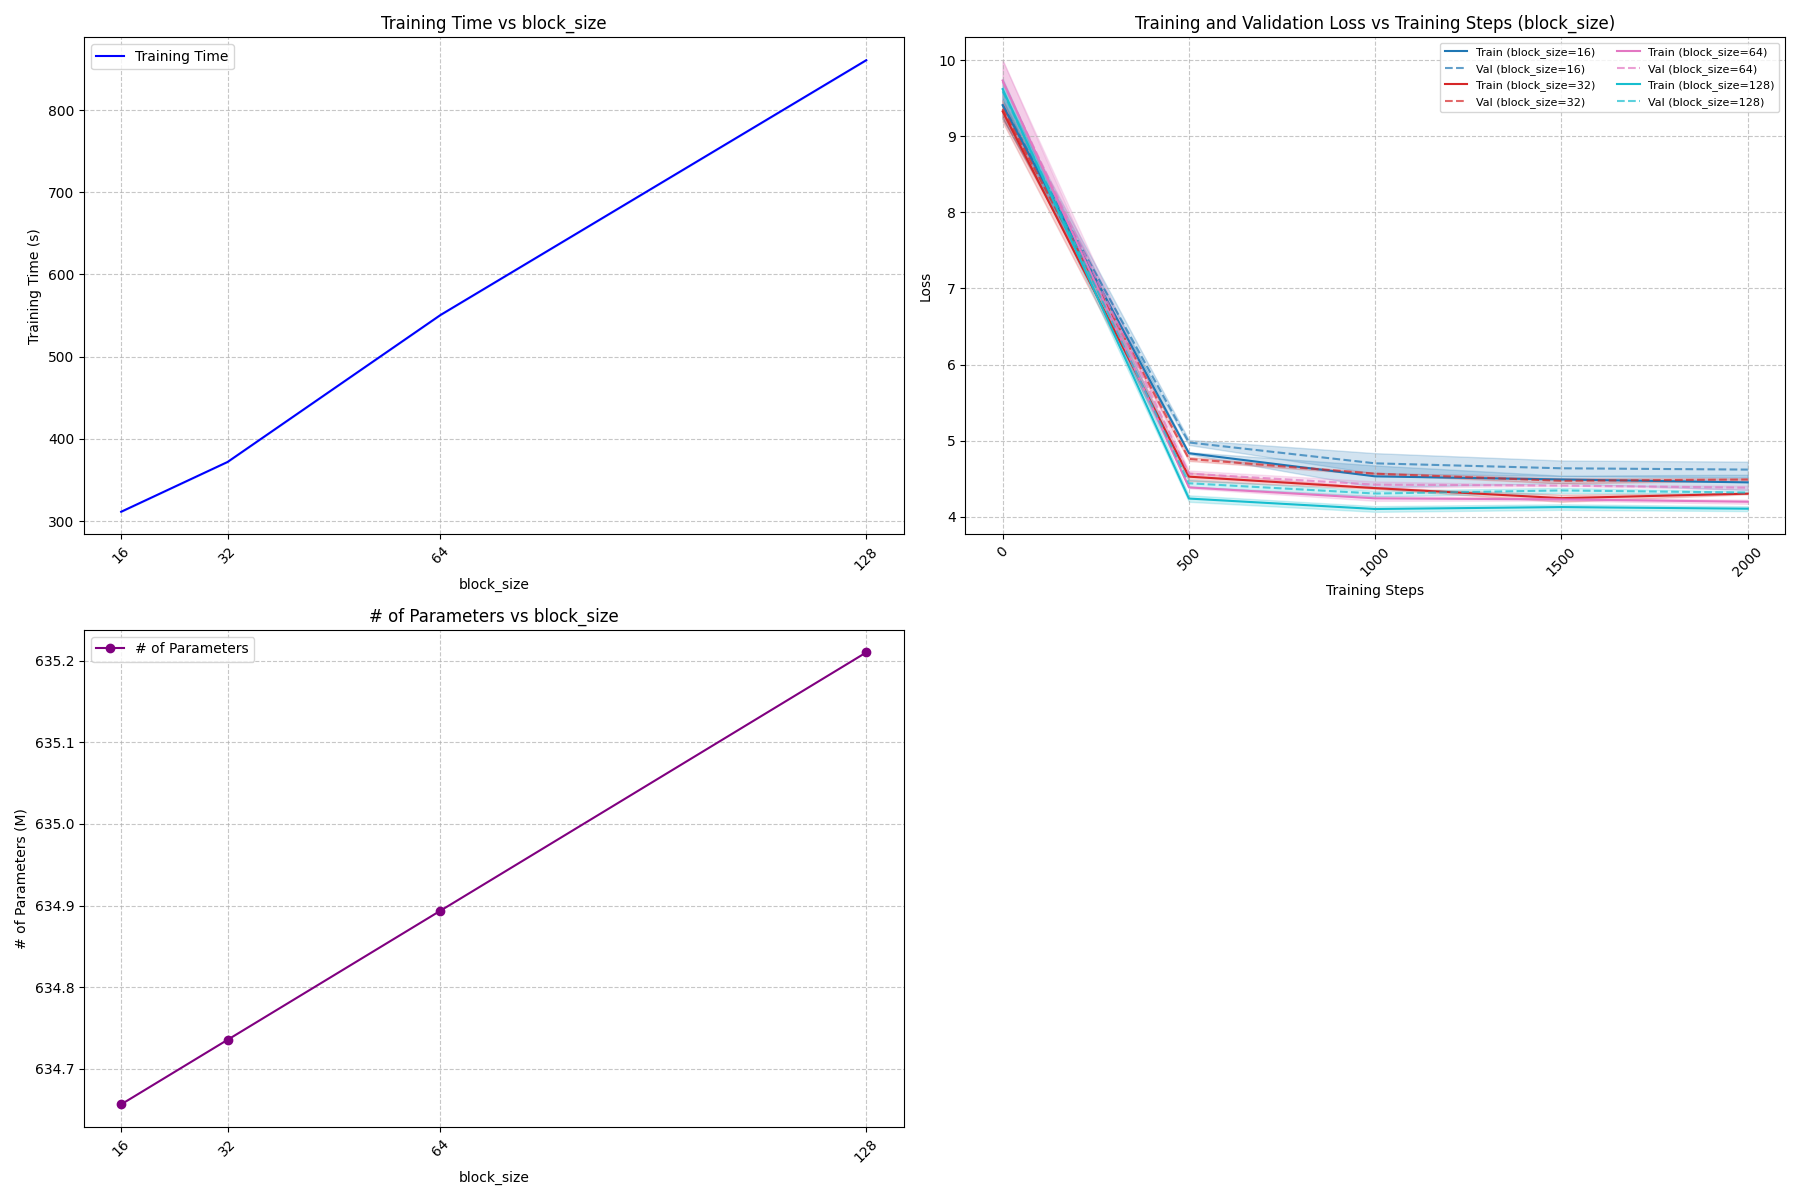

#### Considerations:
- **Training time**: the training time increases as the block size does, but less than at the same rate, because doubling the block size does not result in the double of the previous training time. This result was expected as for the character-processing model, since the block size has a direct impact on the number of parameters and thus on the computations to be performed.
- **Training and validation loss**: the block size has a significant impact on the model loss, with the model having the larger block size reaching again the lowest loss. While a larger block size corresponds to a lower training loss, it is clear that it also corresponds to a larger validation loss. In particular, the validaiton loss seems to stabilize for the models with block size 16 and 32, while it starts to increase after 1000 epochs for the models with a greater block size, suggesting that a large "context" window may be not helpful for this model, or that it could even mean the risk of overfitting.
- **Number of parameters**: it grows linearly with the block size and this result was expected, since the block size is involved in shaping many elements of the network's structure.

In conclusion, we can say that the best block size for this scenario is 32, since it represents the best trade-off between training time and loss after 2000 epochs

### Impact of `batch_size`

In [ ]:
batch_sizes = [16, 32, 64, 128]
results_batch_size = test_parameter_variation('batch_size', batch_sizes, 128, 0, vocab_size, 512,
                                              4, 2, 0.2, 500, 2000, 1e-3, 3, 's')
plot_results(results_batch_size, 'batch_size', 'batch_size_s.png')

```
Testing batch_size=16...
Run 1 of 3:
Train loss: 8.783803939819336, Val loss: 8.778690338134766
Train loss: 2.8634650707244873, Val loss: 3.3420653343200684
Train loss: 2.599879741668701, Val loss: 3.2176544666290283
Train loss: 2.4855735301971436, Val loss: 3.1750333309173584
Train loss: 2.399567127227783, Val loss: 3.1909008026123047
Run 2 of 3:
Train loss: 8.764826774597168, Val loss: 8.752549171447754
Train loss: 2.9410712718963623, Val loss: 3.3927111625671387
Train loss: 2.6398673057556152, Val loss: 3.2530407905578613
Train loss: 2.53625750541687, Val loss: 3.2253119945526123
Train loss: 2.433095932006836, Val loss: 3.2314441204071045
Run 3 of 3:
Train loss: 8.594849586486816, Val loss: 8.598174095153809
Train loss: 3.0077197551727295, Val loss: 3.4618043899536133
Train loss: 2.672689199447632, Val loss: 3.327634811401367
Train loss: 2.55965518951416, Val loss: 3.2568047046661377
Train loss: 2.513098955154419, Val loss: 3.26533579826355
Aggregated results for batch_size=16:
Final train loss (mean ± std): 2.4486 ± 0.0583
Final val loss (mean ± std): 3.2292 ± 0.0373
Time (mean ± std): 57.05s ± 0.08s
# of parameters: 11.43M

Testing batch_size=32...
Run 1 of 3:
Train loss: 8.8499116897583, Val loss: 8.83665657043457
Train loss: 2.712622880935669, Val loss: 3.2855443954467773
Train loss: 2.433636426925659, Val loss: 3.218785285949707
Train loss: 2.286008358001709, Val loss: 3.189190149307251
Train loss: 2.1442465782165527, Val loss: 3.2244250774383545
Run 2 of 3:
Train loss: 8.590190887451172, Val loss: 8.599205017089844
Train loss: 2.7570688724517822, Val loss: 3.338458299636841
Train loss: 2.4473559856414795, Val loss: 3.224036931991577
Train loss: 2.300088882446289, Val loss: 3.210153579711914
Train loss: 2.153109312057495, Val loss: 3.2353298664093018
Run 3 of 3:
Train loss: 8.560556411743164, Val loss: 8.550853729248047
Train loss: 2.6867282390594482, Val loss: 3.2517900466918945
Train loss: 2.4184272289276123, Val loss: 3.1726434230804443
Train loss: 2.2567954063415527, Val loss: 3.1810271739959717
Train loss: 2.1059725284576416, Val loss: 3.2042181491851807
Aggregated results for batch_size=32:
Final train loss (mean ± std): 2.1344 ± 0.0251
Final val loss (mean ± std): 3.2213 ± 0.0158
Time (mean ± std): 105.11s ± 0.11s
# of parameters: 11.43M

Testing batch_size=64...
Run 1 of 3:
Train loss: 8.482865333557129, Val loss: 8.481886863708496
Train loss: 2.5033316612243652, Val loss: 3.1511945724487305
Train loss: 2.0845181941986084, Val loss: 3.1828293800354004
Train loss: 1.7068371772766113, Val loss: 3.3594210147857666
Train loss: 1.3256527185440063, Val loss: 3.7034800052642822
Run 2 of 3:
Train loss: 8.651634216308594, Val loss: 8.644576072692871
Train loss: 2.550945281982422, Val loss: 3.221701145172119
Train loss: 2.1180999279022217, Val loss: 3.1968300342559814
Train loss: 1.7441166639328003, Val loss: 3.377831220626831
Train loss: 1.3519024848937988, Val loss: 3.6439321041107178
Run 3 of 3:
Train loss: 8.709087371826172, Val loss: 8.704262733459473
Train loss: 2.531287908554077, Val loss: 3.2150397300720215
Train loss: 2.1046676635742188, Val loss: 3.182523727416992
Train loss: 1.7459646463394165, Val loss: 3.3478875160217285
Train loss: 1.378623366355896, Val loss: 3.670090436935425
Aggregated results for batch_size=64:
Final train loss (mean ± std): 1.3521 ± 0.0265
Final val loss (mean ± std): 3.6725 ± 0.0298
Time (mean ± std): 190.78s ± 0.19s
# of parameters: 11.43M

Testing batch_size=128...
Run 1 of 3:
Train loss: 8.648606300354004, Val loss: 8.649916648864746
Train loss: 2.221517562866211, Val loss: 3.121173143386841
Train loss: 1.500613808631897, Val loss: 3.4492101669311523
Train loss: 0.8397393226623535, Val loss: 4.181807041168213
Train loss: 0.45801249146461487, Val loss: 4.881223678588867
Run 2 of 3:
Train loss: 8.376806259155273, Val loss: 8.38996696472168
Train loss: 2.319378614425659, Val loss: 3.1483752727508545
Train loss: 1.607393741607666, Val loss: 3.4582178592681885
Train loss: 0.9097030758857727, Val loss: 4.07864236831665
Train loss: 0.4890795946121216, Val loss: 4.826543807983398
Run 3 of 3:
Train loss: 8.726912498474121, Val loss: 8.727914810180664
Train loss: 2.3373632431030273, Val loss: 3.1345245838165283
Train loss: 1.6264500617980957, Val loss: 3.368237257003784
Train loss: 0.9396861791610718, Val loss: 4.040523529052734
Train loss: 0.4940144419670105, Val loss: 4.756389141082764
Aggregated results for batch_size=128:
Final train loss (mean ± std): 0.4804 ± 0.0195
Final val loss (mean ± std): 4.8214 ± 0.0626
Time (mean ± std): 366.72s ± 0.10s
# of parameters: 11.43M
```

![](https://raw.githubusercontent.com/martinasp00/MIRCV-Project/bd4ddd77964d16e820ca1152e8de53c41ccf5ebf/images/batch_size_s.png)
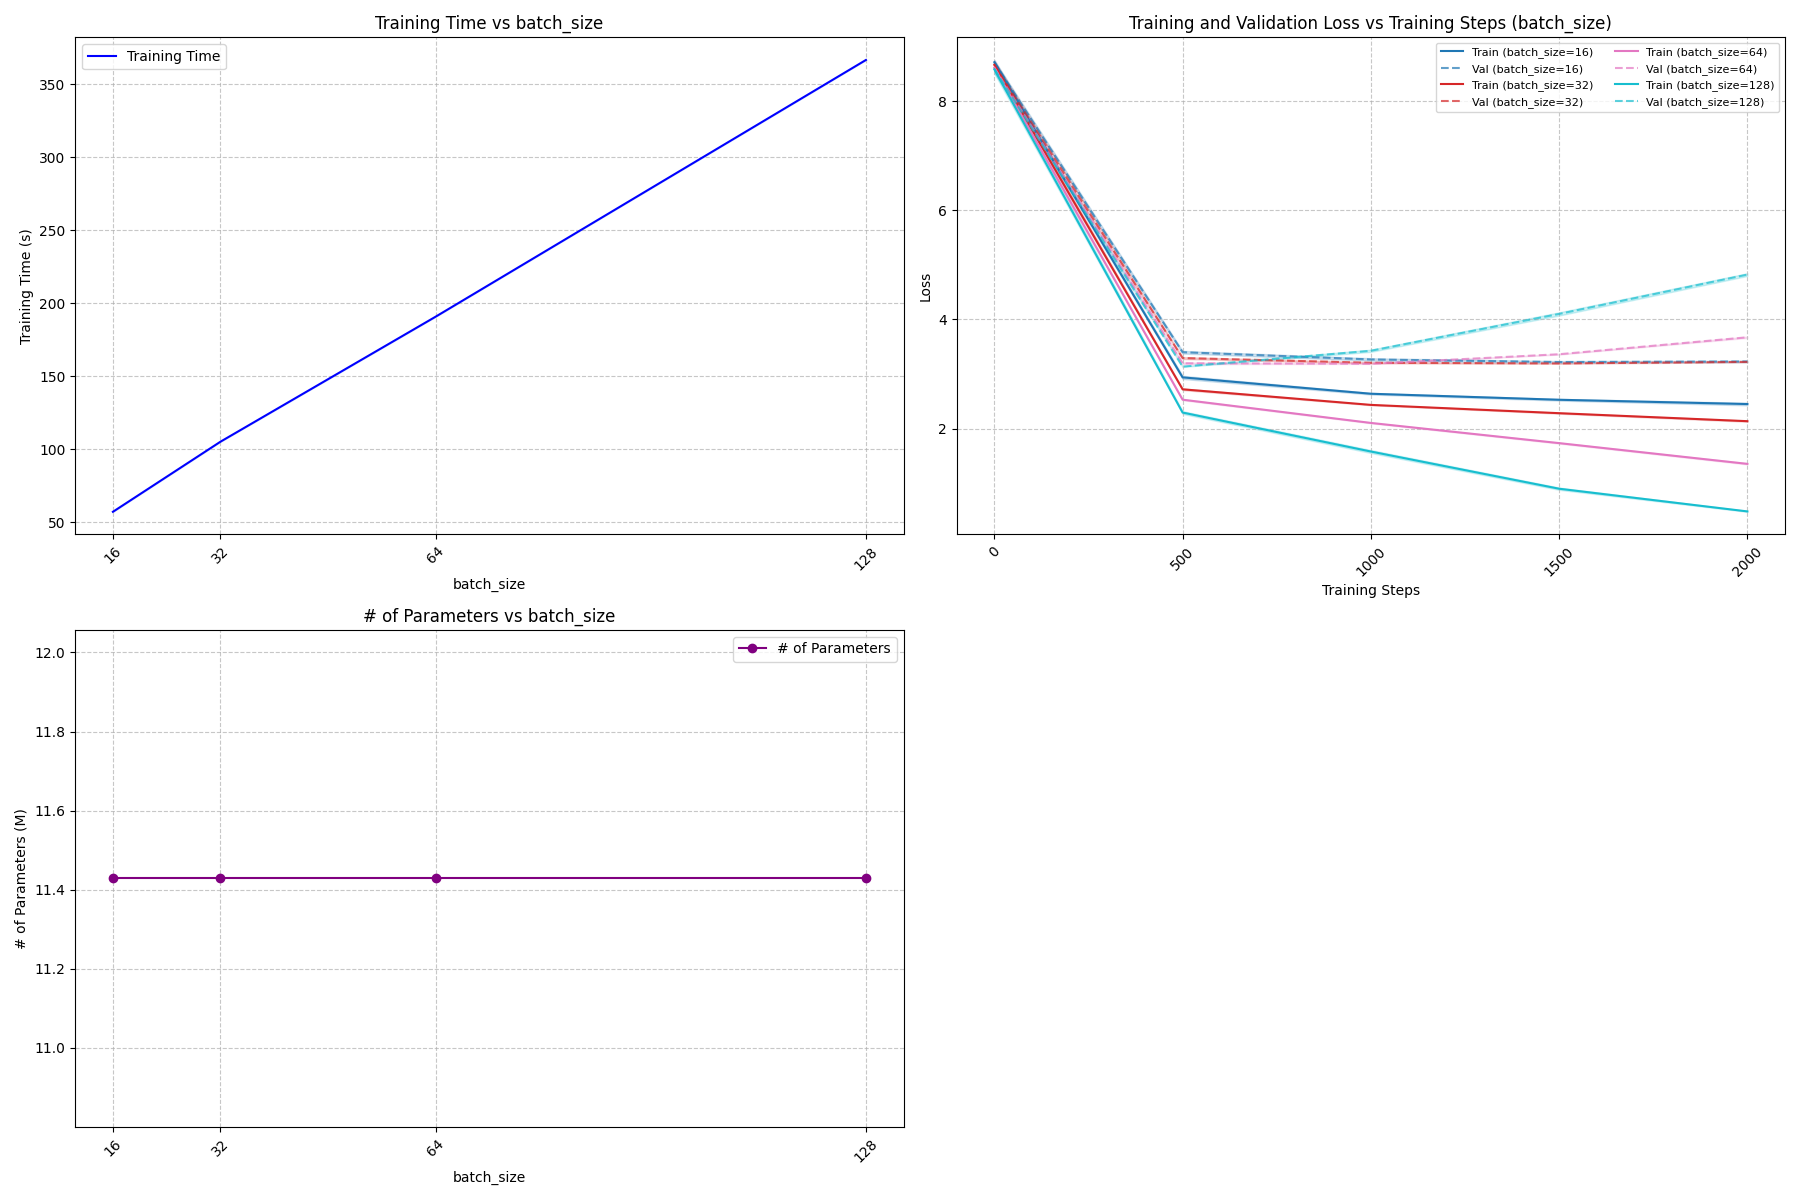

#### Considerations:
- **Training time**: the training time seems to increase linearly with the batch size. This result was expected, since a greater batch size means a heavier computation load for the model.
- **Training and validation loss**: the batch size has a noticeable impact on the model loss, with a greater batch size resulting in a lower training loss after 2000 epochs. It is also worth noticing that the difference between training and validation loss tends to widen as the batch size increases, suggesting a risk of overfitting. This can be attributed to the very small size of the dataset (~1MB) and thus of the vocabulary size, that exposes models to a higher risk of overfitting with respect to larger datasets, with a more varied composition.
- **Number of parameters**: it is obviously not influenced by the batch size, since this parameter only affects the dimension of the token batches fed to the network in input, but not the network's structure itself.

In conclusion, we can say that the best batch size for this scenario is 32, since it represents the best trade-off between training time and loss after 2000 epochs, but the other values may be used to reduce the gap between training and validation loss (that is also impacted by other parameters, as we will see in the next tests). In the evaluation of this value, the reasons of the difference between training and validation loss were taken into account.

### Impact of `n_layer`

In [ ]:
n_layers = [2, 4, 6]
results_n_layer = test_parameter_variation('n_layer', n_layers, 128, 64, vocab_size, 512,
                                           4, 0, 0.2, 500, 2000, 1e-3, 3, 's')
plot_results(results_n_layer, 'n_layer', 'n_layer_s.png')

```
Testing n_layer=2...
Run 1 of 3:
Train loss: 8.453397750854492, Val loss: 8.459973335266113
Train loss: 2.5029547214508057, Val loss: 3.1636879444122314
Train loss: 2.0610923767089844, Val loss: 3.1459219455718994
Train loss: 1.6614667177200317, Val loss: 3.3770291805267334
Train loss: 1.289740800857544, Val loss: 3.7225112915039062
Run 2 of 3:
Train loss: 8.718520164489746, Val loss: 8.727790832519531
Train loss: 2.514495611190796, Val loss: 3.1849353313446045
Train loss: 2.100775957107544, Val loss: 3.2006914615631104
Train loss: 1.75187087059021, Val loss: 3.3807644844055176
Train loss: 1.3834477663040161, Val loss: 3.6746249198913574
Run 3 of 3:
Train loss: 8.607229232788086, Val loss: 8.601776123046875
Train loss: 2.4870190620422363, Val loss: 3.166982650756836
Train loss: 2.0842630863189697, Val loss: 3.181277275085449
Train loss: 1.7198406457901, Val loss: 3.35847544670105
Train loss: 1.3279979228973389, Val loss: 3.6203057765960693
Aggregated results for n_layer=2:
Final train loss (mean ± std): 1.3337 ± 0.0471
Final val loss (mean ± std): 3.6725 ± 0.0511
Time (mean ± std): 191.52s ± 0.31s
# of parameters: 11.43M

Testing n_layer=4...
Run 1 of 3:
Train loss: 8.871927261352539, Val loss: 8.870674133300781
Train loss: 2.5822811126708984, Val loss: 3.198777198791504
Train loss: 2.194215774536133, Val loss: 3.155956745147705
Train loss: 1.8440032005310059, Val loss: 3.2785444259643555
Train loss: 1.4403793811798096, Val loss: 3.520705223083496
Run 2 of 3:
Train loss: 8.723941802978516, Val loss: 8.732474327087402
Train loss: 2.5376625061035156, Val loss: 3.1819570064544678
Train loss: 2.141977071762085, Val loss: 3.1108553409576416
Train loss: 1.7550143003463745, Val loss: 3.2666378021240234
Train loss: 1.310051441192627, Val loss: 3.5502703189849854
Run 3 of 3:
Train loss: 8.565157890319824, Val loss: 8.562747955322266
Train loss: 2.6024115085601807, Val loss: 3.2481884956359863
Train loss: 2.228151321411133, Val loss: 3.1939449310302734
Train loss: 1.9202858209609985, Val loss: 3.2880425453186035
Train loss: 1.5481839179992676, Val loss: 3.4677724838256836
Aggregated results for n_layer=4:
Final train loss (mean ± std): 1.4329 ± 0.1192
Final val loss (mean ± std): 3.5129 ± 0.0418
Time (mean ± std): 326.46s ± 0.14s
# of parameters: 17.73M

Testing n_layer=6...
Run 1 of 3:
Train loss: 8.753959655761719, Val loss: 8.753340721130371
Train loss: 2.693648338317871, Val loss: 3.3013360500335693
Train loss: 2.5007452964782715, Val loss: 3.2477245330810547
Train loss: 2.7422211170196533, Val loss: 3.4022817611694336
Train loss: 2.6767218112945557, Val loss: 3.364245653152466
Run 2 of 3:
Train loss: 8.414373397827148, Val loss: 8.427032470703125
Train loss: 2.71199107170105, Val loss: 3.2686219215393066
Train loss: 2.470602035522461, Val loss: 3.20733642578125
Train loss: 2.8584587574005127, Val loss: 3.4631829261779785
Train loss: 3.0575177669525146, Val loss: 3.580125093460083
Run 3 of 3:
Train loss: 8.717184066772461, Val loss: 8.70966911315918
Train loss: 2.642282009124756, Val loss: 3.248732566833496
Train loss: 2.3094916343688965, Val loss: 3.1778502464294434
Train loss: 2.1119093894958496, Val loss: 3.215606927871704
Train loss: 1.8807001113891602, Val loss: 3.3280997276306152
Aggregated results for n_layer=6:
Final train loss (mean ± std): 2.5383 ± 0.6005
Final val loss (mean ± std): 3.4242 ± 0.1363
Time (mean ± std): 458.59s ± 0.16s
# of parameters: 24.03M

Testing n_layer=8...
Run 1 of 3:
Train loss: 8.715871810913086, Val loss: 8.712689399719238
Train loss: 2.758803129196167, Val loss: 3.3277900218963623
Train loss: 2.4689764976501465, Val loss: 3.2105114459991455
Train loss: 2.7315587997436523, Val loss: 3.403017044067383
Train loss: 3.1130294799804688, Val loss: 3.611593008041382
Run 2 of 3:
Train loss: 8.492027282714844, Val loss: 8.502686500549316
Train loss: 2.7149417400360107, Val loss: 3.3044955730438232
Train loss: 2.640007734298706, Val loss: 3.324218511581421
Train loss: 3.3214404582977295, Val loss: 3.7454543113708496
Train loss: 3.335097074508667, Val loss: 3.763659954071045
Run 3 of 3:
Train loss: 8.470515251159668, Val loss: 8.46406364440918
Train loss: 2.6816043853759766, Val loss: 3.263767719268799
Train loss: 2.728405475616455, Val loss: 3.3705458641052246
Train loss: 3.098551034927368, Val loss: 3.6088738441467285
Train loss: 3.0981273651123047, Val loss: 3.589682102203369
Aggregated results for n_layer=8:
Final train loss (mean ± std): 3.1821 ± 0.1327
Final val loss (mean ± std): 3.6550 ± 0.0948
Time (mean ± std): 591.55s ± 0.25s
# of parameters: 30.33M
```

![](https://raw.githubusercontent.com/martinasp00/MIRCV-Project/bd4ddd77964d16e820ca1152e8de53c41ccf5ebf/images/n_layer_s.jpeg)
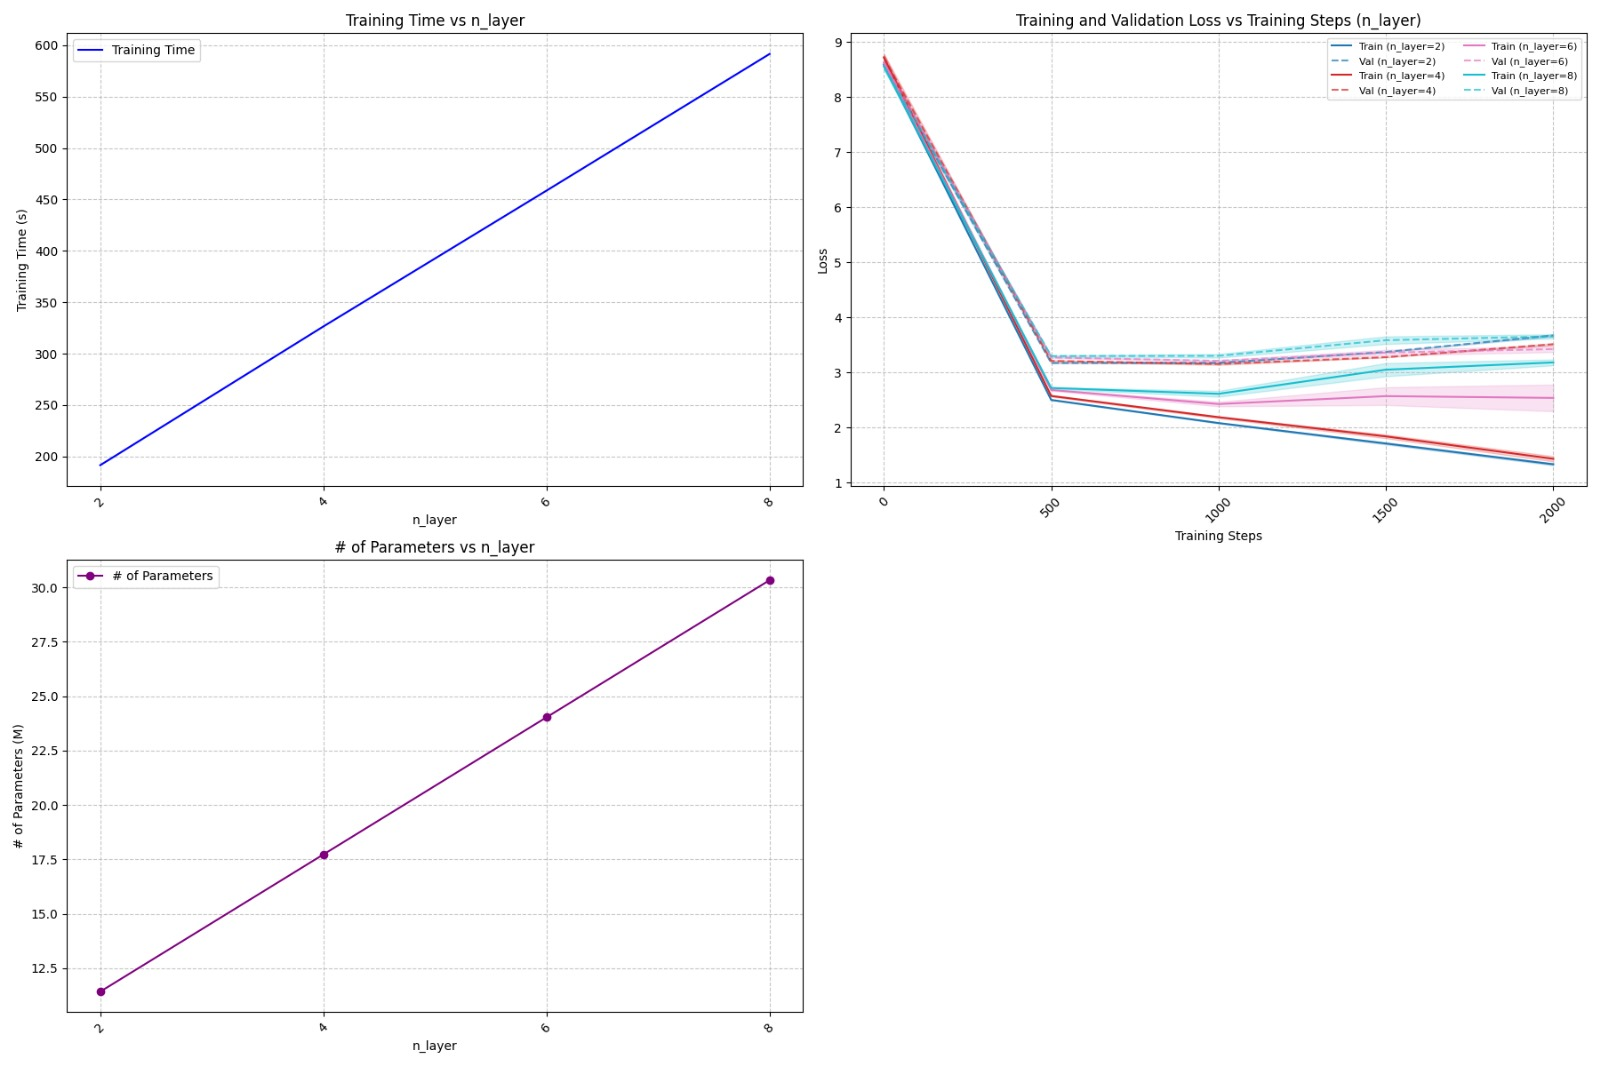

#### Considerations:
- **Training time**: the training time seems to increase almost at the same rate as the n_layer parameter. This result was expected, for the reasons stated in same test done for the character-processing model.
- **Training and validation loss**: the number of layers this time has a noticeable impact on the model loss. This is due to the fact that in general, multiple layers should be useful to detect more complex representations of the data, however this does not seem true for this scenario: adding layers makes both losses increase, with a surprisingly large gap between the loss achieved by the models with 2 and 4 layers with respect to the loss reached by the other two models. It is worth noticing that all four models have a similar validation loss, and that the training loss of the models with 6 and 8 layers oddly starts to increase after 1000 epochs, suggesting that in this case there is no advantage from using more than 4 layers.
- **Number of parameters**: it is obviously influenced by the number of layers, since at each new configuration we are adding blocks to the network, greatly increasing its number of parameters.

In conclusion, we can say that as for the character-processing model) any number of layers over 4 may be not useful unless we increase the number of embeddings and attention heads, but the increase in training time and total parameters may make the additional layers' contribution not worth.

### Impact of `n_head` and `n_embd`

In [ ]:
n_heads = [2, 4, 6]
n_embds = [264, 384, 528]
results_n_head_n_embd = test_n_heads_n_embds(128, 64, vocab_size, n_embds, n_heads, 2, 0.2, 500, 2000, 1e-3, 3, 's')
plot_results_n_head_n_embd(results_n_head_n_embd, 'n_head_n_embd_s.png')

```
Testing n_head=2, n_embd=264...
Run 1 of 3:
Train loss: 8.62905216217041, Val loss: 8.631665229797363
Train loss: 2.4237122535705566, Val loss: 3.1305322647094727
Train loss: 2.0307798385620117, Val loss: 3.18232798576355
Train loss: 1.748212456703186, Val loss: 3.435152053833008
Train loss: 1.477083683013916, Val loss: 3.6660971641540527
Run 2 of 3:
Train loss: 8.432866096496582, Val loss: 8.429967880249023
Train loss: 2.497013807296753, Val loss: 3.1362464427948
Train loss: 2.087801218032837, Val loss: 3.15557861328125
Train loss: 1.790208339691162, Val loss: 3.323615789413452
Train loss: 1.5202407836914062, Val loss: 3.5430407524108887
Run 3 of 3:
Train loss: 8.552072525024414, Val loss: 8.549076080322266
Train loss: 2.7593069076538086, Val loss: 3.2877962589263916
Train loss: 2.286874294281006, Val loss: 3.133282423019409
Train loss: 1.984320044517517, Val loss: 3.1781039237976074
Train loss: 1.7328442335128784, Val loss: 3.3665285110473633
Aggregated results for n_head=2, n_embd=264:
Final train loss (mean ± std): 1.5767 ± 0.1118
Final val loss (mean ± std): 3.5252 ± 0.1229
Time (mean ± std): 97.78s ± 0.01s
# of parameters: 4.32M

Testing n_head=2, n_embd=384...
Run 1 of 3:
Train loss: 8.5798978805542, Val loss: 8.584972381591797
Train loss: 2.604771375656128, Val loss: 3.228437900543213
Train loss: 2.1674420833587646, Val loss: 3.171193838119507
Train loss: 1.8129578828811646, Val loss: 3.330230951309204
Train loss: 1.4867370128631592, Val loss: 3.6310250759124756
Run 2 of 3:
Train loss: 8.665741920471191, Val loss: 8.663069725036621
Train loss: 2.5392587184906006, Val loss: 3.1915395259857178
Train loss: 2.1222476959228516, Val loss: 3.1725597381591797
Train loss: 1.7774450778961182, Val loss: 3.343219041824341
Train loss: 1.4595041275024414, Val loss: 3.6304543018341064
Run 3 of 3:
Train loss: 8.480657577514648, Val loss: 8.486135482788086
Train loss: 2.5625524520874023, Val loss: 3.1917245388031006
Train loss: 2.1505584716796875, Val loss: 3.1513073444366455
Train loss: 1.8328564167022705, Val loss: 3.3280022144317627
Train loss: 1.5129485130310059, Val loss: 3.5715339183807373
Aggregated results for n_head=2, n_embd=384:
Final train loss (mean ± std): 1.4864 ± 0.0218
Final val loss (mean ± std): 3.6110 ± 0.0279
Time (mean ± std): 126.96s ± 0.01s
# of parameters: 7.39M

Testing n_head=2, n_embd=528...
Run 1 of 3:
Train loss: 8.665128707885742, Val loss: 8.6544189453125
Train loss: 2.556748867034912, Val loss: 3.2232666015625
Train loss: 2.168882369995117, Val loss: 3.179455518722534
Train loss: 1.8432824611663818, Val loss: 3.356448173522949
Train loss: 1.483872413635254, Val loss: 3.6225109100341797
Run 2 of 3:
Train loss: 8.676674842834473, Val loss: 8.677253723144531
Train loss: 2.585003614425659, Val loss: 3.239208936691284
Train loss: 2.152966022491455, Val loss: 3.2181363105773926
Train loss: 1.7853293418884277, Val loss: 3.3744025230407715
Train loss: 1.408013105392456, Val loss: 3.6908252239227295
Run 3 of 3:
Train loss: 8.631265640258789, Val loss: 8.632159233093262
Train loss: 2.576063632965088, Val loss: 3.207331895828247
Train loss: 2.1904001235961914, Val loss: 3.1829516887664795
Train loss: 1.832817792892456, Val loss: 3.305710554122925
Train loss: 1.4672503471374512, Val loss: 3.655195713043213
Aggregated results for n_head=2, n_embd=528:
Final train loss (mean ± std): 1.4530 ± 0.0326
Final val loss (mean ± std): 3.6562 ± 0.0279
Time (mean ± std): 200.15s ± 0.02s
# of parameters: 11.99M

Testing n_head=4, n_embd=264...
Run 1 of 3:
Train loss: 8.550414085388184, Val loss: 8.547184944152832
Train loss: 2.440079689025879, Val loss: 3.1036481857299805
Train loss: 2.013556718826294, Val loss: 3.162278652191162
Train loss: 1.711891531944275, Val loss: 3.406562566757202
Train loss: 1.408695936203003, Val loss: 3.672576904296875
Run 2 of 3:
Train loss: 8.571520805358887, Val loss: 8.571089744567871
Train loss: 2.51788330078125, Val loss: 3.143282413482666
Train loss: 2.0990371704101562, Val loss: 3.1532113552093506
Train loss: 1.778590202331543, Val loss: 3.310833692550659
Train loss: 1.4839043617248535, Val loss: 3.5870065689086914
Run 3 of 3:
Train loss: 8.485135078430176, Val loss: 8.489168167114258
Train loss: 2.6007912158966064, Val loss: 3.217282295227051
Train loss: 2.1804046630859375, Val loss: 3.1796658039093018
Train loss: 1.8895188570022583, Val loss: 3.2479352951049805
Train loss: 1.6159504652023315, Val loss: 3.4609479904174805
Aggregated results for n_head=4, n_embd=264:
Final train loss (mean ± std): 1.5029 ± 0.0857
Final val loss (mean ± std): 3.5735 ± 0.0869
Time (mean ± std): 111.85s ± 0.02s
# of parameters: 4.32M

Testing n_head=4, n_embd=384...
Run 1 of 3:
Train loss: 8.634054183959961, Val loss: 8.639534950256348
Train loss: 2.4901506900787354, Val loss: 3.137709617614746
Train loss: 2.0843756198883057, Val loss: 3.135878801345825
Train loss: 1.73879075050354, Val loss: 3.344625949859619
Train loss: 1.4011781215667725, Val loss: 3.6094253063201904
Run 2 of 3:
Train loss: 8.665668487548828, Val loss: 8.669137954711914
Train loss: 2.547210931777954, Val loss: 3.184298038482666
Train loss: 2.1268367767333984, Val loss: 3.1570587158203125
Train loss: 1.7925126552581787, Val loss: 3.3218319416046143
Train loss: 1.4294301271438599, Val loss: 3.5970253944396973
Run 3 of 3:
Train loss: 8.714621543884277, Val loss: 8.714412689208984
Train loss: 2.5347893238067627, Val loss: 3.2015392780303955
Train loss: 2.119076728820801, Val loss: 3.2000763416290283
Train loss: 1.7961593866348267, Val loss: 3.3274600505828857
Train loss: 1.46726655960083, Val loss: 3.6081299781799316
Aggregated results for n_head=4, n_embd=384:
Final train loss (mean ± std): 1.4326 ± 0.0271
Final val loss (mean ± std): 3.6049 ± 0.0056
Time (mean ± std): 136.04s ± 0.01s
# of parameters: 7.39M

Testing n_head=4, n_embd=528...
Run 1 of 3:
Train loss: 8.569526672363281, Val loss: 8.566510200500488
Train loss: 2.482285499572754, Val loss: 3.174431085586548
Train loss: 2.0585885047912598, Val loss: 3.180582284927368
Train loss: 1.6855382919311523, Val loss: 3.367542028427124
Train loss: 1.2744555473327637, Val loss: 3.7192797660827637
Run 2 of 3:
Train loss: 8.670303344726562, Val loss: 8.662489891052246
Train loss: 2.4774086475372314, Val loss: 3.1793735027313232
Train loss: 2.0673418045043945, Val loss: 3.1852567195892334
Train loss: 1.7197778224945068, Val loss: 3.3657054901123047
Train loss: 1.3508844375610352, Val loss: 3.683870315551758
Run 3 of 3:
Train loss: 8.681635856628418, Val loss: 8.68319034576416
Train loss: 2.486567974090576, Val loss: 3.162260055541992
Train loss: 2.0532567501068115, Val loss: 3.1678078174591064
Train loss: 1.6836427450180054, Val loss: 3.372018814086914
Train loss: 1.3025518655776978, Val loss: 3.710392475128174
Aggregated results for n_head=4, n_embd=528:
Final train loss (mean ± std): 1.3093 ± 0.0316
Final val loss (mean ± std): 3.7045 ± 0.0150
Time (mean ± std): 221.70s ± 0.02s
# of parameters: 11.99M

Testing n_head=6, n_embd=264...
Run 1 of 3:
Train loss: 8.577179908752441, Val loss: 8.571457862854004
Train loss: 2.494828224182129, Val loss: 3.1770358085632324
Train loss: 2.0694754123687744, Val loss: 3.16274356842041
Train loss: 1.7388707399368286, Val loss: 3.327784538269043
Train loss: 1.4281353950500488, Val loss: 3.592489004135132
Run 2 of 3:
Train loss: 8.596426010131836, Val loss: 8.602666854858398
Train loss: 2.5529417991638184, Val loss: 3.1713812351226807
Train loss: 2.093977451324463, Val loss: 3.1725096702575684
Train loss: 1.7608227729797363, Val loss: 3.3559939861297607
Train loss: 1.4579710960388184, Val loss: 3.5823845863342285
Run 3 of 3:
Train loss: 8.683324813842773, Val loss: 8.680024147033691
Train loss: 2.5488154888153076, Val loss: 3.1657116413116455
Train loss: 2.119835138320923, Val loss: 3.1180548667907715
Train loss: 1.7914457321166992, Val loss: 3.311115026473999
Train loss: 1.4936195611953735, Val loss: 3.5285370349884033
Aggregated results for n_head=6, n_embd=264:
Final train loss (mean ± std): 1.4599 ± 0.0268
Final val loss (mean ± std): 3.5678 ± 0.0281
Time (mean ± std): 120.22s ± 0.02s
# of parameters: 4.32M

Testing n_head=6, n_embd=384...
Run 1 of 3:
Train loss: 8.584417343139648, Val loss: 8.594388961791992
Train loss: 2.5080955028533936, Val loss: 3.1682915687561035
Train loss: 2.061310052871704, Val loss: 3.172706365585327
Train loss: 1.6646596193313599, Val loss: 3.3633501529693604
Train loss: 1.3067359924316406, Val loss: 3.693739414215088
Run 2 of 3:
Train loss: 8.564286231994629, Val loss: 8.563037872314453
Train loss: 2.5254018306732178, Val loss: 3.185109853744507
Train loss: 2.0746138095855713, Val loss: 3.20078182220459
Train loss: 1.7154476642608643, Val loss: 3.3735709190368652
Train loss: 1.349581241607666, Val loss: 3.687135696411133
Run 3 of 3:
Train loss: 8.551607131958008, Val loss: 8.556455612182617
Train loss: 2.5226058959960938, Val loss: 3.1842546463012695
Train loss: 2.061185598373413, Val loss: 3.174314022064209
Train loss: 1.7025718688964844, Val loss: 3.3405303955078125
Train loss: 1.3520280122756958, Val loss: 3.617147922515869
Aggregated results for n_head=6, n_embd=384:
Final train loss (mean ± std): 1.3361 ± 0.0208
Final val loss (mean ± std): 3.6660 ± 0.0347
Time (mean ± std): 148.98s ± 0.01s
# of parameters: 7.39M

Testing n_head=6, n_embd=528...
Run 1 of 3:
Train loss: 8.471551895141602, Val loss: 8.473943710327148
Train loss: 2.5351059436798096, Val loss: 3.2179479598999023
Train loss: 2.117093086242676, Val loss: 3.1645281314849854
Train loss: 1.7127881050109863, Val loss: 3.359637498855591
Train loss: 1.2994290590286255, Val loss: 3.7072174549102783
Run 2 of 3:
Train loss: 8.658863067626953, Val loss: 8.658428192138672
Train loss: 2.462977409362793, Val loss: 3.1751270294189453
Train loss: 1.9899433851242065, Val loss: 3.1977698802948
Train loss: 1.567708134651184, Val loss: 3.4278717041015625
Train loss: 1.1403080224990845, Val loss: 3.7981762886047363
Run 3 of 3:
Train loss: 8.569478034973145, Val loss: 8.557940483093262
Train loss: 2.4832515716552734, Val loss: 3.177633762359619
Train loss: 2.0373923778533936, Val loss: 3.1973226070404053
Train loss: 1.6204369068145752, Val loss: 3.4222118854522705
Train loss: 1.2027676105499268, Val loss: 3.831202507019043
Aggregated results for n_head=6, n_embd=528:
Final train loss (mean ± std): 1.2142 ± 0.0655
Final val loss (mean ± std): 3.7789 ± 0.0524
Time (mean ± std): 219.76s ± 0.03s
# of parameters: 11.99M
```
![](https://raw.githubusercontent.com/martinasp00/MIRCV-Project/bd4ddd77964d16e820ca1152e8de53c41ccf5ebf/images/n_head_n_embd_s.png)
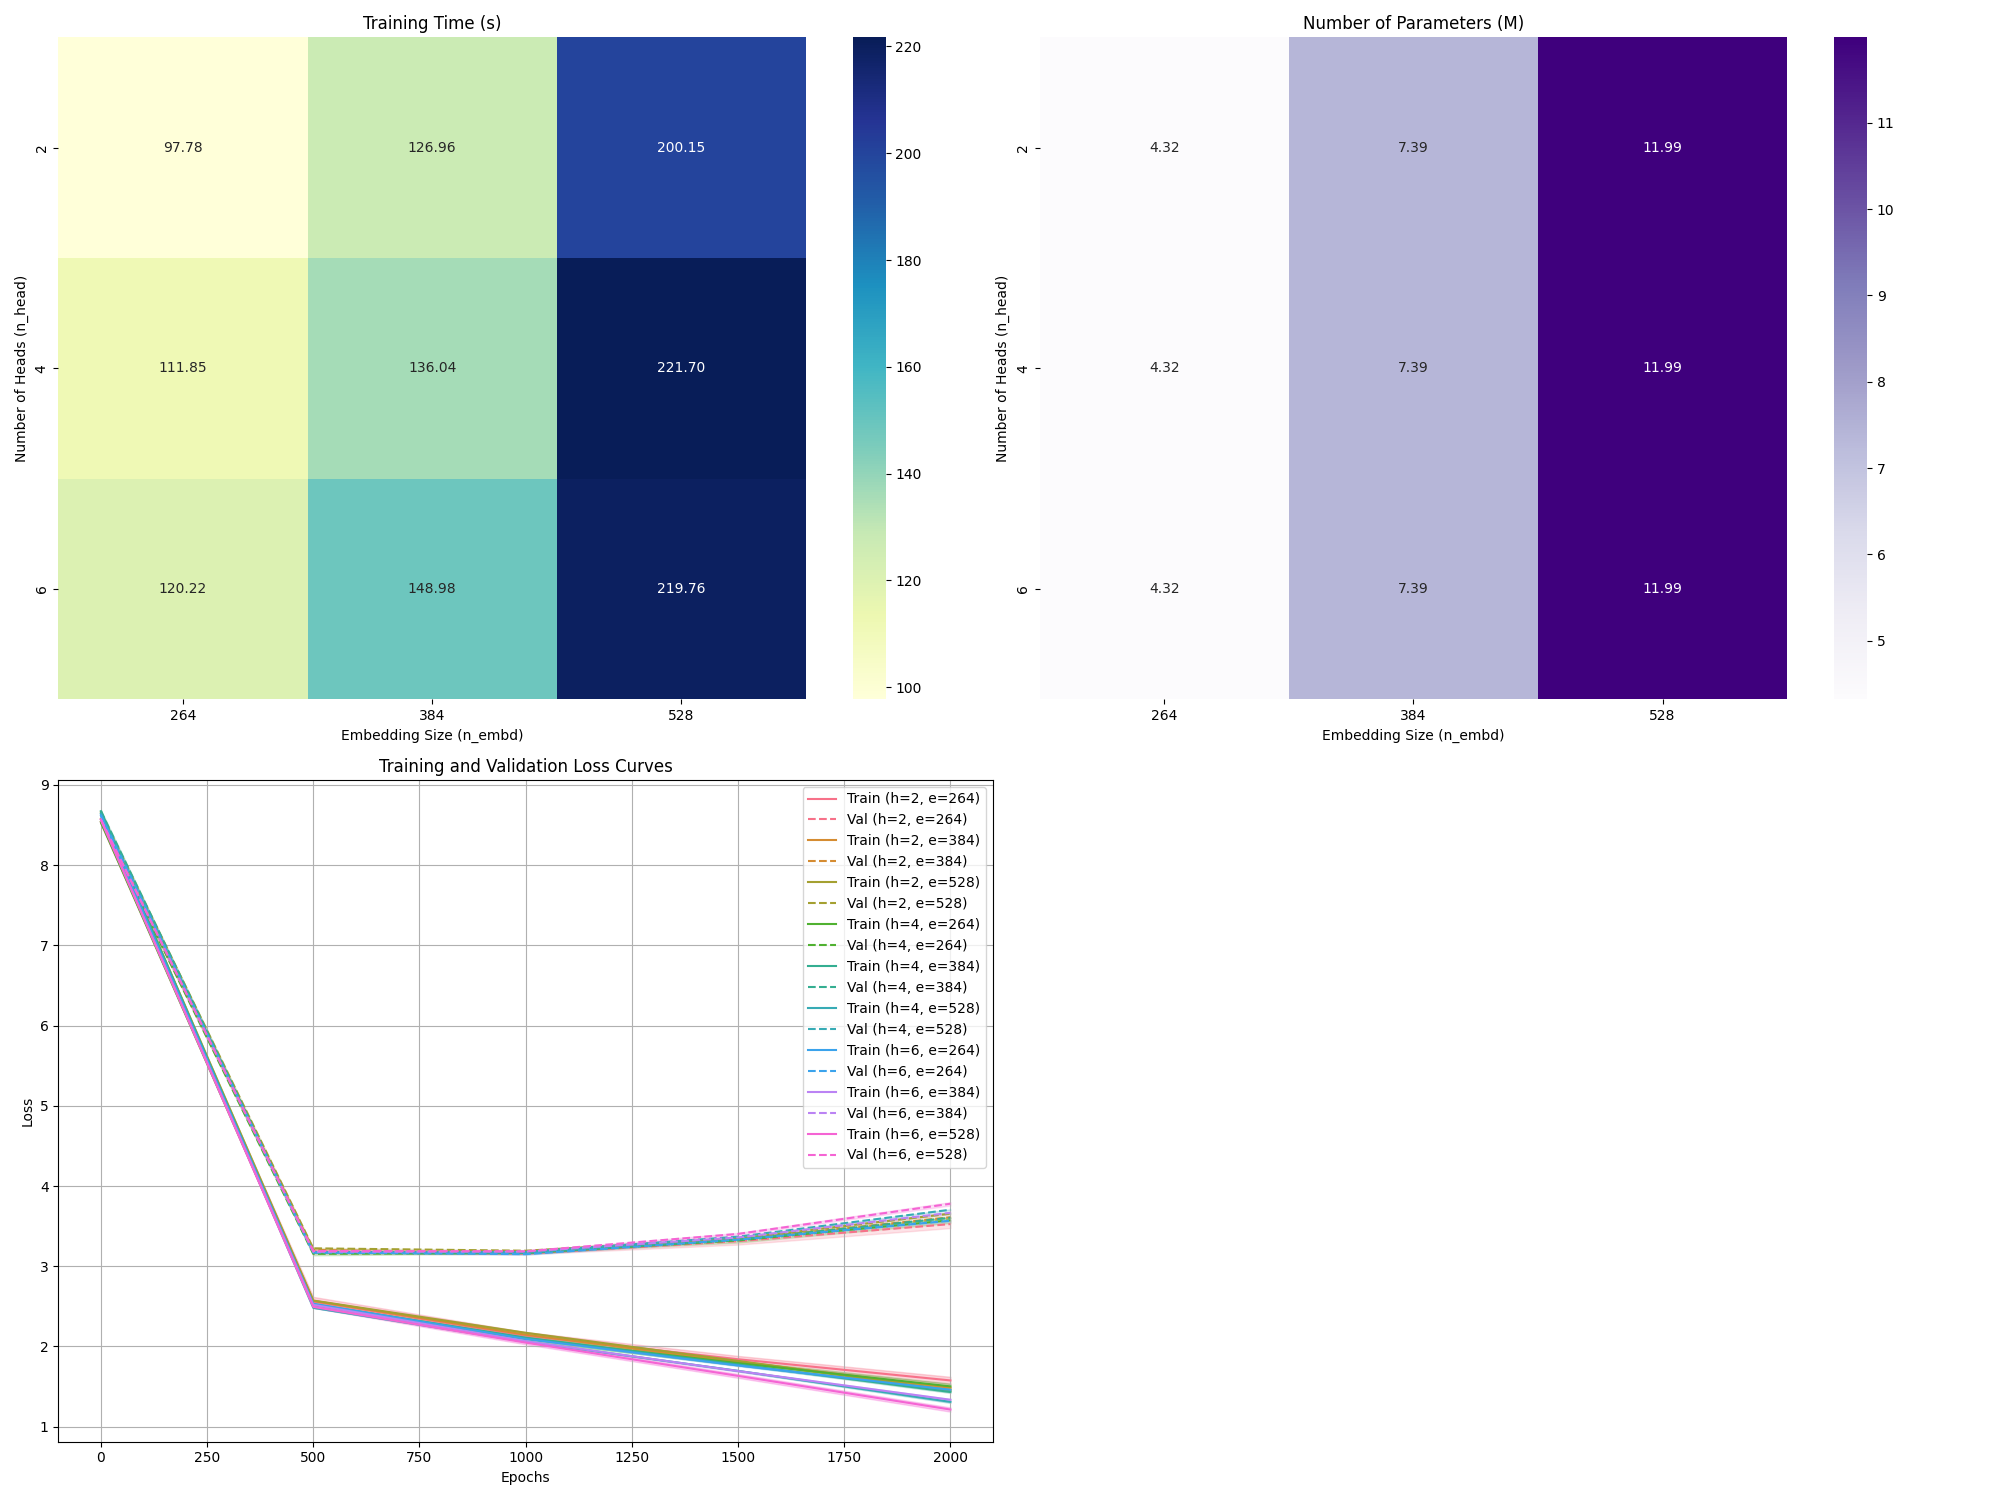

#### Considerations:
The embedding size values were chosen to be divisible for all the three n_head values.
- **Training time**: the training time increases more or less at the same rate as the embedding size (n_embd) parameter. This is also true for the number of attention heads, but the impact on the time elapsed is lower. Generally an higher number of attention heads results in a longer training time, but to our surprise this was not true for the combination of values n_head=6, n_embed=528.
- **Number of parameters**: it is obviously not influenced by the number of attention heads, as for the character-processing model. On the other hand, n_embed has a large impact on the number of parameters as expected like before.
- **Training and validation loss**: if we only consider the training loss, the leading combinations of (n_head, n_embd) are (6, 528), (6, 384) and (4, 528). In particular, we can see a gap between the loss reached by the combination (6, 528) and the others. Taking into account the validation loss also, we can see that, as the training loss decreases, the validation loss increases symmetrically. Again, we must consider that the dataset is of a really small size, as for the vocabular size, thus models are more probably prone to overfit.

In conclusion, in this scenario is difficult to estabilish a single best combination of values.

### Impact of `dropout`

In [ ]:
dropout_rates = [0.1, 0.2, 0.3, 0.4]
results_dropout = test_parameter_variation('dropout', dropout_rates, 128, 64, vocab_size, 512, 4, 2, 0, 500, 2000, 1e-3, 3, 's')
plot_results(results_dropout, 'dropout', 'dropout_s.png')

```
Testing dropout=0.1...
Run 1 of 3:
Train loss: 8.487702369689941, Val loss: 8.4861421585083
Train loss: 2.4536502361297607, Val loss: 3.1503043174743652
Train loss: 1.9629806280136108, Val loss: 3.226896047592163
Train loss: 1.4616092443466187, Val loss: 3.5521249771118164
Train loss: 1.0109819173812866, Val loss: 3.977233648300171
Run 2 of 3:
Train loss: 8.553897857666016, Val loss: 8.567937850952148
Train loss: 2.417551040649414, Val loss: 3.1226308345794678
Train loss: 1.9519281387329102, Val loss: 3.2337841987609863
Train loss: 1.4605199098587036, Val loss: 3.525582790374756
Train loss: 1.0093326568603516, Val loss: 4.005007743835449
Run 3 of 3:
Train loss: 8.531886100769043, Val loss: 8.52609920501709
Train loss: 2.470334529876709, Val loss: 3.183114528656006
Train loss: 2.0219504833221436, Val loss: 3.193532943725586
Train loss: 1.5743201971054077, Val loss: 3.4679315090179443
Train loss: 1.103639841079712, Val loss: 3.8761582374572754
Aggregated results for dropout=0.1:
Final train loss (mean ± std): 1.0413 ± 0.0540
Final val loss (mean ± std): 3.9528 ± 0.0678
Time (mean ± std): 190.97s ± 0.31s
# of parameters: 11.43M

Testing dropout=0.2...
Run 1 of 3:
Train loss: 8.72374439239502, Val loss: 8.712827682495117
Train loss: 2.528238534927368, Val loss: 3.1852657794952393
Train loss: 2.1183230876922607, Val loss: 3.1881978511810303
Train loss: 1.7568877935409546, Val loss: 3.3410048484802246
Train loss: 1.3848071098327637, Val loss: 3.6512365341186523
Run 2 of 3:
Train loss: 8.607593536376953, Val loss: 8.603130340576172
Train loss: 2.4328787326812744, Val loss: 3.169703483581543
Train loss: 2.0013253688812256, Val loss: 3.206669330596924
Train loss: 1.6113789081573486, Val loss: 3.4555087089538574
Train loss: 1.2221790552139282, Val loss: 3.785963535308838
Run 3 of 3:
Train loss: 8.491278648376465, Val loss: 8.506897926330566
Train loss: 2.461069107055664, Val loss: 3.1441810131073
Train loss: 2.0339179039001465, Val loss: 3.1635124683380127
Train loss: 1.642055630683899, Val loss: 3.3762378692626953
Train loss: 1.2376304864883423, Val loss: 3.773319721221924
Aggregated results for dropout=0.2:
Final train loss (mean ± std): 1.2815 ± 0.0898
Final val loss (mean ± std): 3.7368 ± 0.0744
Time (mean ± std): 191.11s ± 0.22s
# of parameters: 11.43M

Testing dropout=0.3...
Run 1 of 3:
Train loss: 8.611611366271973, Val loss: 8.596724510192871
Train loss: 2.5295464992523193, Val loss: 3.1664133071899414
Train loss: 2.1620750427246094, Val loss: 3.1530466079711914
Train loss: 1.8634469509124756, Val loss: 3.298301935195923
Train loss: 1.5342553853988647, Val loss: 3.5021049976348877
Run 2 of 3:
Train loss: 8.781007766723633, Val loss: 8.768386840820312
Train loss: 2.5170798301696777, Val loss: 3.2219936847686768
Train loss: 2.11959171295166, Val loss: 3.1814348697662354
Train loss: 1.7992838621139526, Val loss: 3.2797772884368896
Train loss: 1.4627646207809448, Val loss: 3.5581552982330322
Run 3 of 3:
Train loss: 8.632501602172852, Val loss: 8.632511138916016
Train loss: 2.4687302112579346, Val loss: 3.1777946949005127
Train loss: 2.08845591545105, Val loss: 3.1933014392852783
Train loss: 1.7395143508911133, Val loss: 3.3670263290405273
Train loss: 1.4079771041870117, Val loss: 3.6488165855407715
Aggregated results for dropout=0.3:
Final train loss (mean ± std): 1.4683 ± 0.0633
Final val loss (mean ± std): 3.5697 ± 0.0740
Time (mean ± std): 190.98s ± 0.20s
# of parameters: 11.43M

Testing dropout=0.4...
Run 1 of 3:
Train loss: 8.719552993774414, Val loss: 8.717672348022461
Train loss: 2.543055534362793, Val loss: 3.1906871795654297
Train loss: 2.202540397644043, Val loss: 3.1850008964538574
Train loss: 1.9120383262634277, Val loss: 3.270224094390869
Train loss: 1.6300671100616455, Val loss: 3.4877407550811768
Run 2 of 3:
Train loss: 8.655653953552246, Val loss: 8.661768913269043
Train loss: 2.581397771835327, Val loss: 3.203712224960327
Train loss: 2.1836891174316406, Val loss: 3.157788038253784
Train loss: 1.8905155658721924, Val loss: 3.275949001312256
Train loss: 1.5928699970245361, Val loss: 3.470141649246216
Run 3 of 3:
Train loss: 8.76901626586914, Val loss: 8.753098487854004
Train loss: 2.5735604763031006, Val loss: 3.2390875816345215
Train loss: 2.2069742679595947, Val loss: 3.161831855773926
Train loss: 1.9358229637145996, Val loss: 3.274027109146118
Train loss: 1.6414122581481934, Val loss: 3.4639577865600586
Aggregated results for dropout=0.4:
Final train loss (mean ± std): 1.6214 ± 0.0254
Final val loss (mean ± std): 3.4739 ± 0.0123
Time (mean ± std): 191.06s ± 0.08s
# of parameters: 11.43M
```
![](https://raw.githubusercontent.com/martinasp00/MIRCV-Project/bd4ddd77964d16e820ca1152e8de53c41ccf5ebf/images/dropout_s.png)
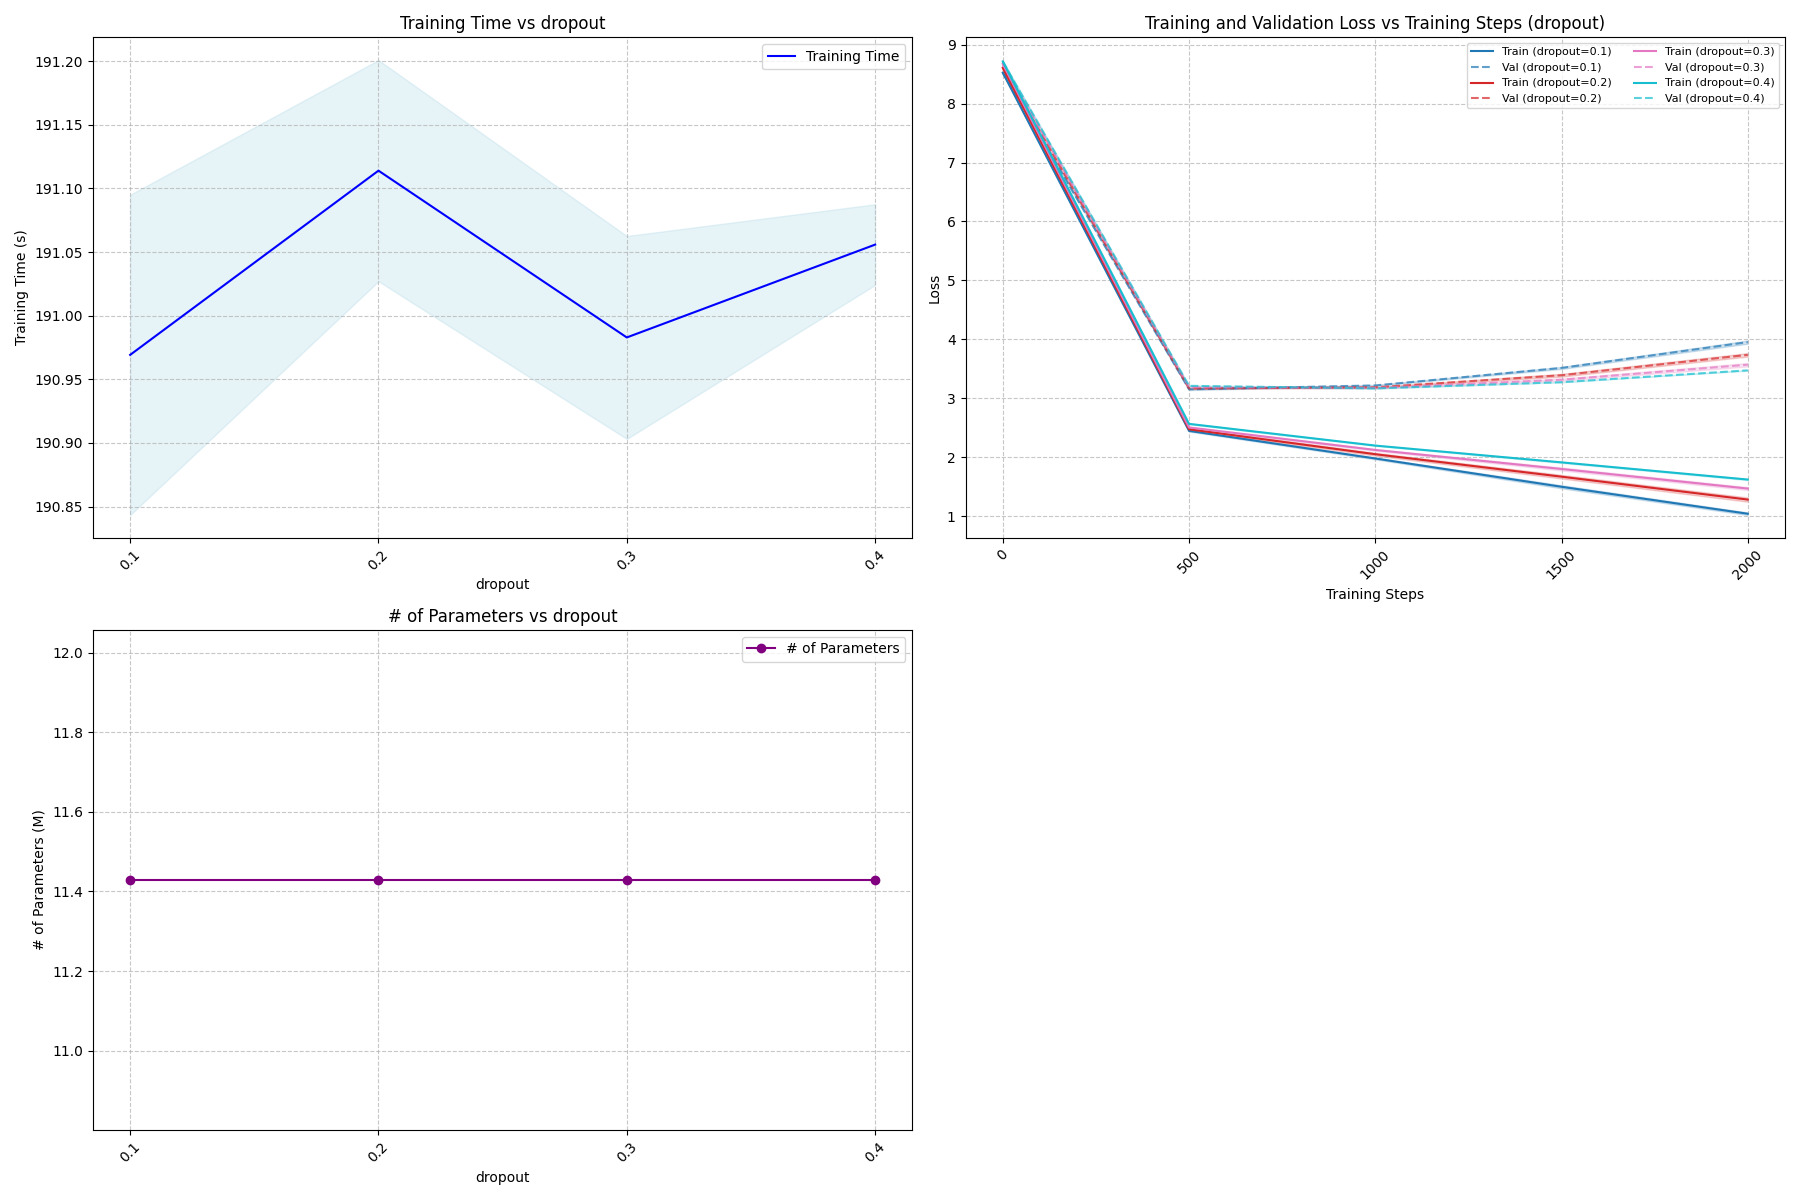

#### Considerations:
- **Training time**: it should slightly decrease with increasing dropout, but we do not see significant impacts. The effects of changing the dropout rate were previously discussed for the character-processing model.
- **Training and validation loss**: the loss is impacted by the dropout as expected, since a higher parameter value helps reducing the overfitting risk.
- **Number of parameters**: this value was not impacted at all by the dropout rate, since it does not influence the model's structure.

In conclusion, in this case higher dropout values are to prefer because they reduce the validation loss and thus the overfitting risk, with the best dropout rate being 0.4, considering the negligible training time difference with respect to the other cases.

### `Learning rate` analysis

Step 0/100: LR=1.0e-04, Train Loss=4.0072, Val Loss=4.1509
Step 10/100: LR=2.0e-04, Train Loss=3.7366, Val Loss=4.1595
Step 20/100: LR=4.0e-04, Train Loss=4.2721, Val Loss=4.8440
Step 30/100: LR=8.1e-04, Train Loss=4.5902, Val Loss=5.2813
Step 40/100: LR=1.6e-03, Train Loss=4.6541, Val Loss=5.4800
Step 50/100: LR=3.3e-03, Train Loss=4.9288, Val Loss=5.5914
Step 60/100: LR=6.6e-03, Train Loss=4.0056, Val Loss=4.5677
Step 70/100: LR=1.3e-02, Train Loss=3.9909, Val Loss=4.4996
Step 80/100: LR=2.7e-02, Train Loss=3.8647, Val Loss=4.1555
Step 90/100: LR=5.3e-02, Train Loss=4.5861, Val Loss=4.8980
Best LR (based on val loss): 1.3e-04


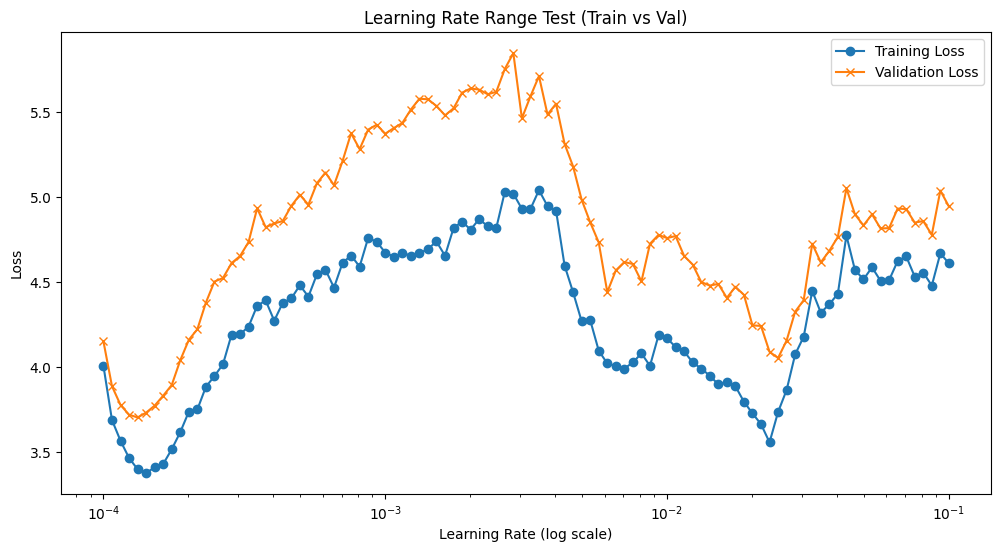

In [28]:
lr_exponents = torch.linspace(-4, -1, steps=100)
learning_rates = 10 ** lr_exponents

batch_size = 32
block_size = 32

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embed=528,
    n_head=4,
    n_layer=4,
    dropout=0.4
).to(device)

eval_iters = 1
learning_rate = lr_analysis(model, torch.optim.AdamW(model.parameters()), 99, 's', 32, 32)
eval_iters = 100

### 5.2.1. "Final" syllable-processing model

In [29]:
max_iters = 5000
eval_interval = 500
block_size = 32
batch_size = 32
learning_rate = 1.3e-04

In [30]:
del model
torch.cuda.empty_cache()

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embed=528,
    n_head=4,
    n_layer=4,
    dropout=0.4
).to(device)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters\n')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model, 's', batch_size, block_size)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train', 's', batch_size, block_size)

    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

idx = torch.zeros((1,1), dtype=torch.long)
idx = idx.to(device)
print(decode_syllables(model.generate(idx, max_new_tokens=700)[0].tolist()))

18.639113 M parameters

step 0: train loss 8.8756, val loss 8.8679
step 500: train loss 3.1045, val loss 3.4448
step 1000: train loss 2.7480, val loss 3.1986
step 1500: train loss 2.5887, val loss 3.0937
step 2000: train loss 2.5032, val loss 3.0840
step 2500: train loss 2.4231, val loss 3.0576
step 3000: train loss 2.3557, val loss 3.0550
step 3500: train loss 2.2918, val loss 3.0352
step 4000: train loss 2.2402, val loss 3.0542
step 4500: train loss 2.1780, val loss 3.0359
step 4999: train loss 2.1271, val loss 3.0640


Menenius:
what, is the war a piwalls for's fame?

Cominius:
me, farewell:
'gregory, pamlous my jealous;-fled in the fruits
suggest gallant have forgottending shame the air
that may not fight with tears:
the who, so if i am, by another
a perpedikytable breath of this contract underless.

Angelo:
puts a horse and absent.

Paris:
i do beseech your first senator: hear me
god list to the city severe
the summer, or wish absolute trull
unall the and ways by his disposilar.
B

# 6. Final considerations on the models obtained
Both the final models for the character-processing and syllables-processing tasks were able to generate plausible text, that is coherent with the respective input dataset: the character-generating model produced a text shaped like a poem, with realistic punctuation and syntax, and the syllable-generating one produced a believable script.

A further development of the project, given a sufficiently powerful hardware, would be to also run the hyperparameters tests for a word-processing model. 